In [17]:
import pandas as pd
from pandas import read_csv
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import glob

In [12]:
def sMAPE(a, b):
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()

In [13]:
def rmsle(y, y_pred):     
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
def lstm_multivariate(filename):
    
    values = filename.values
    
    # integer encode direction
    encoder = LabelEncoder()
    values[:,4] = encoder.fit_transform(values[:,4])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[10,11,11,12,13,14,15,16,17]], axis=1, inplace=True)
    print(reframed.head())
    
    
    # split into train and test sets
    print("Splitting into train and test")
    values = reframed.values
    n_train_hours = 33600
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    
    # design network
    print("Designing network")
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
   
    # fit network
    print("Fitting network")
    history = model.fit(train_X, train_y, epochs=5, batch_size=70,validation_split=0.04,validation_data=(test_X, test_y), verbose=1, shuffle=False)
    
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    #Metrics
    print('Calculating metrics')
    mape_i = sMAPE(inv_y, inv_yhat)
    rmsle_i = rmsle(inv_y, inv_yhat)
    
    return mape_i, rmsle_i


filename number 1
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.018010   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.058319   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.043739   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.051458   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.086621   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.058319  
2   0.403581   0.909091        1.0  0.043739  
3   0.414601   0.870130        1.0  0.051458  
4   0.414601   0.870130        1.0  0.086621  
5   0.362948   0.883117        1.0  0.072041  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0242 - val_loss: 0.0307
Epoch 2/5
33

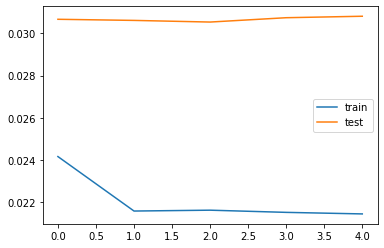

Calculating metrics
filename number 2
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.311614   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.245399   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.210493   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.232494   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.286863   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.245399  
2   0.403581   0.909091        1.0  0.210493  
3   0.414601   0.870130        1.0  0.232494  
4   0.414601   0.870130        1.0  0.286863  
5   0.362948   0.883117        1.0  0.136873  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 72us/step - loss: 0.0501 - val_loss:

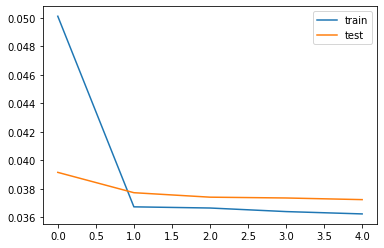

Calculating metrics
filename number 3
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.213094   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.180745   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.217458   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.214377   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.204365   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.180745  
2   0.403581   0.909091        1.0  0.217458  
3   0.414601   0.870130        1.0  0.214377  
4   0.414601   0.870130        1.0  0.204365  
5   0.362948   0.883117        1.0  0.156611  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 91us/step - loss: 0.0591 - val_loss:

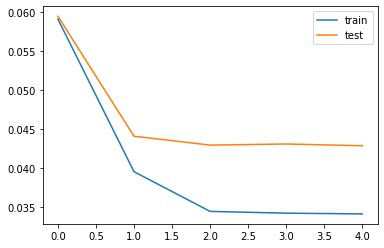

Calculating metrics
filename number 4
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.122598   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.130833   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.176578   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.032022   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.035682   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.130833  
2   0.403581   0.909091        1.0  0.176578  
3   0.414601   0.870130        1.0  0.032022  
4   0.414601   0.870130        1.0  0.035682  
5   0.362948   0.883117        1.0  0.039341  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0302 - val_loss:

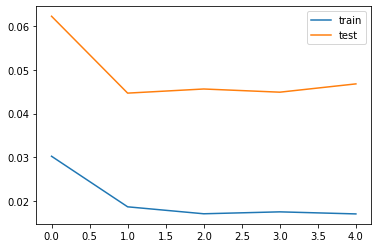

Calculating metrics
filename number 5
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.057228   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.045737   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.068490   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.046426   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.036773   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.045737  
2   0.403581   0.909091        1.0  0.068490  
3   0.414601   0.870130        1.0  0.046426  
4   0.414601   0.870130        1.0  0.036773  
5   0.362948   0.883117        1.0  0.033096  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0290 - val_loss:

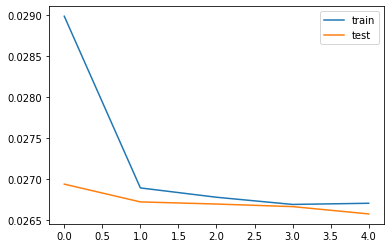

Calculating metrics
filename number 6
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.124530   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.105713   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.091345   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.044817   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.037975   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.105713  
2   0.403581   0.909091        1.0  0.091345  
3   0.414601   0.870130        1.0  0.044817  
4   0.414601   0.870130        1.0  0.037975  
5   0.362948   0.883117        1.0  0.026001  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0443 - val_loss:

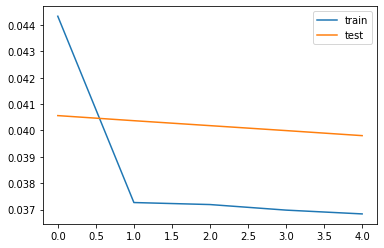

Calculating metrics
filename number 7
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.065983   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.068225   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.067585   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.115631   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.065022   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.068225  
2   0.403581   0.909091        1.0  0.067585  
3   0.414601   0.870130        1.0  0.115631  
4   0.414601   0.870130        1.0  0.065022  
5   0.362948   0.883117        1.0  0.059898  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0533 - val_loss:

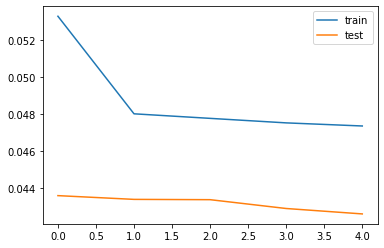

Calculating metrics
filename number 8
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.081356   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.056497   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.039171   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.044444   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.023352   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.056497  
2   0.403581   0.909091        1.0  0.039171  
3   0.414601   0.870130        1.0  0.044444  
4   0.414601   0.870130        1.0  0.023352  
5   0.362948   0.883117        1.0  0.044068  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 71us/step - loss: 0.0264 - val_loss:

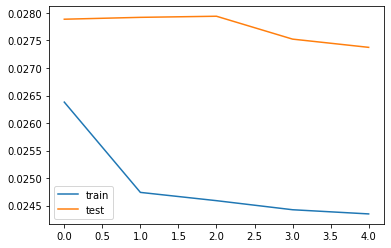

Calculating metrics
filename number 9
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.117481   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.123120   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.114662   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.108083   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.073778   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.123120  
2   0.403581   0.909091        1.0  0.114662  
3   0.414601   0.870130        1.0  0.108083  
4   0.414601   0.870130        1.0  0.073778  
5   0.362948   0.883117        1.0  0.073543  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0493 - val_loss:

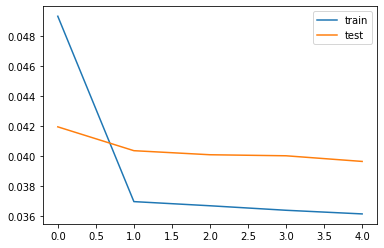

Calculating metrics
filename number 10
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.091274   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.090772   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.048144   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.023069   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.016550   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.090772  
2   0.403581   0.909091        1.0  0.048144  
3   0.414601   0.870130        1.0  0.023069  
4   0.414601   0.870130        1.0  0.016550  
5   0.362948   0.883117        1.0  0.017553  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0390 - val_loss

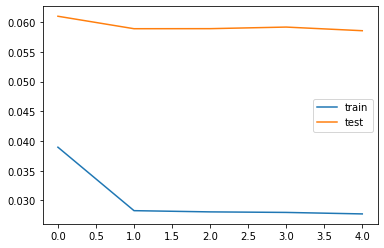

Calculating metrics
filename number 11
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.060081   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.050577   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.051595   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.039036   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.038697   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.050577  
2   0.403581   0.909091        1.0  0.051595  
3   0.414601   0.870130        1.0  0.039036  
4   0.414601   0.870130        1.0  0.038697  
5   0.362948   0.883117        1.0  0.050577  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 93us/step - loss: 0.0377 - val_loss

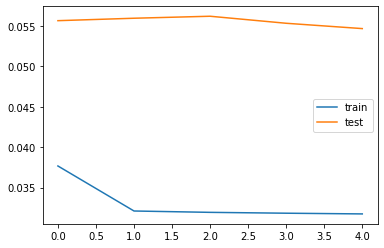

Calculating metrics
filename number 12
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.041738   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.458046   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.380594   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.511403   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.347676   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.458046  
2   0.403581   0.909091        1.0  0.380594  
3   0.414601   0.870130        1.0  0.511403  
4   0.414601   0.870130        1.0  0.347676  
5   0.362948   0.883117        1.0  0.314974  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0402 - val_loss

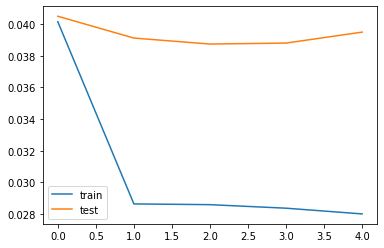

Calculating metrics
filename number 13
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.032312   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.033977   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.031312   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.030979   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.031312   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.033977  
2   0.403581   0.909091        1.0  0.031312  
3   0.414601   0.870130        1.0  0.030979  
4   0.414601   0.870130        1.0  0.031312  
5   0.362948   0.883117        1.0  0.031646  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0208 - val_loss

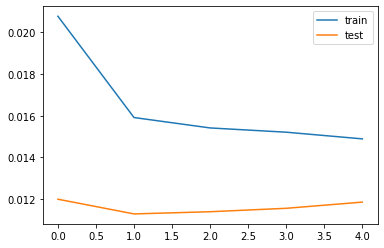

Calculating metrics
filename number 14
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.148114   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.303588   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.226311   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.133395   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.044158   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.303588  
2   0.403581   0.909091        1.0  0.226311  
3   0.414601   0.870130        1.0  0.133395  
4   0.414601   0.870130        1.0  0.044158  
5   0.362948   0.883117        1.0  0.053358  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 76us/step - loss: 0.0413 - val_loss

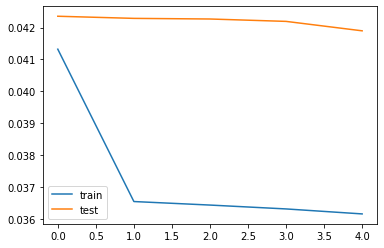

Calculating metrics
filename number 15
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.042271   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.042271   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.042902   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.043533   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.043533   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.042271  
2   0.403581   0.909091        1.0  0.042902  
3   0.414601   0.870130        1.0  0.043533  
4   0.414601   0.870130        1.0  0.043533  
5   0.362948   0.883117        1.0  0.042902  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0351 - val_loss

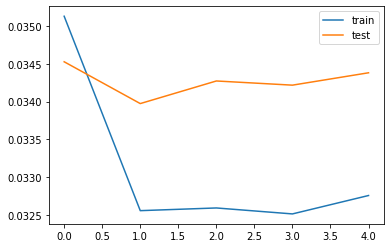

Calculating metrics
filename number 16
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.074850   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.060878   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.025449   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.035928   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.044411   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.060878  
2   0.403581   0.909091        1.0  0.025449  
3   0.414601   0.870130        1.0  0.035928  
4   0.414601   0.870130        1.0  0.044411  
5   0.362948   0.883117        1.0  0.021457  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0350 - val_loss

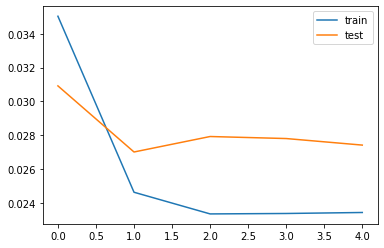

Calculating metrics
filename number 17
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.023029   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.023279   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.057572   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.037297   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.044055   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.023279  
2   0.403581   0.909091        1.0  0.057572  
3   0.414601   0.870130        1.0  0.037297  
4   0.414601   0.870130        1.0  0.044055  
5   0.362948   0.883117        1.0  0.030288  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0240 - val_loss

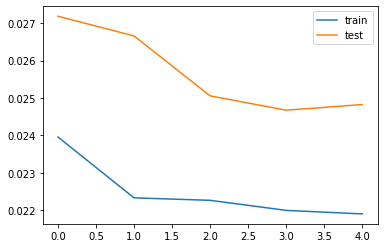

Calculating metrics
filename number 18
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.018817   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.018049   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.019201   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.009601   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.011905   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.018049  
2   0.403581   0.909091        1.0  0.019201  
3   0.414601   0.870130        1.0  0.009601  
4   0.414601   0.870130        1.0  0.011905  
5   0.362948   0.883117        1.0  0.012673  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0471 - val_loss

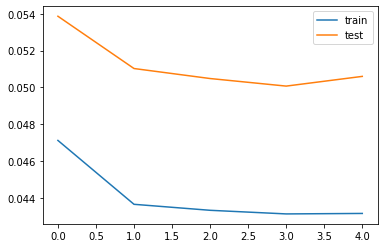

Calculating metrics
filename number 19
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.104306   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.100478   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.111962   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.105263   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.047847   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.100478  
2   0.403581   0.909091        1.0  0.111962  
3   0.414601   0.870130        1.0  0.105263  
4   0.414601   0.870130        1.0  0.047847  
5   0.362948   0.883117        1.0  0.044019  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0374 - val_loss

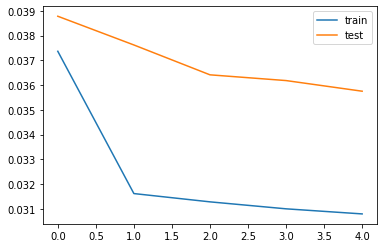

Calculating metrics
filename number 20
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.025372   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.027303   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.059846   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.030061   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.006343   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.027303  
2   0.403581   0.909091        1.0  0.059846  
3   0.414601   0.870130        1.0  0.030061  
4   0.414601   0.870130        1.0  0.006343  
5   0.362948   0.883117        1.0  0.006343  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0637 - val_loss

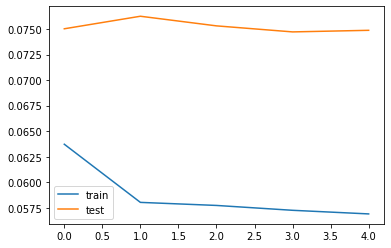

Calculating metrics
filename number 21
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.098958   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.098090   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.098090   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.085069   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.052083   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.098090  
2   0.403581   0.909091        1.0  0.098090  
3   0.414601   0.870130        1.0  0.085069  
4   0.414601   0.870130        1.0  0.052083  
5   0.362948   0.883117        1.0  0.047743  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0415 - val_loss

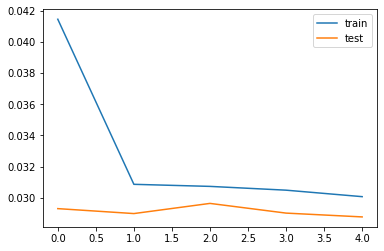

Calculating metrics
filename number 22
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.011507   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.001918   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.006904   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.014960   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.007672   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.001918  
2   0.403581   0.909091        1.0  0.006904  
3   0.414601   0.870130        1.0  0.014960  
4   0.414601   0.870130        1.0  0.007672  
5   0.362948   0.883117        1.0  0.013425  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0188 - val_loss

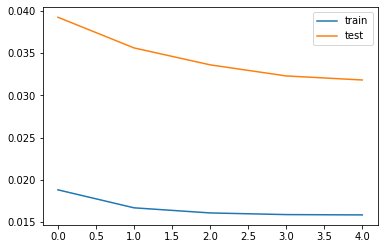

Calculating metrics
filename number 23
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.013415   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.001524   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.019817   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.002134   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.014024   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.001524  
2   0.403581   0.909091        1.0  0.019817  
3   0.414601   0.870130        1.0  0.002134  
4   0.414601   0.870130        1.0  0.014024  
5   0.362948   0.883117        1.0  0.007927  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0578 - val_loss

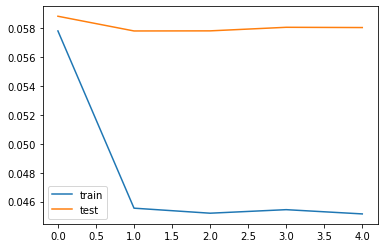

Calculating metrics
filename number 24
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.024534   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.015750   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.084507   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.047100   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.038922   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.015750  
2   0.403581   0.909091        1.0  0.084507  
3   0.414601   0.870130        1.0  0.047100  
4   0.414601   0.870130        1.0  0.038922  
5   0.362948   0.883117        1.0  0.031501  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0612 - val_loss

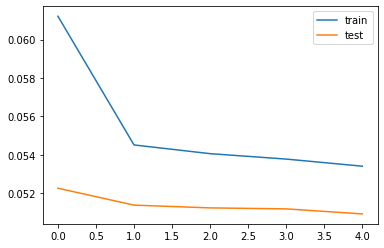

Calculating metrics
filename number 25
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.007401   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.012240   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.304014   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.197267   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.195275   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.012240  
2   0.403581   0.909091        1.0  0.304014  
3   0.414601   0.870130        1.0  0.197267  
4   0.414601   0.870130        1.0  0.195275  
5   0.362948   0.883117        1.0  0.190436  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0714 - val_loss

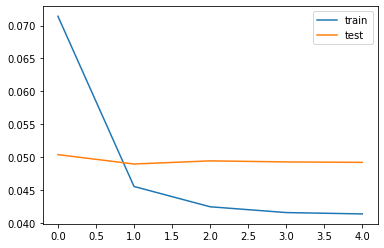

Calculating metrics
filename number 26
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.023299   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.032914   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.033654   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.031805   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.024408   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.032914  
2   0.403581   0.909091        1.0  0.033654  
3   0.414601   0.870130        1.0  0.031805  
4   0.414601   0.870130        1.0  0.024408  
5   0.362948   0.883117        1.0  0.025148  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0246 - val_loss

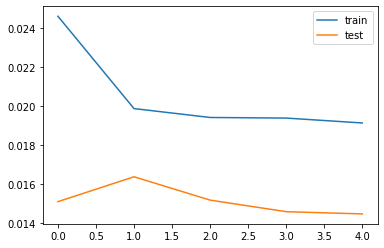

Calculating metrics
filename number 27
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.059770   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.065900   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.058238   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.134100   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.129502   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.065900  
2   0.403581   0.909091        1.0  0.058238  
3   0.414601   0.870130        1.0  0.134100  
4   0.414601   0.870130        1.0  0.129502  
5   0.362948   0.883117        1.0  0.032950  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0402 - val_loss

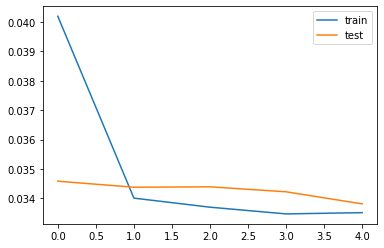

Calculating metrics
filename number 28
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.100623   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.085290   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.077144   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.047916   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.069957   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.085290  
2   0.403581   0.909091        1.0  0.077144  
3   0.414601   0.870130        1.0  0.047916  
4   0.414601   0.870130        1.0  0.069957  
5   0.362948   0.883117        1.0  0.063728  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0464 - val_loss

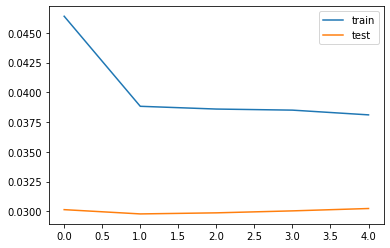

Calculating metrics
filename number 29
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.177316   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.164438   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.159485   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.120357   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.067360   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.164438  
2   0.403581   0.909091        1.0  0.159485  
3   0.414601   0.870130        1.0  0.120357  
4   0.414601   0.870130        1.0  0.067360  
5   0.362948   0.883117        1.0  0.018326  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 915s 27ms/step - loss: 0.0498 - val_lo

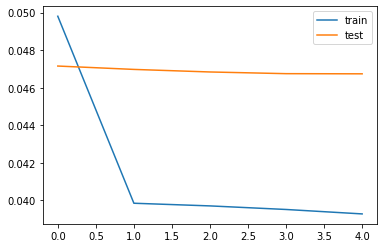

Calculating metrics
filename number 30
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.173390   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.192009   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.177657   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.182700   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.169123   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.192009  
2   0.403581   0.909091        1.0  0.177657  
3   0.414601   0.870130        1.0  0.182700  
4   0.414601   0.870130        1.0  0.169123  
5   0.362948   0.883117        1.0  0.132273  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0417 - val_loss

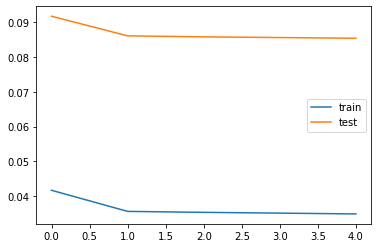

Calculating metrics
filename number 31
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.080729   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.038021   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.022917   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.029688   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.026563   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.038021  
2   0.403581   0.909091        1.0  0.022917  
3   0.414601   0.870130        1.0  0.029688  
4   0.414601   0.870130        1.0  0.026563  
5   0.362948   0.883117        1.0  0.010938  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 81us/step - loss: 0.0262 - val_loss

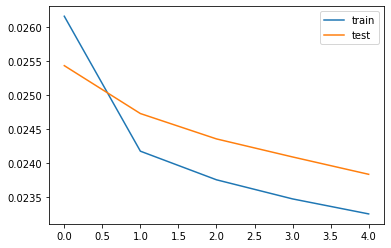

Calculating metrics
filename number 32
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.028298   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.027258   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.025801   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.029963   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.049313   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.027258  
2   0.403581   0.909091        1.0  0.025801  
3   0.414601   0.870130        1.0  0.029963  
4   0.414601   0.870130        1.0  0.049313  
5   0.362948   0.883117        1.0  0.004786  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0263 - val_loss

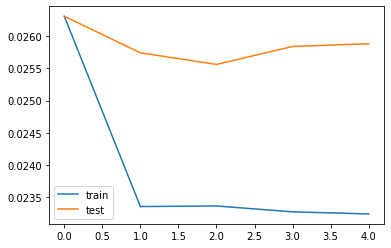

Calculating metrics
filename number 33
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.077030   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.006708   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.054823   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.001157   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.003701   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.006708  
2   0.403581   0.909091        1.0  0.054823  
3   0.414601   0.870130        1.0  0.001157  
4   0.414601   0.870130        1.0  0.003701  
5   0.362948   0.883117        1.0  0.000463  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0310 - val_loss

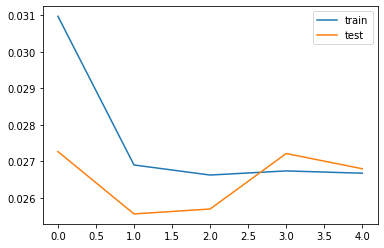

Calculating metrics
filename number 34
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.065322   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.059358   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.045726   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.059358   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.047430   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.059358  
2   0.403581   0.909091        1.0  0.045726  
3   0.414601   0.870130        1.0  0.059358  
4   0.414601   0.870130        1.0  0.047430  
5   0.362948   0.883117        1.0  0.050270  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0441 - val_loss

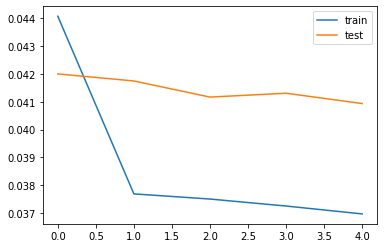

Calculating metrics
filename number 35
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.014099   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.014443   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.043329   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.048487   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.035076   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.014443  
2   0.403581   0.909091        1.0  0.043329  
3   0.414601   0.870130        1.0  0.048487  
4   0.414601   0.870130        1.0  0.035076  
5   0.362948   0.883117        1.0  0.033700  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 55us/step - loss: 0.0276 - val_loss

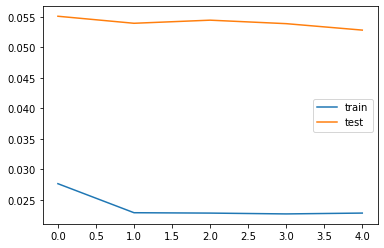

Calculating metrics
filename number 36
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.016577   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.025841   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.008289   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.005363   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.005363   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.025841  
2   0.403581   0.909091        1.0  0.008289  
3   0.414601   0.870130        1.0  0.005363  
4   0.414601   0.870130        1.0  0.005363  
5   0.362948   0.883117        1.0  0.022428  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0248 - val_loss

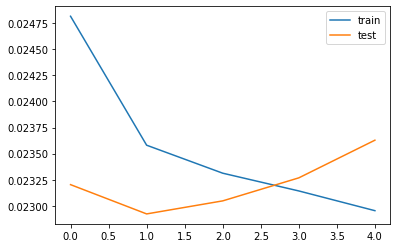

Calculating metrics
filename number 37
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064704   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.077584   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.065011   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.026372   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.010733   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.077584  
2   0.403581   0.909091        1.0  0.065011  
3   0.414601   0.870130        1.0  0.026372  
4   0.414601   0.870130        1.0  0.010733  
5   0.362948   0.883117        1.0  0.018399  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0315 - val_loss

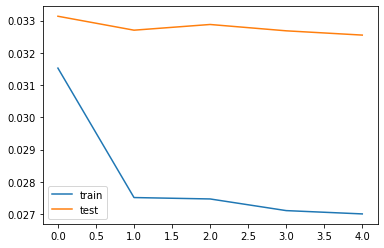

Calculating metrics
filename number 38
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008696   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.019324   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.037681   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.009662   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.017391   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.019324  
2   0.403581   0.909091        1.0  0.037681  
3   0.414601   0.870130        1.0  0.009662  
4   0.414601   0.870130        1.0  0.017391  
5   0.362948   0.883117        1.0  0.039614  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 72us/step - loss: 0.0333 - val_loss

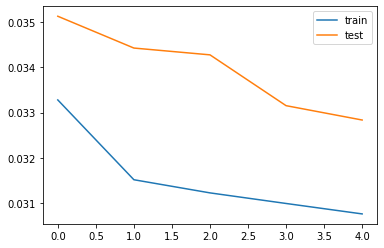

Calculating metrics
filename number 39
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.118151   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.114516   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.112698   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.128538   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.198909   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.114516  
2   0.403581   0.909091        1.0  0.112698  
3   0.414601   0.870130        1.0  0.128538  
4   0.414601   0.870130        1.0  0.198909  
5   0.362948   0.883117        1.0  0.119709  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0357 - val_loss

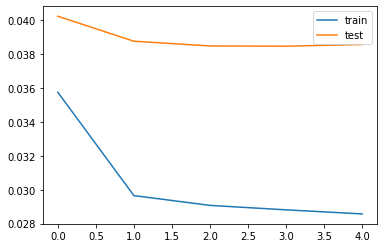

Calculating metrics
filename number 40
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.039086   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.032448   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.006637   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.031711   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.018437   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.032448  
2   0.403581   0.909091        1.0  0.006637  
3   0.414601   0.870130        1.0  0.031711  
4   0.414601   0.870130        1.0  0.018437  
5   0.362948   0.883117        1.0  0.011062  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 83us/step - loss: 0.0264 - val_loss

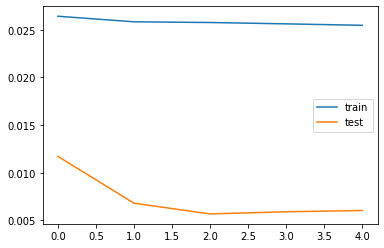

Calculating metrics
filename number 41
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.013730   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.021358   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.012586   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.020214   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020595   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.021358  
2   0.403581   0.909091        1.0  0.012586  
3   0.414601   0.870130        1.0  0.020214  
4   0.414601   0.870130        1.0  0.020595  
5   0.362948   0.883117        1.0  0.011823  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0265 - val_loss

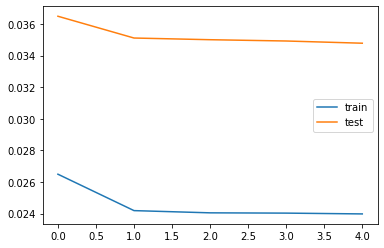

Calculating metrics
filename number 42
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.098323   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.056680   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.009254   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.006362   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.017351   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.056680  
2   0.403581   0.909091        1.0  0.009254  
3   0.414601   0.870130        1.0  0.006362  
4   0.414601   0.870130        1.0  0.017351  
5   0.362948   0.883117        1.0  0.000000  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0381 - val_loss

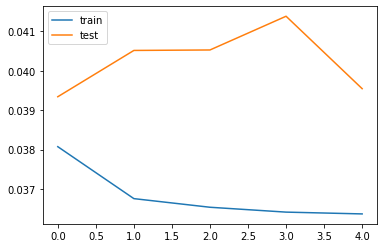

Calculating metrics
filename number 43
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.040238   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.032414   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.041915   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.017511   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.013413   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.032414  
2   0.403581   0.909091        1.0  0.041915  
3   0.414601   0.870130        1.0  0.017511  
4   0.414601   0.870130        1.0  0.013413  
5   0.362948   0.883117        1.0  0.013040  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0334 - val_loss

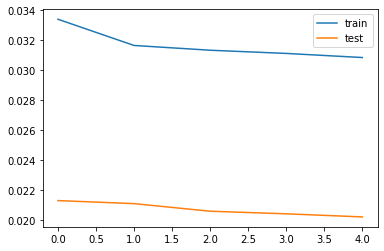

Calculating metrics
filename number 44
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.132273   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.121786   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.123478   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.156292   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.111299   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.121786  
2   0.403581   0.909091        1.0  0.123478  
3   0.414601   0.870130        1.0  0.156292  
4   0.414601   0.870130        1.0  0.111299  
5   0.362948   0.883117        1.0  0.072057  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 78us/step - loss: 0.0442 - val_loss

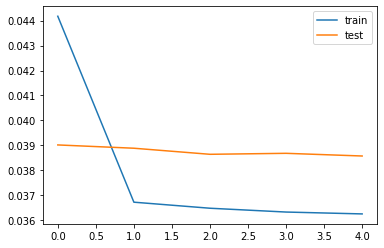

Calculating metrics
filename number 45
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.034779   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.042508   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.030056   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.048519   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.031773   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.042508  
2   0.403581   0.909091        1.0  0.030056  
3   0.414601   0.870130        1.0  0.048519  
4   0.414601   0.870130        1.0  0.031773  
5   0.362948   0.883117        1.0  0.034350  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 88us/step - loss: 0.0406 - val_loss

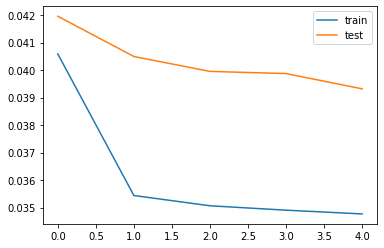

Calculating metrics
filename number 46
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.006555   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.005827   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.006555   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.005827   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.011653   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.005827  
2   0.403581   0.909091        1.0  0.006555  
3   0.414601   0.870130        1.0  0.005827  
4   0.414601   0.870130        1.0  0.011653  
5   0.362948   0.883117        1.0  0.005827  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 95us/step - loss: 0.0251 - val_loss

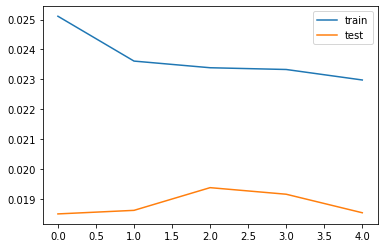

Calculating metrics
filename number 47
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.002917   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.006007   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.001373   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.002746   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.006521   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.006007  
2   0.403581   0.909091        1.0  0.001373  
3   0.414601   0.870130        1.0  0.002746  
4   0.414601   0.870130        1.0  0.006521  
5   0.362948   0.883117        1.0  0.001373  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 86us/step - loss: 0.0133 - val_loss

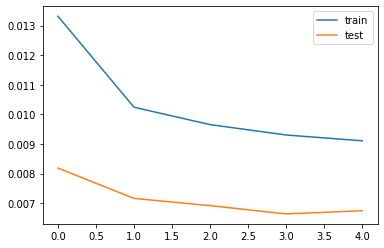

Calculating metrics
filename number 48
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.085754   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.086215   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.071462   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.054864   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020286   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.086215  
2   0.403581   0.909091        1.0  0.071462  
3   0.414601   0.870130        1.0  0.054864  
4   0.414601   0.870130        1.0  0.020286  
5   0.362948   0.883117        1.0  0.018442  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 82us/step - loss: 0.0453 - val_loss

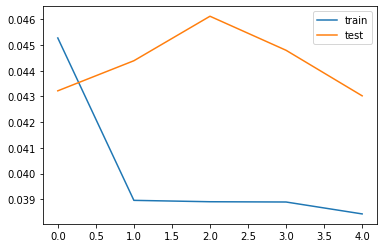

Calculating metrics
filename number 49
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.066072   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.068189   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.065165   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.065770   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.066979   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.068189  
2   0.403581   0.909091        1.0  0.065165  
3   0.414601   0.870130        1.0  0.065770  
4   0.414601   0.870130        1.0  0.066979  
5   0.362948   0.883117        1.0  0.060931  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 82us/step - loss: 0.0524 - val_loss

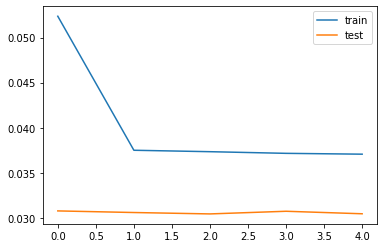

Calculating metrics
filename number 50
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.071583   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.083094   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.089568   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.089209   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.058273   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.083094  
2   0.403581   0.909091        1.0  0.089568  
3   0.414601   0.870130        1.0  0.089209  
4   0.414601   0.870130        1.0  0.058273  
5   0.362948   0.883117        1.0  0.040647  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 80us/step - loss: 0.0312 - val_loss

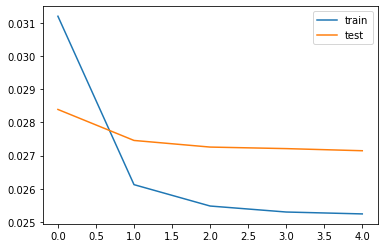

Calculating metrics
filename number 51
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.078571   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.090909   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.088312   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.097403   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.091558   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.090909  
2   0.403581   0.909091        1.0  0.088312  
3   0.414601   0.870130        1.0  0.097403  
4   0.414601   0.870130        1.0  0.091558  
5   0.362948   0.883117        1.0  0.048701  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0422 - val_loss

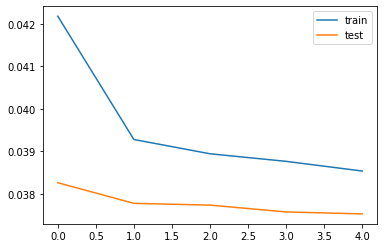

Calculating metrics
filename number 52
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.135900   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.129672   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.095696   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.093431   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.093431   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.129672  
2   0.403581   0.909091        1.0  0.095696  
3   0.414601   0.870130        1.0  0.093431  
4   0.414601   0.870130        1.0  0.093431  
5   0.362948   0.883117        1.0  0.062288  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 71us/step - loss: 0.0426 - val_loss

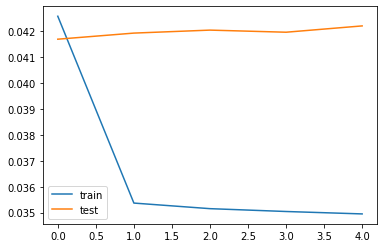

Calculating metrics
filename number 53
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.183206   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.176266   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.154060   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.147120   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.166551   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.176266  
2   0.403581   0.909091        1.0  0.154060  
3   0.414601   0.870130        1.0  0.147120  
4   0.414601   0.870130        1.0  0.166551  
5   0.362948   0.883117        1.0  0.118668  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0365 - val_loss

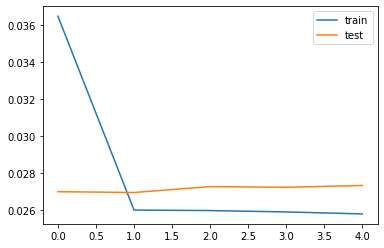

Calculating metrics
filename number 54
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.028140   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.029703   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.030224   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.086503   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.046378   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.029703  
2   0.403581   0.909091        1.0  0.030224  
3   0.414601   0.870130        1.0  0.086503  
4   0.414601   0.870130        1.0  0.046378  
5   0.362948   0.883117        1.0  0.027097  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0249 - val_loss

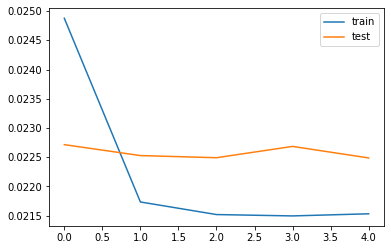

Calculating metrics
filename number 55
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.032924   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.378330   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.515714   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.029333   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.046094   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.378330  
2   0.403581   0.909091        1.0  0.515714  
3   0.414601   0.870130        1.0  0.029333  
4   0.414601   0.870130        1.0  0.046094  
5   0.362948   0.883117        1.0  0.015265  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 74us/step - loss: 0.0418 - val_loss

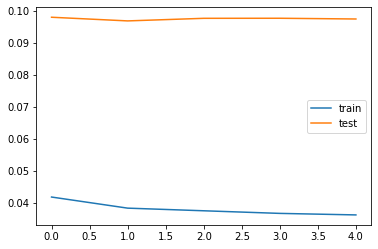

Calculating metrics
filename number 56
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.041449   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.018930   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.017624   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.013381   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.007833   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.018930  
2   0.403581   0.909091        1.0  0.017624  
3   0.414601   0.870130        1.0  0.013381  
4   0.414601   0.870130        1.0  0.007833  
5   0.362948   0.883117        1.0  0.011423  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0259 - val_loss

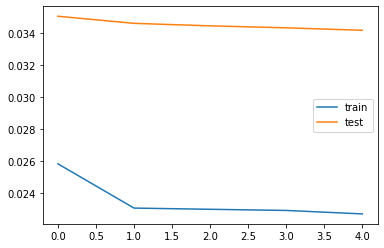

Calculating metrics
filename number 57
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.155600   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.118930   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.169475   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.136769   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.111001   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.118930  
2   0.403581   0.909091        1.0  0.169475  
3   0.414601   0.870130        1.0  0.136769  
4   0.414601   0.870130        1.0  0.111001  
5   0.362948   0.883117        1.0  0.100099  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 83us/step - loss: 0.0494 - val_loss

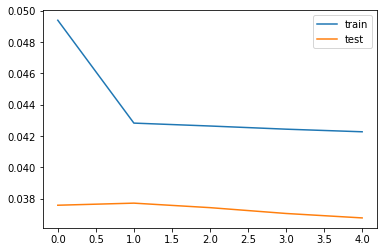

Calculating metrics
filename number 58
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.019808   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.011319   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.020374   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.153933   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.068478   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.011319  
2   0.403581   0.909091        1.0  0.020374  
3   0.414601   0.870130        1.0  0.153933  
4   0.414601   0.870130        1.0  0.068478  
5   0.362948   0.883117        1.0  0.061121  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0232 - val_loss

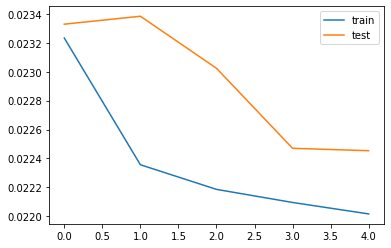

Calculating metrics
filename number 59
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.153269   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.150141   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.445105   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.252111   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.396622   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.150141  
2   0.403581   0.909091        1.0  0.445105  
3   0.414601   0.870130        1.0  0.252111  
4   0.414601   0.870130        1.0  0.396622  
5   0.362948   0.883117        1.0  0.154833  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0417 - val_loss

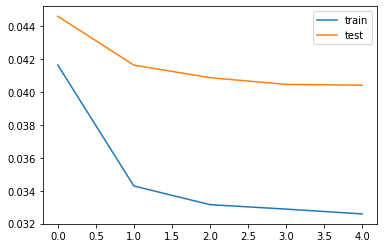

Calculating metrics
filename number 60
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.115245   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.074935   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.070801   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.056331   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.069767   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.074935  
2   0.403581   0.909091        1.0  0.070801  
3   0.414601   0.870130        1.0  0.056331  
4   0.414601   0.870130        1.0  0.069767  
5   0.362948   0.883117        1.0  0.055297  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0283 - val_loss

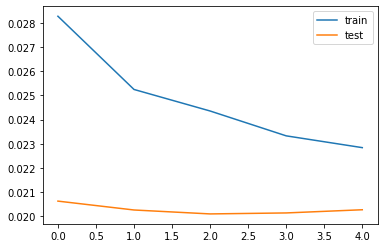

Calculating metrics
filename number 61
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064643   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.069702   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.051152   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.044407   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.039348   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.069702  
2   0.403581   0.909091        1.0  0.051152  
3   0.414601   0.870130        1.0  0.044407  
4   0.414601   0.870130        1.0  0.039348  
5   0.362948   0.883117        1.0  0.032603  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0298 - val_loss

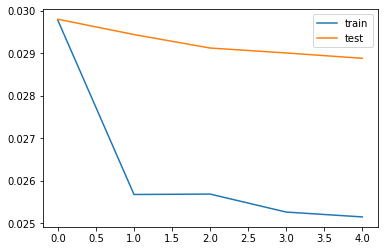

Calculating metrics
filename number 62
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.028707   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.022290   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.036136   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.022627   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.034110   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.022290  
2   0.403581   0.909091        1.0  0.036136  
3   0.414601   0.870130        1.0  0.022627  
4   0.414601   0.870130        1.0  0.034110  
5   0.362948   0.883117        1.0  0.024316  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0245 - val_loss

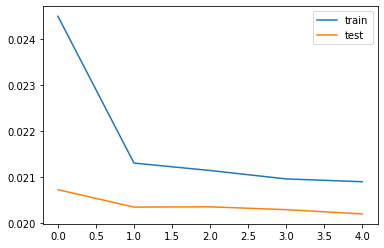

Calculating metrics
filename number 63
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.538288   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.355856   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.355856   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.361486   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.497748   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.355856  
2   0.403581   0.909091        1.0  0.355856  
3   0.414601   0.870130        1.0  0.361486  
4   0.414601   0.870130        1.0  0.497748  
5   0.362948   0.883117        1.0  0.371622  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0523 - val_loss

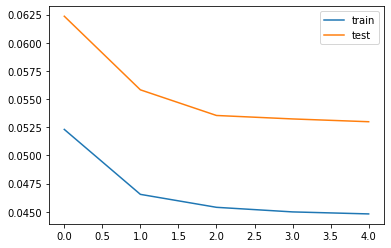

Calculating metrics
filename number 64
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.118635   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.092388   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.089239   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.082415   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.075066   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.092388  
2   0.403581   0.909091        1.0  0.089239  
3   0.414601   0.870130        1.0  0.082415  
4   0.414601   0.870130        1.0  0.075066  
5   0.362948   0.883117        1.0  0.130184  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0478 - val_loss

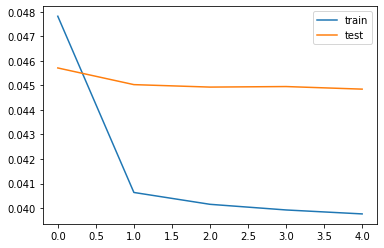

Calculating metrics
filename number 65
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.076890   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.046916   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.048219   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.026064   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.007385   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.046916  
2   0.403581   0.909091        1.0  0.048219  
3   0.414601   0.870130        1.0  0.026064  
4   0.414601   0.870130        1.0  0.007385  
5   0.362948   0.883117        1.0  0.005213  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0415 - val_loss

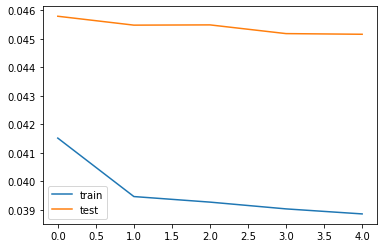

Calculating metrics
filename number 66
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.308516   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.275078   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.107367   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.026907   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.019070   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.275078  
2   0.403581   0.909091        1.0  0.107367  
3   0.414601   0.870130        1.0  0.026907  
4   0.414601   0.870130        1.0  0.019070  
5   0.362948   0.883117        1.0  0.024033  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0313 - val_loss

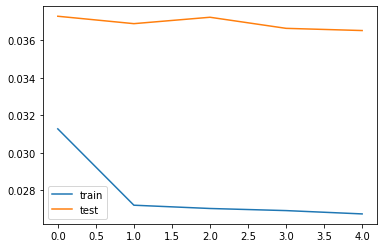

Calculating metrics
filename number 67
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.137297   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.106511   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.047417   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.011323   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.029724   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.106511  
2   0.403581   0.909091        1.0  0.047417  
3   0.414601   0.870130        1.0  0.011323  
4   0.414601   0.870130        1.0  0.029724  
5   0.362948   0.883117        1.0  0.020524  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0410 - val_loss

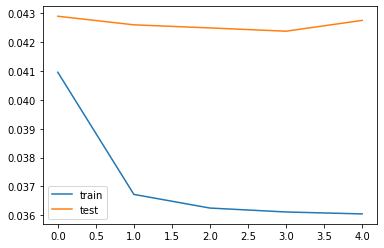

Calculating metrics
filename number 68
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.026367   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.018794   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.029173   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.019355   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.019635   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.018794  
2   0.403581   0.909091        1.0  0.029173  
3   0.414601   0.870130        1.0  0.019355  
4   0.414601   0.870130        1.0  0.019635  
5   0.362948   0.883117        1.0  0.004769  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0134 - val_loss

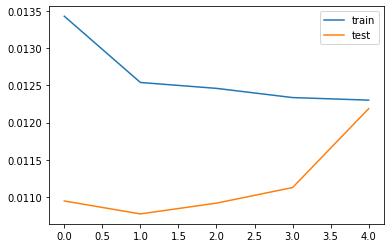

Calculating metrics
filename number 69
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.344498   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.009569   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.010048   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.025837   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.009569   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.009569  
2   0.403581   0.909091        1.0  0.010048  
3   0.414601   0.870130        1.0  0.025837  
4   0.414601   0.870130        1.0  0.009569  
5   0.362948   0.883117        1.0  0.014354  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0443 - val_loss

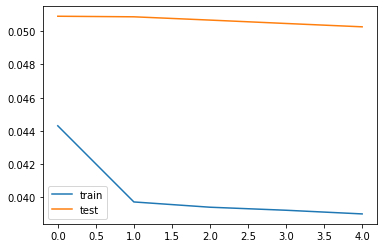

Calculating metrics
filename number 70
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.094886   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.049908   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.049291   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.051756   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.024030   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.049908  
2   0.403581   0.909091        1.0  0.049291  
3   0.414601   0.870130        1.0  0.051756  
4   0.414601   0.870130        1.0  0.024030  
5   0.362948   0.883117        1.0  0.024030  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 94us/step - loss: 0.0260 - val_loss

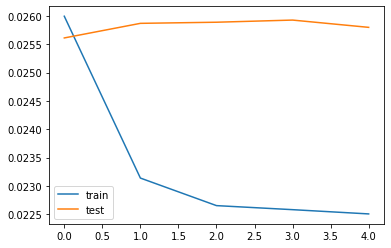

Calculating metrics
filename number 71
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.150743   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.148620   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.150743   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.148620   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.148620   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.148620  
2   0.403581   0.909091        1.0  0.150743  
3   0.414601   0.870130        1.0  0.148620  
4   0.414601   0.870130        1.0  0.148620  
5   0.362948   0.883117        1.0  0.148620  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0531 - val_loss

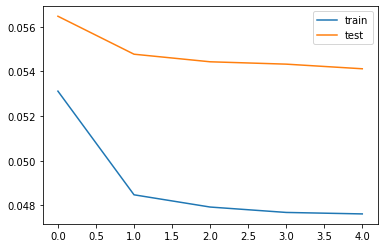

Calculating metrics
filename number 72
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.023941   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.033149   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.011050   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.019644   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.015961   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.033149  
2   0.403581   0.909091        1.0  0.011050  
3   0.414601   0.870130        1.0  0.019644  
4   0.414601   0.870130        1.0  0.015961  
5   0.362948   0.883117        1.0  0.011050  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0271 - val_loss

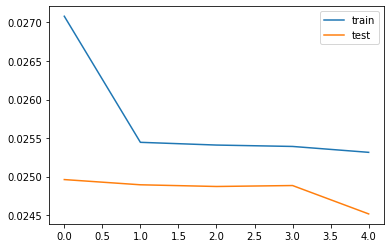

Calculating metrics
filename number 73
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.047085   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.017489   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.033184   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.009417   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.013453   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.017489  
2   0.403581   0.909091        1.0  0.033184  
3   0.414601   0.870130        1.0  0.009417  
4   0.414601   0.870130        1.0  0.013453  
5   0.362948   0.883117        1.0  0.014798  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0272 - val_loss

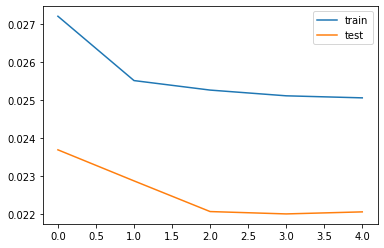

Calculating metrics
filename number 74
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008182   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.057273   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.050909   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.014545   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.004545   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.057273  
2   0.403581   0.909091        1.0  0.050909  
3   0.414601   0.870130        1.0  0.014545  
4   0.414601   0.870130        1.0  0.004545  
5   0.362948   0.883117        1.0  0.004545  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 76us/step - loss: 0.0322 - val_loss

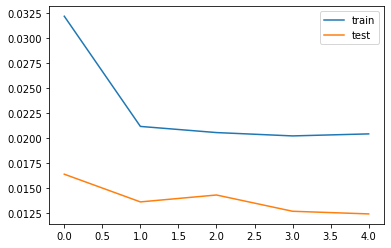

Calculating metrics
filename number 75
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.154567   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.149297   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.156909   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.156323   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.158080   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.149297  
2   0.403581   0.909091        1.0  0.156909  
3   0.414601   0.870130        1.0  0.156323  
4   0.414601   0.870130        1.0  0.158080  
5   0.362948   0.883117        1.0  0.137002  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 80us/step - loss: 0.0401 - val_loss

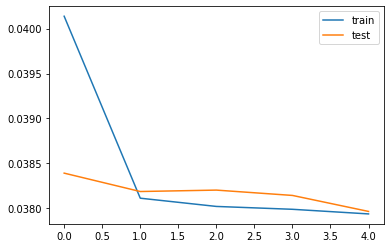

Calculating metrics
filename number 76
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.044011   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.040184   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.065059   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.050899   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.040566   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.040184  
2   0.403581   0.909091        1.0  0.065059  
3   0.414601   0.870130        1.0  0.050899  
4   0.414601   0.870130        1.0  0.040566  
5   0.362948   0.883117        1.0  0.054344  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 81us/step - loss: 0.0342 - val_loss

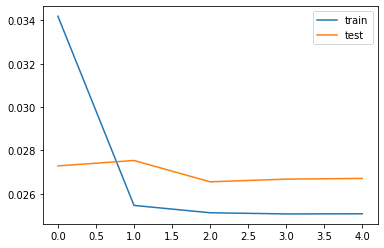

Calculating metrics
filename number 77
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.027999   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.158767   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.160957   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.153136   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.140779   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.158767  
2   0.403581   0.909091        1.0  0.160957  
3   0.414601   0.870130        1.0  0.153136  
4   0.414601   0.870130        1.0  0.140779  
5   0.362948   0.883117        1.0  0.138276  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0429 - val_loss

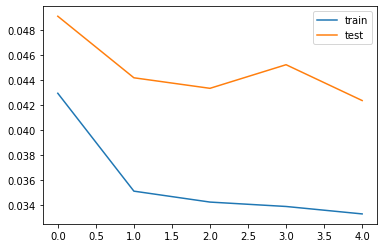

Calculating metrics
filename number 78
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.170660   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.205308   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.178032   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.105418   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.043494   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.205308  
2   0.403581   0.909091        1.0  0.178032  
3   0.414601   0.870130        1.0  0.105418  
4   0.414601   0.870130        1.0  0.043494  
5   0.362948   0.883117        1.0  0.034648  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 79us/step - loss: 0.0446 - val_loss

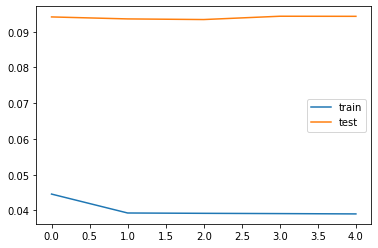

Calculating metrics
filename number 79
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.027580   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.027104   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.027104   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.008559   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.005231   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.027104  
2   0.403581   0.909091        1.0  0.027104  
3   0.414601   0.870130        1.0  0.008559  
4   0.414601   0.870130        1.0  0.005231  
5   0.362948   0.883117        1.0  0.005231  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 6s 188us/step - loss: 0.0184 - val_los

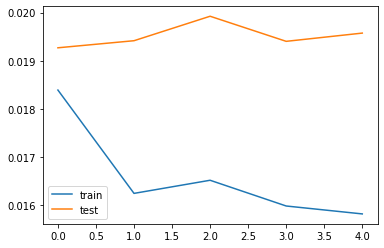

Calculating metrics
filename number 80
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.096328   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.093467   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.104912   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.105866   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.109680   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.093467  
2   0.403581   0.909091        1.0  0.104912  
3   0.414601   0.870130        1.0  0.105866  
4   0.414601   0.870130        1.0  0.109680  
5   0.362948   0.883117        1.0  0.111588  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 76us/step - loss: 0.0386 - val_loss

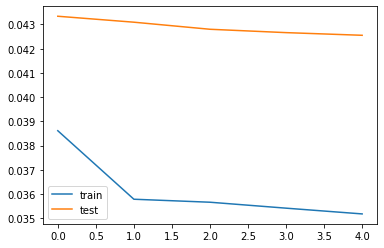

Calculating metrics
filename number 81
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.124664   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.146188   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.121973   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.128251   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.080717   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.146188  
2   0.403581   0.909091        1.0  0.121973  
3   0.414601   0.870130        1.0  0.128251  
4   0.414601   0.870130        1.0  0.080717  
5   0.362948   0.883117        1.0  0.121076  
Splitting into train and test
(33600, 1, 9) (33600,) (1447, 1, 9) (1447,)
Designing network
Fitting network
Train on 33600 samples, validate on 1447 samples
Epoch 1/5
33600/33600 [==============================] - 3s 76us/step - loss: 0.0380 - val_loss

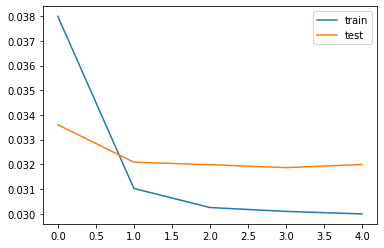

Calculating metrics
filename number 82
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.525979   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.360112   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.374101   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.378497   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.361311   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.360112  
2   0.403581   0.909091        1.0  0.374101  
3   0.414601   0.870130        1.0  0.378497  
4   0.414601   0.870130        1.0  0.361311  
5   0.362948   0.883117        1.0  0.377698  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 79us/step - loss: 0.0544 - val_loss

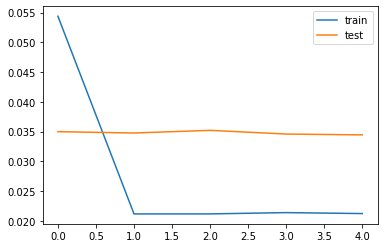

Calculating metrics
filename number 83
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.012695   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.016602   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.015625   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.006836   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.554688   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.016602  
2   0.403581   0.909091        1.0  0.015625  
3   0.414601   0.870130        1.0  0.006836  
4   0.414601   0.870130        1.0  0.554688  
5   0.362948   0.883117        1.0  0.406901  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 4s 112us/step - loss: 0.0636 - val_los

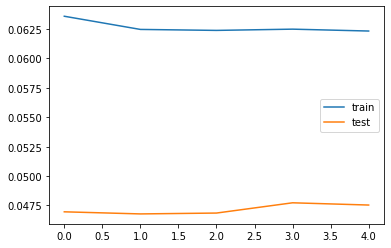

Calculating metrics
filename number 84
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.052824   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.057434   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.060699   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.060507   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.061083   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.057434  
2   0.403581   0.909091        1.0  0.060699  
3   0.414601   0.870130        1.0  0.060507  
4   0.414601   0.870130        1.0  0.061083  
5   0.362948   0.883117        1.0  0.060123  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 80us/step - loss: 0.0423 - val_loss

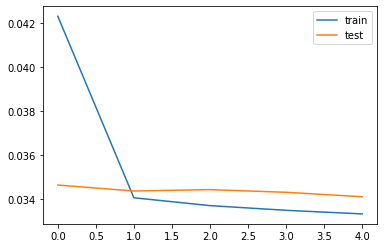

Calculating metrics
filename number 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.041575   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.042670   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.050328   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.051422   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.047046   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.042670  
2   0.403581   0.909091        1.0  0.050328  
3   0.414601   0.870130        1.0  0.051422  
4   0.414601   0.870130        1.0  0.047046  
5   0.362948   0.883117        1.0  0.042670  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 74us/step - loss: 0.0351 - val_loss

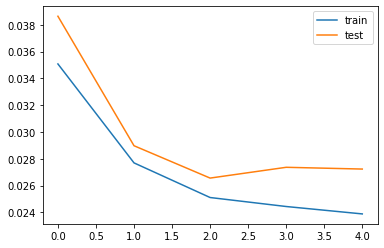

Calculating metrics
filename number 86
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.348600   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.348600   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.351145   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.353690   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.351145   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.348600  
2   0.403581   0.909091        1.0  0.351145  
3   0.414601   0.870130        1.0  0.353690  
4   0.414601   0.870130        1.0  0.351145  
5   0.362948   0.883117        1.0  0.353690  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 74us/step - loss: 0.0670 - val_loss

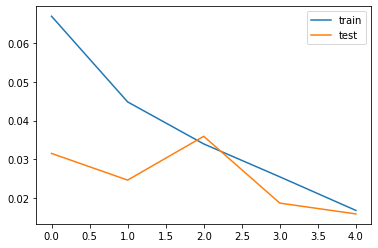

Calculating metrics
filename number 87
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.090745   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.100541   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.089198   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.079660   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.054911   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.100541  
2   0.403581   0.909091        1.0  0.089198  
3   0.414601   0.870130        1.0  0.079660  
4   0.414601   0.870130        1.0  0.054911  
5   0.362948   0.883117        1.0  0.053622  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0531 - val_loss

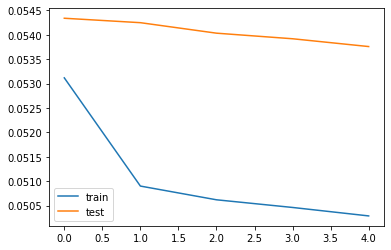

Calculating metrics
filename number 88
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.017737   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.020220   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.006740   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.010642   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.000709   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.020220  
2   0.403581   0.909091        1.0  0.006740  
3   0.414601   0.870130        1.0  0.010642  
4   0.414601   0.870130        1.0  0.000709  
5   0.362948   0.883117        1.0  0.009933  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0299 - val_loss

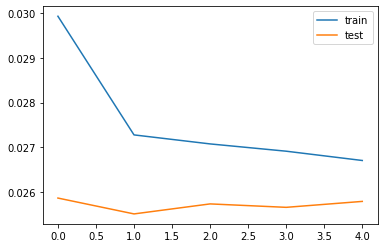

Calculating metrics
filename number 89
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.062662   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.059364   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.058186   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.056537   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.085041   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.059364  
2   0.403581   0.909091        1.0  0.058186  
3   0.414601   0.870130        1.0  0.056537  
4   0.414601   0.870130        1.0  0.085041  
5   0.362948   0.883117        1.0  0.055359  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0281 - val_loss

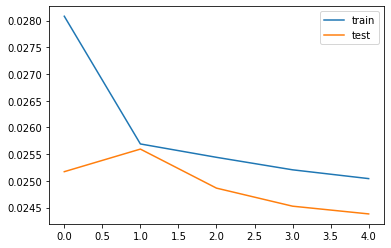

Calculating metrics
filename number 90
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.095771   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.072554   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.077529   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.095771   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.067993   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.072554  
2   0.403581   0.909091        1.0  0.077529  
3   0.414601   0.870130        1.0  0.095771  
4   0.414601   0.870130        1.0  0.067993  
5   0.362948   0.883117        1.0  0.090796  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0243 - val_loss

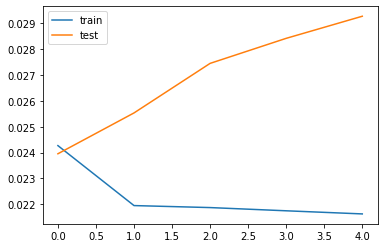

Calculating metrics
filename number 91
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.006260   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.033646   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.006260   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.008607   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.029734   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.033646  
2   0.403581   0.909091        1.0  0.006260  
3   0.414601   0.870130        1.0  0.008607  
4   0.414601   0.870130        1.0  0.029734  
5   0.362948   0.883117        1.0  0.008607  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0253 - val_loss

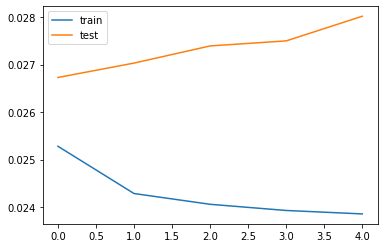

Calculating metrics
filename number 92
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.023513   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.021669   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.037344   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.038266   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.033656   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.021669  
2   0.403581   0.909091        1.0  0.037344  
3   0.414601   0.870130        1.0  0.038266  
4   0.414601   0.870130        1.0  0.033656  
5   0.362948   0.883117        1.0  0.023052  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0531 - val_loss

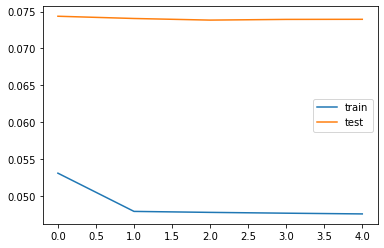

Calculating metrics
filename number 93
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.018209   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.012140   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.044006   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.024279   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.012140   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.012140  
2   0.403581   0.909091        1.0  0.044006  
3   0.414601   0.870130        1.0  0.024279  
4   0.414601   0.870130        1.0  0.012140  
5   0.362948   0.883117        1.0  0.039454  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0377 - val_loss

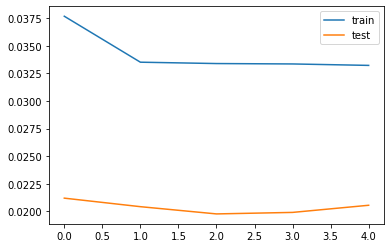

Calculating metrics
filename number 94
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.054897   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.053026   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.010917   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.051466   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.010917   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.053026  
2   0.403581   0.909091        1.0  0.010917  
3   0.414601   0.870130        1.0  0.051466  
4   0.414601   0.870130        1.0  0.010917  
5   0.362948   0.883117        1.0  0.055521  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 74us/step - loss: 0.0463 - val_loss

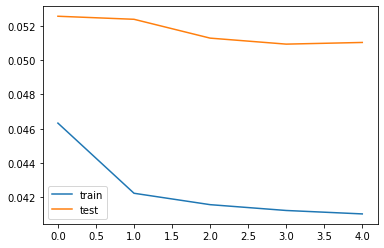

Calculating metrics
filename number 95
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.073309   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.089313   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.090862   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.047496   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020650   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.089313  
2   0.403581   0.909091        1.0  0.090862  
3   0.414601   0.870130        1.0  0.047496  
4   0.414601   0.870130        1.0  0.020650  
5   0.362948   0.883117        1.0  0.008776  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 84us/step - loss: 0.0395 - val_loss

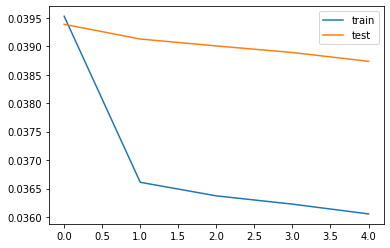

Calculating metrics
filename number 96
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.138031   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.149614   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.131757   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.134653   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.098456   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.149614  
2   0.403581   0.909091        1.0  0.131757  
3   0.414601   0.870130        1.0  0.134653  
4   0.414601   0.870130        1.0  0.098456  
5   0.362948   0.883117        1.0  0.039093  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 79us/step - loss: 0.0330 - val_loss

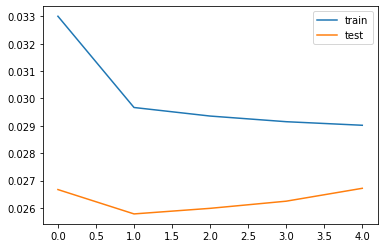

Calculating metrics
filename number 97
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.073728   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.092627   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.070229   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.078395   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.063229   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.092627  
2   0.403581   0.909091        1.0  0.070229  
3   0.414601   0.870130        1.0  0.078395  
4   0.414601   0.870130        1.0  0.063229  
5   0.362948   0.883117        1.0  0.062063  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 73us/step - loss: 0.0327 - val_loss

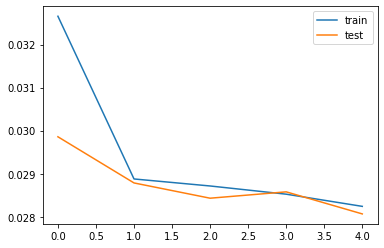

Calculating metrics
filename number 98
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.004786   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.004418   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.006996   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.023196   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.004786   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.004418  
2   0.403581   0.909091        1.0  0.006996  
3   0.414601   0.870130        1.0  0.023196  
4   0.414601   0.870130        1.0  0.004786  
5   0.362948   0.883117        1.0  0.004418  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0228 - val_loss

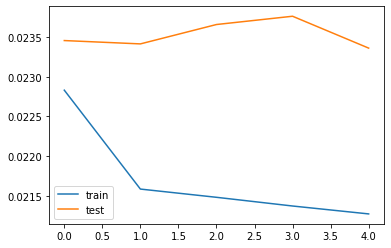

Calculating metrics
filename number 99
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.189132   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.137615   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.105857   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.064926   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.064220   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.137615  
2   0.403581   0.909091        1.0  0.105857  
3   0.414601   0.870130        1.0  0.064926  
4   0.414601   0.870130        1.0  0.064220  
5   0.362948   0.883117        1.0  0.043049  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 84us/step - loss: 0.0553 - val_loss

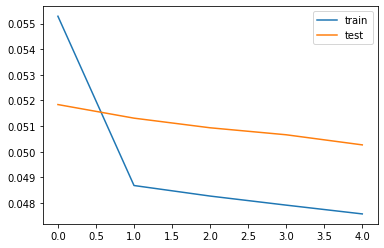

Calculating metrics
filename number 100
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.025494   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.024857   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.024857   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.024857   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.022945   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.024857  
2   0.403581   0.909091        1.0  0.024857  
3   0.414601   0.870130        1.0  0.024857  
4   0.414601   0.870130        1.0  0.022945  
5   0.362948   0.883117        1.0  0.031230  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0483 - val_los

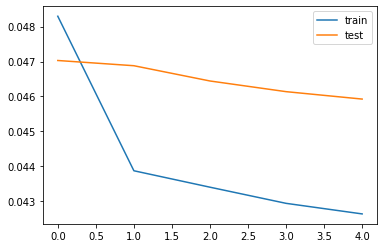

Calculating metrics
filename number 101
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.061490   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.062533   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.059406   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.055237   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.046378   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.062533  
2   0.403581   0.909091        1.0  0.059406  
3   0.414601   0.870130        1.0  0.055237  
4   0.414601   0.870130        1.0  0.046378  
5   0.362948   0.883117        1.0  0.031787  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0535 - val_los

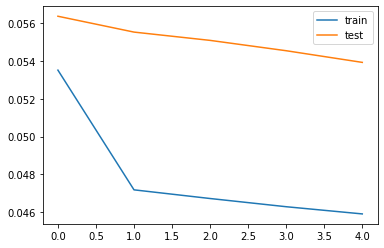

Calculating metrics
filename number 102
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.012338   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.000617   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.011721   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.001234   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.012338  
2   0.403581   0.909091        1.0  0.000617  
3   0.414601   0.870130        1.0  0.011721  
4   0.414601   0.870130        1.0  0.001234  
5   0.362948   0.883117        1.0  0.009870  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0197 - val_los

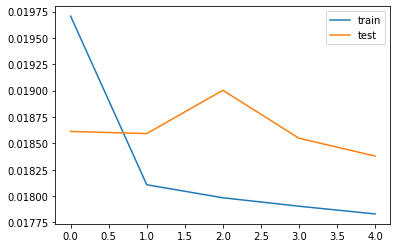

Calculating metrics
filename number 103
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.019969   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.023810   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.000768   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.000768   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.001536   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.023810  
2   0.403581   0.909091        1.0  0.000768  
3   0.414601   0.870130        1.0  0.000768  
4   0.414601   0.870130        1.0  0.001536  
5   0.362948   0.883117        1.0  0.006912  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0375 - val_los

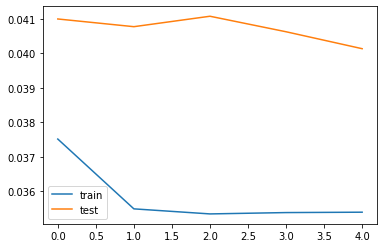

Calculating metrics
filename number 104
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.019905   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.061013   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.029857   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.012116   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.011683   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.061013  
2   0.403581   0.909091        1.0  0.029857  
3   0.414601   0.870130        1.0  0.012116  
4   0.414601   0.870130        1.0  0.011683  
5   0.362948   0.883117        1.0  0.029424  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0277 - val_los

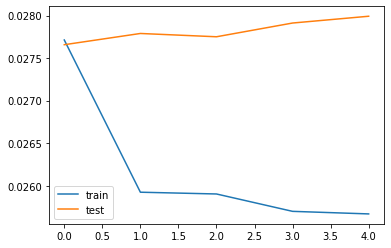

Calculating metrics
filename number 105
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.058091   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.045643   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.016598   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.016598   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.017059   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.045643  
2   0.403581   0.909091        1.0  0.016598  
3   0.414601   0.870130        1.0  0.016598  
4   0.414601   0.870130        1.0  0.017059  
5   0.362948   0.883117        1.0  0.016136  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0223 - val_los

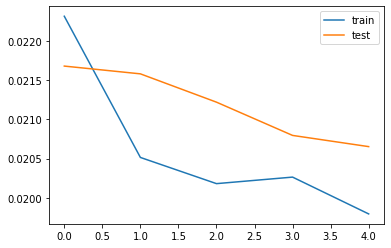

Calculating metrics
filename number 106
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.034693   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.031649   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.031041   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.057517   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.051430   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.031649  
2   0.403581   0.909091        1.0  0.031041  
3   0.414601   0.870130        1.0  0.057517  
4   0.414601   0.870130        1.0  0.051430  
5   0.362948   0.883117        1.0  0.039257  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 5s 163us/step - loss: 0.0331 - val_lo

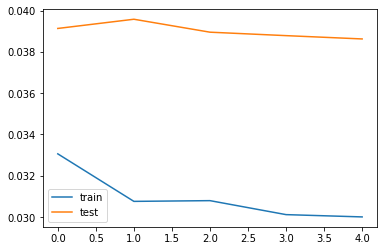

Calculating metrics
filename number 107
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.149047   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.174177   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.142981   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.163778   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.116984   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.174177  
2   0.403581   0.909091        1.0  0.142981  
3   0.414601   0.870130        1.0  0.163778  
4   0.414601   0.870130        1.0  0.116984  
5   0.362948   0.883117        1.0  0.136915  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 6s 179us/step - loss: 0.0381 - val_lo

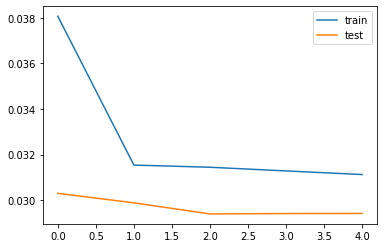

Calculating metrics
filename number 108
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.078140   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.050445   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.057369   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.025223   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.015826   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.050445  
2   0.403581   0.909091        1.0  0.057369  
3   0.414601   0.870130        1.0  0.025223  
4   0.414601   0.870130        1.0  0.015826  
5   0.362948   0.883117        1.0  0.018299  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 6s 166us/step - loss: 0.0470 - val_lo

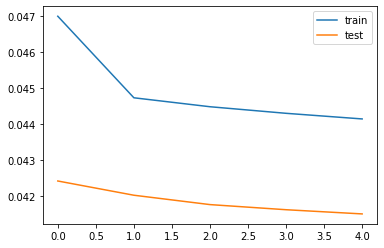

Calculating metrics
filename number 109
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.057596   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.413165   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.415222   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.413753   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.414046   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.413165  
2   0.403581   0.909091        1.0  0.415222  
3   0.414601   0.870130        1.0  0.413753  
4   0.414601   0.870130        1.0  0.414046  
5   0.362948   0.883117        1.0  0.409932  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 6s 172us/step - loss: 0.0607 - val_lo

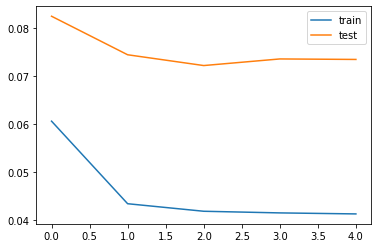

Calculating metrics
filename number 110
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.081736   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.058527   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.073663   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.076690   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.070636   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.058527  
2   0.403581   0.909091        1.0  0.073663  
3   0.414601   0.870130        1.0  0.076690  
4   0.414601   0.870130        1.0  0.070636  
5   0.362948   0.883117        1.0  0.042381  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0459 - val_los

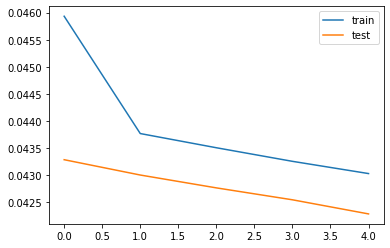

Calculating metrics
filename number 111
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.027004   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.026353   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.025919   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.027763   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.024075   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.026353  
2   0.403581   0.909091        1.0  0.025919  
3   0.414601   0.870130        1.0  0.027763  
4   0.414601   0.870130        1.0  0.024075  
5   0.362948   0.883117        1.0  0.013881  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0132 - val_los

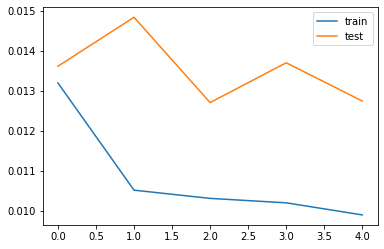

Calculating metrics
filename number 112
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.024380   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.043199   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.046193   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.046193   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.046193   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.043199  
2   0.403581   0.909091        1.0  0.046193  
3   0.414601   0.870130        1.0  0.046193  
4   0.414601   0.870130        1.0  0.046193  
5   0.362948   0.883117        1.0  0.046193  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 82us/step - loss: 0.0350 - val_los

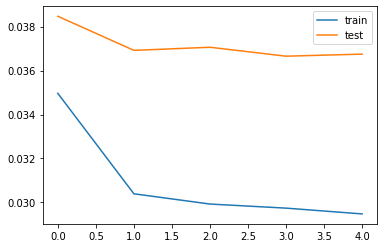

Calculating metrics
filename number 113
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064494   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.067961   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.039875   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.030166   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.039528   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.067961  
2   0.403581   0.909091        1.0  0.039875  
3   0.414601   0.870130        1.0  0.030166  
4   0.414601   0.870130        1.0  0.039528  
5   0.362948   0.883117        1.0  0.039528  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0456 - val_los

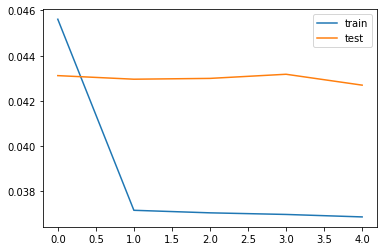

Calculating metrics
filename number 114
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.038927   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.064177   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.061547   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.087322   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.075224   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.064177  
2   0.403581   0.909091        1.0  0.061547  
3   0.414601   0.870130        1.0  0.087322  
4   0.414601   0.870130        1.0  0.075224  
5   0.362948   0.883117        1.0  0.013151  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 95us/step - loss: 0.0323 - val_los

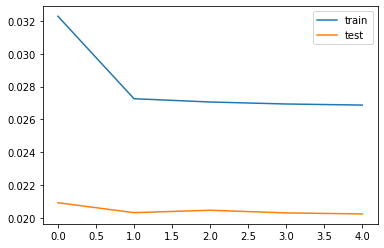

Calculating metrics
filename number 115
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.013084   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.016822   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.004361   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.018692   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.012461   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.016822  
2   0.403581   0.909091        1.0  0.004361  
3   0.414601   0.870130        1.0  0.018692  
4   0.414601   0.870130        1.0  0.012461  
5   0.362948   0.883117        1.0  0.013707  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0281 - val_los

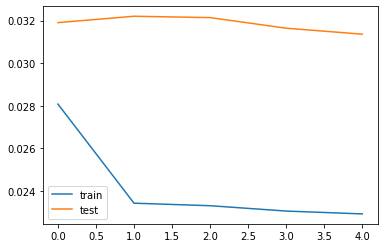

Calculating metrics
filename number 116
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.030153   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.019802   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.053555   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.032403   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.046805   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.019802  
2   0.403581   0.909091        1.0  0.053555  
3   0.414601   0.870130        1.0  0.032403  
4   0.414601   0.870130        1.0  0.046805  
5   0.362948   0.883117        1.0  0.012151  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0326 - val_los

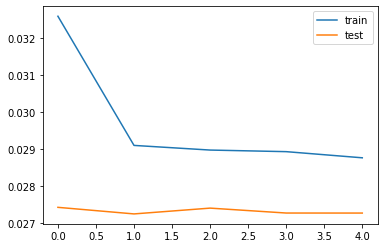

Calculating metrics
filename number 117
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.165146   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.114964   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.270985   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.125912   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020985   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.114964  
2   0.403581   0.909091        1.0  0.270985  
3   0.414601   0.870130        1.0  0.125912  
4   0.414601   0.870130        1.0  0.020985  
5   0.362948   0.883117        1.0  0.020073  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0524 - val_los

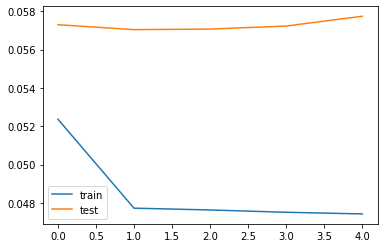

Calculating metrics
filename number 118
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.004092   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.003581   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.003581   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.003581   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.004092   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.003581  
2   0.403581   0.909091        1.0  0.003581  
3   0.414601   0.870130        1.0  0.003581  
4   0.414601   0.870130        1.0  0.004092  
5   0.362948   0.883117        1.0  0.003581  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0291 - val_los

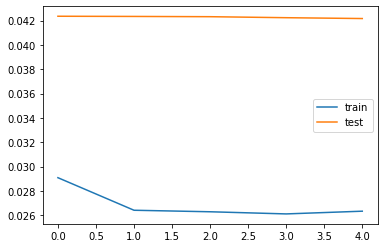

Calculating metrics
filename number 119
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.005995   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.029973   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.007084   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.027248   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.011444   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.029973  
2   0.403581   0.909091        1.0  0.007084  
3   0.414601   0.870130        1.0  0.027248  
4   0.414601   0.870130        1.0  0.011444  
5   0.362948   0.883117        1.0  0.022343  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0275 - val_los

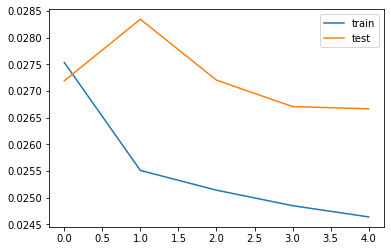

Calculating metrics
filename number 120
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.094631   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.071277   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.075827   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.060965   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.037913   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.071277  
2   0.403581   0.909091        1.0  0.075827  
3   0.414601   0.870130        1.0  0.060965  
4   0.414601   0.870130        1.0  0.037913  
5   0.362948   0.883117        1.0  0.037307  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0428 - val_los

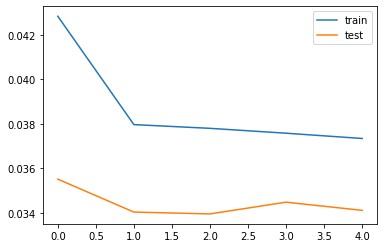

Calculating metrics
filename number 121
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.016551   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.004447   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.004200   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.017292   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.004447   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.004447  
2   0.403581   0.909091        1.0  0.004200  
3   0.414601   0.870130        1.0  0.017292  
4   0.414601   0.870130        1.0  0.004447  
5   0.362948   0.883117        1.0  0.004200  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0359 - val_los

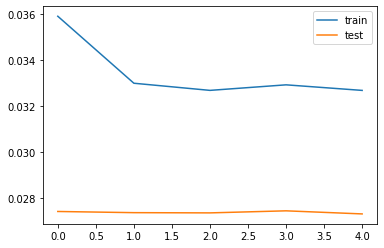

Calculating metrics
filename number 122
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.121107   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.143945   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.114879   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.088581   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.186159   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.143945  
2   0.403581   0.909091        1.0  0.114879  
3   0.414601   0.870130        1.0  0.088581  
4   0.414601   0.870130        1.0  0.186159  
5   0.362948   0.883117        1.0  0.127336  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0373 - val_los

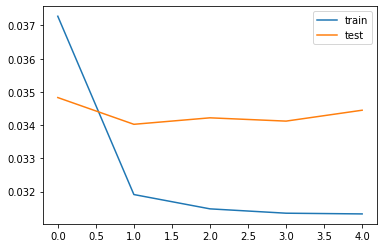

Calculating metrics
filename number 123
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.117247   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.204992   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.197428   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.126324   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.069592   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.204992  
2   0.403581   0.909091        1.0  0.197428  
3   0.414601   0.870130        1.0  0.126324  
4   0.414601   0.870130        1.0  0.069592  
5   0.362948   0.883117        1.0  0.077912  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0499 - val_los

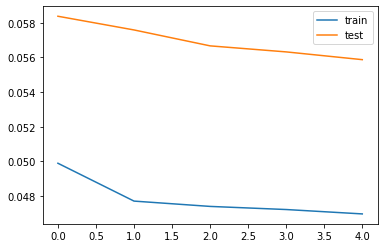

Calculating metrics
filename number 124
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.039545   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.040398   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.034139   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.036415   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.152774   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.040398  
2   0.403581   0.909091        1.0  0.034139  
3   0.414601   0.870130        1.0  0.036415  
4   0.414601   0.870130        1.0  0.152774  
5   0.362948   0.883117        1.0  0.016501  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0340 - val_los

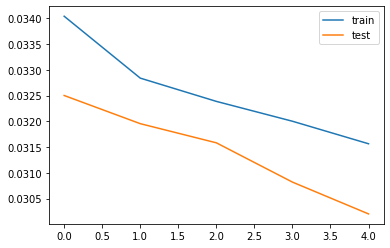

Calculating metrics
filename number 125
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.096743   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.078544   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.082375   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.089080   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.045019   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.078544  
2   0.403581   0.909091        1.0  0.082375  
3   0.414601   0.870130        1.0  0.089080  
4   0.414601   0.870130        1.0  0.045019  
5   0.362948   0.883117        1.0  0.027299  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0403 - val_los

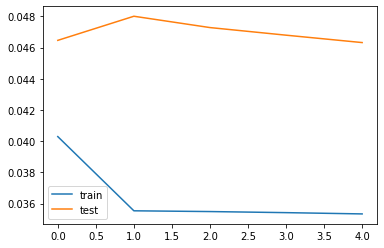

Calculating metrics
filename number 126
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.098945   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.067805   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.014063   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.016072   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.015068   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.067805  
2   0.403581   0.909091        1.0  0.014063  
3   0.414601   0.870130        1.0  0.016072  
4   0.414601   0.870130        1.0  0.015068  
5   0.362948   0.883117        1.0  0.012054  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0255 - val_los

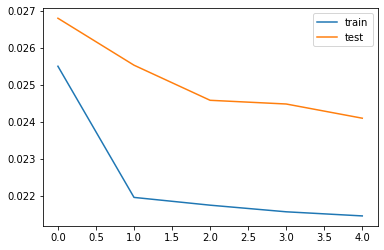

Calculating metrics
filename number 127
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.142646   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.076127   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.005174   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.021434   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.036216   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.076127  
2   0.403581   0.909091        1.0  0.005174  
3   0.414601   0.870130        1.0  0.021434  
4   0.414601   0.870130        1.0  0.036216  
5   0.362948   0.883117        1.0  0.021434  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0425 - val_los

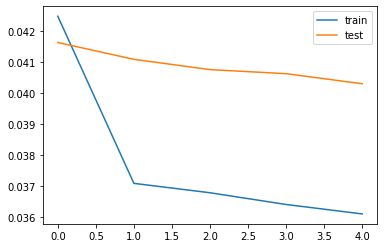

Calculating metrics
filename number 128
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.063445   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.035907   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.033207   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.043736   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.036987   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.035907  
2   0.403581   0.909091        1.0  0.033207  
3   0.414601   0.870130        1.0  0.043736  
4   0.414601   0.870130        1.0  0.036987  
5   0.362948   0.883117        1.0  0.033747  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 85us/step - loss: 0.0189 - val_los

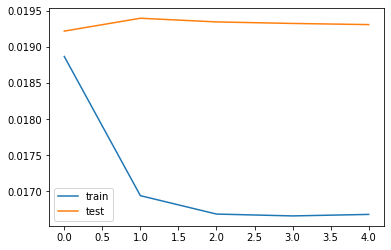

Calculating metrics
filename number 129
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.031144   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.046039   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.036561   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.053487   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.067705   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.046039  
2   0.403581   0.909091        1.0  0.036561  
3   0.414601   0.870130        1.0  0.053487  
4   0.414601   0.870130        1.0  0.067705  
5   0.362948   0.883117        1.0  0.074475  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0244 - val_los

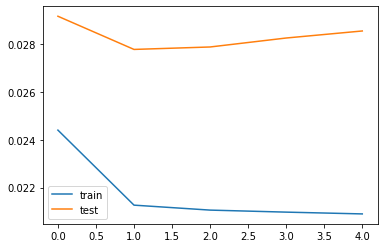

Calculating metrics
filename number 130
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.034228   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.034228   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.034899   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.034228   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.034899   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.034228  
2   0.403581   0.909091        1.0  0.034899  
3   0.414601   0.870130        1.0  0.034228  
4   0.414601   0.870130        1.0  0.034899  
5   0.362948   0.883117        1.0  0.034228  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0273 - val_los

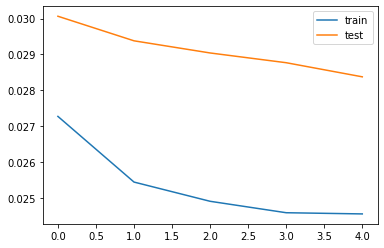

Calculating metrics
filename number 131
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.095645   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.084759   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.059487   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.068040   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.073484   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.084759  
2   0.403581   0.909091        1.0  0.059487  
3   0.414601   0.870130        1.0  0.068040  
4   0.414601   0.870130        1.0  0.073484  
5   0.362948   0.883117        1.0  0.027605  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 72us/step - loss: 0.0377 - val_los

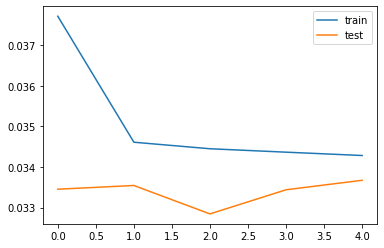

Calculating metrics
filename number 132
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.167411   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.168750   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.166518   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.144196   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.066964   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.168750  
2   0.403581   0.909091        1.0  0.166518  
3   0.414601   0.870130        1.0  0.144196  
4   0.414601   0.870130        1.0  0.066964  
5   0.362948   0.883117        1.0  0.026786  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0366 - val_los

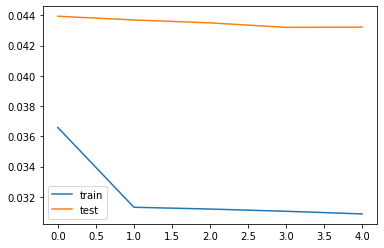

Calculating metrics
filename number 133
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.057799   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.031337   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.019499   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.025766   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.016713   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.031337  
2   0.403581   0.909091        1.0  0.019499  
3   0.414601   0.870130        1.0  0.025766  
4   0.414601   0.870130        1.0  0.016713  
5   0.362948   0.883117        1.0  0.032730  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0391 - val_los

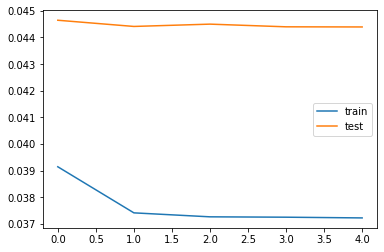

Calculating metrics
filename number 134
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064943   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.064297   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.030048   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.027141   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.005816   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.064297  
2   0.403581   0.909091        1.0  0.030048  
3   0.414601   0.870130        1.0  0.027141  
4   0.414601   0.870130        1.0  0.005816  
5   0.362948   0.883117        1.0  0.001616  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0288 - val_los

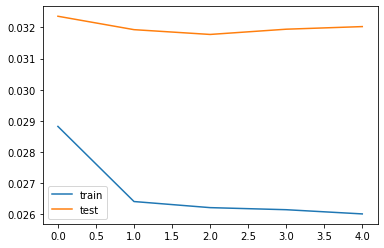

Calculating metrics
filename number 135
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.051041   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.061447   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.107037   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.091675   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.059960   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.061447  
2   0.403581   0.909091        1.0  0.107037  
3   0.414601   0.870130        1.0  0.091675  
4   0.414601   0.870130        1.0  0.059960  
5   0.362948   0.883117        1.0  0.123885  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0425 - val_los

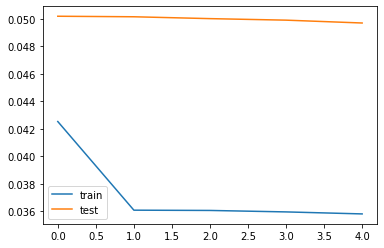

Calculating metrics
filename number 136
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.051475   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.050164   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.049508   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.031148   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.018689   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.050164  
2   0.403581   0.909091        1.0  0.049508  
3   0.414601   0.870130        1.0  0.031148  
4   0.414601   0.870130        1.0  0.018689  
5   0.362948   0.883117        1.0  0.010820  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0420 - val_los

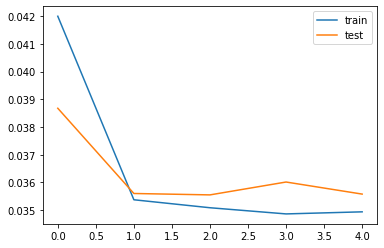

Calculating metrics
filename number 137
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.185067   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.210133   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.190933   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.202667   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.241600   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.210133  
2   0.403581   0.909091        1.0  0.190933  
3   0.414601   0.870130        1.0  0.202667  
4   0.414601   0.870130        1.0  0.241600  
5   0.362948   0.883117        1.0  0.317867  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0527 - val_los

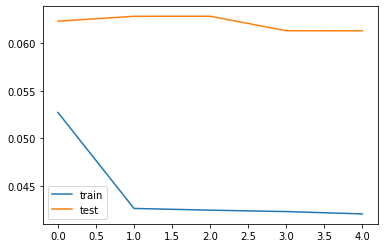

Calculating metrics
filename number 138
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.519868   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.344973   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.214028   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.285972   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.158639   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.344973  
2   0.403581   0.909091        1.0  0.214028  
3   0.414601   0.870130        1.0  0.285972  
4   0.414601   0.870130        1.0  0.158639  
5   0.362948   0.883117        1.0  0.068332  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0802 - val_los

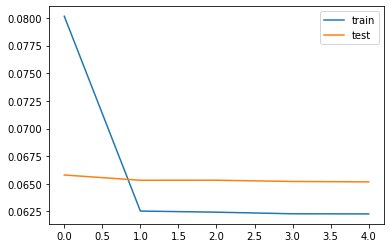

Calculating metrics
filename number 139
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.027575   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.015757   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.028700   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.007316   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.010692   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.015757  
2   0.403581   0.909091        1.0  0.028700  
3   0.414601   0.870130        1.0  0.007316  
4   0.414601   0.870130        1.0  0.010692  
5   0.362948   0.883117        1.0  0.003939  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 91us/step - loss: 0.0260 - val_los

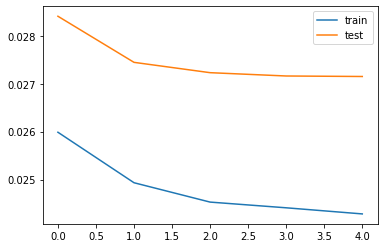

Calculating metrics
filename number 140
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.118306   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.108155   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.049352   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.054953   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.054603   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.108155  
2   0.403581   0.909091        1.0  0.049352  
3   0.414601   0.870130        1.0  0.054953  
4   0.414601   0.870130        1.0  0.054603  
5   0.362948   0.883117        1.0  0.039902  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0359 - val_los

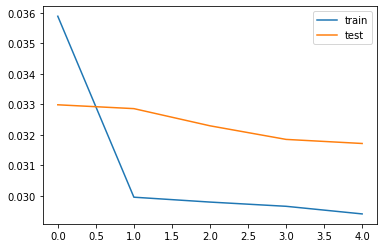

Calculating metrics
filename number 141
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.147385   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.150555   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.112916   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.112124   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.256339   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.150555  
2   0.403581   0.909091        1.0  0.112916  
3   0.414601   0.870130        1.0  0.112124  
4   0.414601   0.870130        1.0  0.256339  
5   0.362948   0.883117        1.0  0.204041  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 73us/step - loss: 0.0529 - val_los

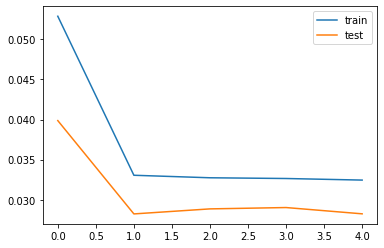

Calculating metrics
filename number 142
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.193874   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.160721   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.125766   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.159640   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.179820   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.160721  
2   0.403581   0.909091        1.0  0.125766  
3   0.414601   0.870130        1.0  0.159640  
4   0.414601   0.870130        1.0  0.179820  
5   0.362948   0.883117        1.0  0.176577  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0377 - val_los

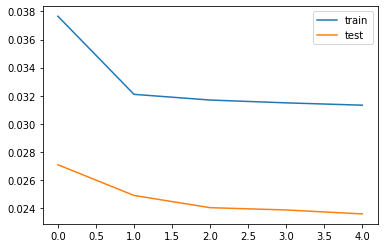

Calculating metrics
filename number 143
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.118604   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.111505   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.090802   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.081928   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.094647   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.111505  
2   0.403581   0.909091        1.0  0.090802  
3   0.414601   0.870130        1.0  0.081928  
4   0.414601   0.870130        1.0  0.094647  
5   0.362948   0.883117        1.0  0.092872  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0512 - val_los

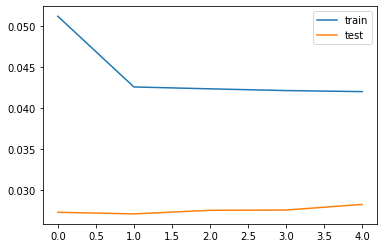

Calculating metrics
filename number 144
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064290   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.056015   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.060789   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.069383   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.066836   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.056015  
2   0.403581   0.909091        1.0  0.060789  
3   0.414601   0.870130        1.0  0.069383  
4   0.414601   0.870130        1.0  0.066836  
5   0.362948   0.883117        1.0  0.033100  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0337 - val_los

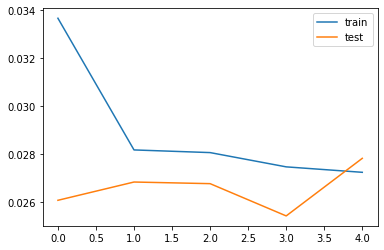

Calculating metrics
filename number 145
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.040575   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.048183   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.162722   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.065511   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.034235   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.048183  
2   0.403581   0.909091        1.0  0.162722  
3   0.414601   0.870130        1.0  0.065511  
4   0.414601   0.870130        1.0  0.034235  
5   0.362948   0.883117        1.0  0.041843  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0154 - val_los

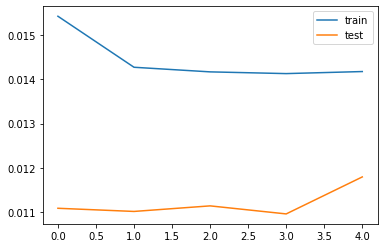

Calculating metrics
filename number 146
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.102847   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.093923   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.027624   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.014875   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.016150   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.093923  
2   0.403581   0.909091        1.0  0.027624  
3   0.414601   0.870130        1.0  0.014875  
4   0.414601   0.870130        1.0  0.016150  
5   0.362948   0.883117        1.0  0.015725  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 79us/step - loss: 0.0396 - val_los

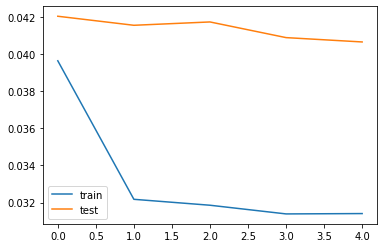

Calculating metrics
filename number 147
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.087313   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.102637   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.090164   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.085531   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.045617   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.102637  
2   0.403581   0.909091        1.0  0.090164  
3   0.414601   0.870130        1.0  0.085531  
4   0.414601   0.870130        1.0  0.045617  
5   0.362948   0.883117        1.0  0.020314  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 76us/step - loss: 0.0354 - val_los

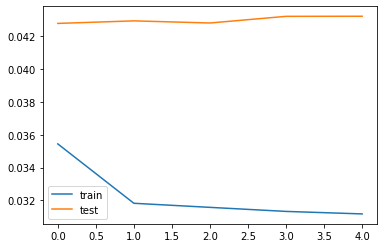

Calculating metrics
filename number 148
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.239437   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.246479   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.221127   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.240845   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.270423   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.246479  
2   0.403581   0.909091        1.0  0.221127  
3   0.414601   0.870130        1.0  0.240845  
4   0.414601   0.870130        1.0  0.270423  
5   0.362948   0.883117        1.0  0.233803  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0610 - val_los

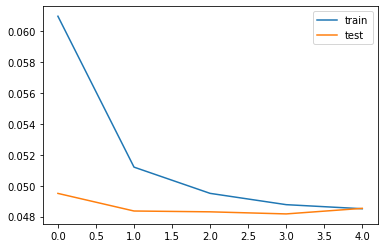

Calculating metrics
filename number 149
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.174536   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.140671   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.134810   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.117551   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.091827   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.140671  
2   0.403581   0.909091        1.0  0.134810  
3   0.414601   0.870130        1.0  0.117551  
4   0.414601   0.870130        1.0  0.091827  
5   0.362948   0.883117        1.0  0.055682  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0479 - val_los

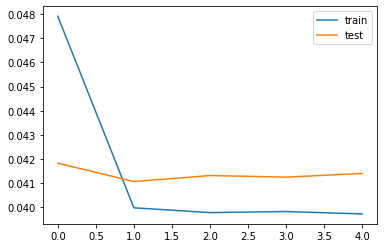

Calculating metrics
filename number 150
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.024492   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.032830   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.034914   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.016675   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.011464   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.032830  
2   0.403581   0.909091        1.0  0.034914  
3   0.414601   0.870130        1.0  0.016675  
4   0.414601   0.870130        1.0  0.011464  
5   0.362948   0.883117        1.0  0.016675  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0467 - val_los

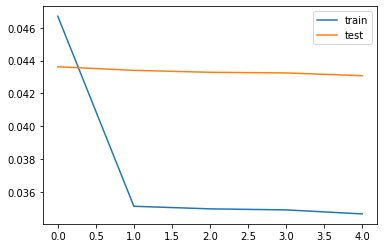

Calculating metrics
filename number 151
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.043331   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.016579   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.024115   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.024868   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.016579   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.016579  
2   0.403581   0.909091        1.0  0.024115  
3   0.414601   0.870130        1.0  0.024868  
4   0.414601   0.870130        1.0  0.016579  
5   0.362948   0.883117        1.0  0.029766  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0357 - val_los

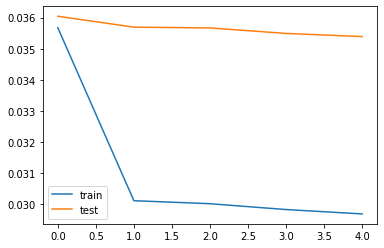

Calculating metrics
filename number 152
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.025506   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.033861   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.022867   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.020668   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.036060   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.033861  
2   0.403581   0.909091        1.0  0.022867  
3   0.414601   0.870130        1.0  0.020668  
4   0.414601   0.870130        1.0  0.036060  
5   0.362948   0.883117        1.0  0.030783  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0402 - val_los

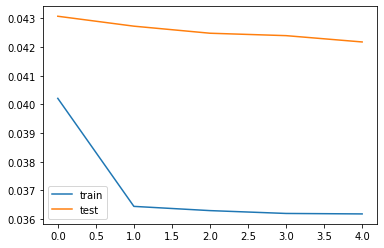

Calculating metrics
filename number 153
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.298759   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.287234   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.298759   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.298759   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.277482   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.287234  
2   0.403581   0.909091        1.0  0.298759  
3   0.414601   0.870130        1.0  0.298759  
4   0.414601   0.870130        1.0  0.277482  
5   0.362948   0.883117        1.0  0.231383  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0387 - val_los

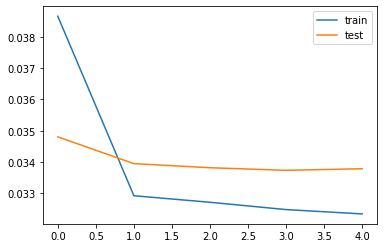

Calculating metrics
filename number 154
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.111232   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.103962   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.107597   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.097419   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.111596   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.103962  
2   0.403581   0.909091        1.0  0.107597  
3   0.414601   0.870130        1.0  0.097419  
4   0.414601   0.870130        1.0  0.111596  
5   0.362948   0.883117        1.0  0.112686  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 87us/step - loss: 0.0491 - val_los

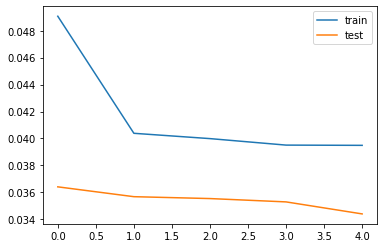

Calculating metrics
filename number 155
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.045176   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.024471   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.027765   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.016471   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020706   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.024471  
2   0.403581   0.909091        1.0  0.027765  
3   0.414601   0.870130        1.0  0.016471  
4   0.414601   0.870130        1.0  0.020706  
5   0.362948   0.883117        1.0  0.023059  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0373 - val_los

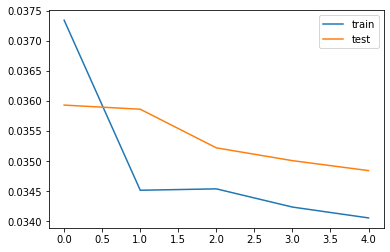

Calculating metrics
filename number 156
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.005504   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.004953   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.000550   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.004953   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.004953   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.004953  
2   0.403581   0.909091        1.0  0.000550  
3   0.414601   0.870130        1.0  0.004953  
4   0.414601   0.870130        1.0  0.004953  
5   0.362948   0.883117        1.0  0.004953  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0221 - val_los

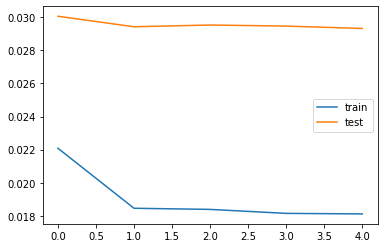

Calculating metrics
filename number 157
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.030063   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.032626   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.037753   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.031461   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.022838   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.032626  
2   0.403581   0.909091        1.0  0.037753  
3   0.414601   0.870130        1.0  0.031461  
4   0.414601   0.870130        1.0  0.022838  
5   0.362948   0.883117        1.0  0.017012  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0141 - val_los

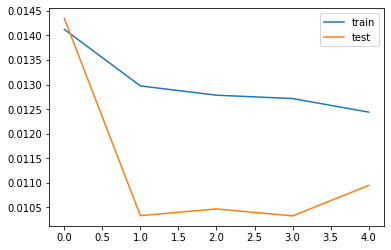

Calculating metrics
filename number 158
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.134441   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.136707   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.143505   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.148792   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.133686   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.136707  
2   0.403581   0.909091        1.0  0.143505  
3   0.414601   0.870130        1.0  0.148792  
4   0.414601   0.870130        1.0  0.133686  
5   0.362948   0.883117        1.0  0.043807  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0525 - val_los

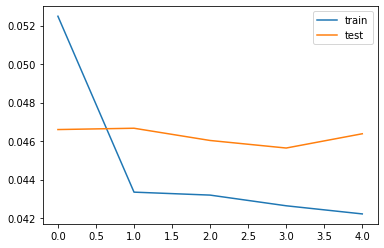

Calculating metrics
filename number 159
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.019380   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.005665   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.012522   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.087060   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.305009   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.005665  
2   0.403581   0.909091        1.0  0.012522  
3   0.414601   0.870130        1.0  0.087060  
4   0.414601   0.870130        1.0  0.305009  
5   0.362948   0.883117        1.0  0.109720  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0483 - val_los

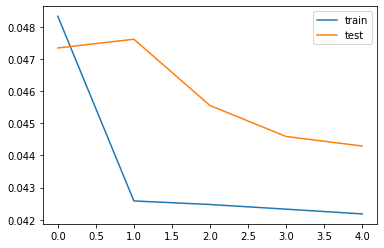

Calculating metrics
filename number 160
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.304938   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.215432   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.212346   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.216049   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.202469   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.215432  
2   0.403581   0.909091        1.0  0.212346  
3   0.414601   0.870130        1.0  0.216049  
4   0.414601   0.870130        1.0  0.202469  
5   0.362948   0.883117        1.0  0.222222  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0506 - val_los

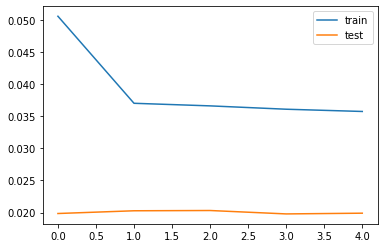

Calculating metrics
filename number 161
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.039919   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.036694   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.081048   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.019758   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.014919   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.036694  
2   0.403581   0.909091        1.0  0.081048  
3   0.414601   0.870130        1.0  0.019758  
4   0.414601   0.870130        1.0  0.014919  
5   0.362948   0.883117        1.0  0.009274  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0199 - val_los

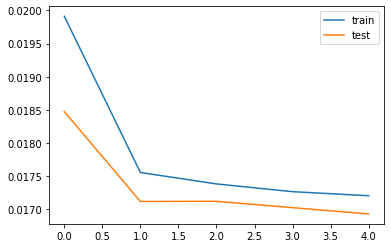

Calculating metrics
filename number 162
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.013659   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.008509   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.008733   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.000672   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.013659  
2   0.403581   0.909091        1.0  0.008509  
3   0.414601   0.870130        1.0  0.008733  
4   0.414601   0.870130        1.0  0.000672  
5   0.362948   0.883117        1.0  0.003135  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0536 - val_los

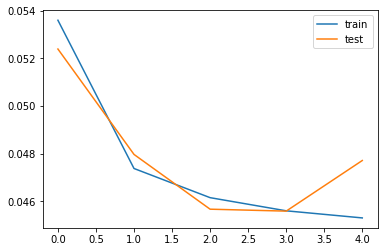

Calculating metrics
filename number 163
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1    0.01519   0.803549   0.637883   0.466877   0.718345   0.478840   
2    0.01519   0.803549   0.637883   0.466877   0.718345   0.478840   
3    0.01519   0.797212   0.662953   0.479232   0.720435   0.475585   
4    0.01519   0.797212   0.662953   0.479232   0.720435   0.475585   
5    0.01519   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)  var1(t)  
1   0.403581   0.909091        1.0  0.01519  
2   0.403581   0.909091        1.0  0.01519  
3   0.414601   0.870130        1.0  0.01519  
4   0.414601   0.870130        1.0  0.01519  
5   0.362948   0.883117        1.0  0.01519  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 71us/step - loss: 0.0214 - val_loss: 0.0

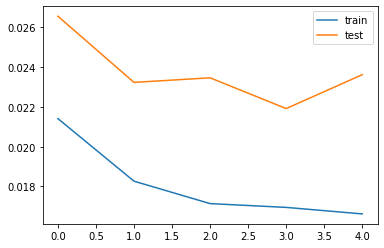

Calculating metrics
filename number 164
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.107848   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.237722   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.291899   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.144557   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.251646   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.237722  
2   0.403581   0.909091        1.0  0.291899  
3   0.414601   0.870130        1.0  0.144557  
4   0.414601   0.870130        1.0  0.251646  
5   0.362948   0.883117        1.0  0.235949  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 80us/step - loss: 0.0507 - val_los

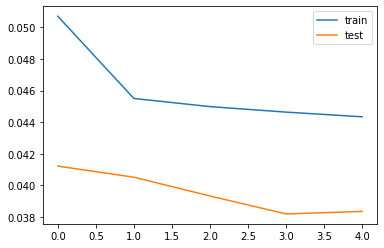

Calculating metrics
filename number 165
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0   0.803549   0.637883   0.466877   0.718345   0.478840   
2        0.0   0.803549   0.637883   0.466877   0.718345   0.478840   
3        0.0   0.797212   0.662953   0.479232   0.720435   0.475585   
4        0.0   0.797212   0.662953   0.479232   0.720435   0.475585   
5        0.0   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)  var1(t)  
1   0.403581   0.909091        1.0      0.0  
2   0.403581   0.909091        1.0      0.0  
3   0.414601   0.870130        1.0      0.0  
4   0.414601   0.870130        1.0      0.0  
5   0.362948   0.883117        1.0      0.0  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0045 - val_loss: 0.0

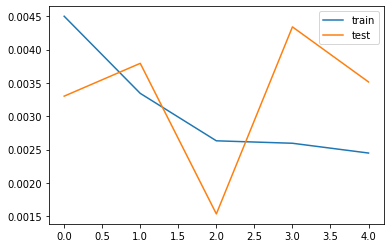

Calculating metrics
filename number 166
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.058342   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.148627   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.055702   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.064678   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.053590   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.148627  
2   0.403581   0.909091        1.0  0.055702  
3   0.414601   0.870130        1.0  0.064678  
4   0.414601   0.870130        1.0  0.053590  
5   0.362948   0.883117        1.0  0.045143  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0381 - val_los

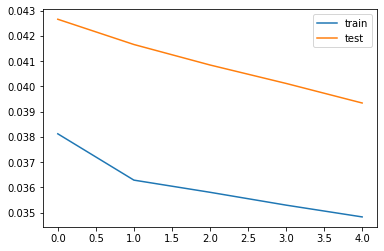

Calculating metrics
filename number 167
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.228935   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.226058   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.111796   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.034936   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.034936   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.226058  
2   0.403581   0.909091        1.0  0.111796  
3   0.414601   0.870130        1.0  0.034936  
4   0.414601   0.870130        1.0  0.034936  
5   0.362948   0.883117        1.0  0.056309  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0567 - val_los

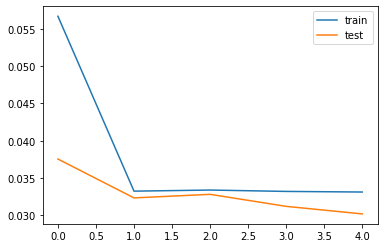

Calculating metrics
filename number 168
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.067797   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.061441   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.035487   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.046081   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.013242   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.061441  
2   0.403581   0.909091        1.0  0.035487  
3   0.414601   0.870130        1.0  0.046081  
4   0.414601   0.870130        1.0  0.013242  
5   0.362948   0.883117        1.0  0.009534  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0216 - val_los

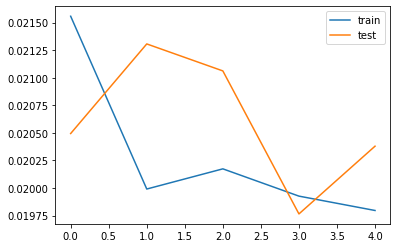

Calculating metrics
filename number 169
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.004248   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.010973   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.010265   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.003540   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.007080   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.010973  
2   0.403581   0.909091        1.0  0.010265  
3   0.414601   0.870130        1.0  0.003540  
4   0.414601   0.870130        1.0  0.007080  
5   0.362948   0.883117        1.0  0.010265  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0457 - val_los

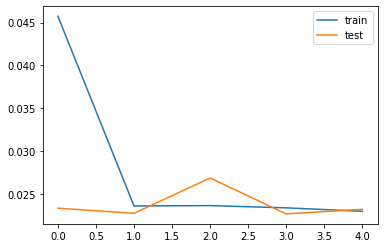

Calculating metrics
filename number 170
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.022444   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.673636   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.583551   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.573866   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.514835   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.673636  
2   0.403581   0.909091        1.0  0.583551  
3   0.414601   0.870130        1.0  0.573866  
4   0.414601   0.870130        1.0  0.514835  
5   0.362948   0.883117        1.0  0.546041  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0418 - val_los

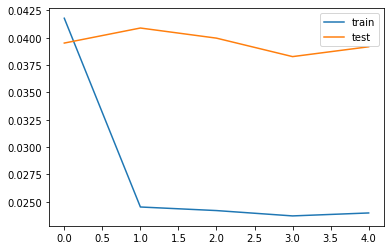

Calculating metrics
filename number 171
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.138152   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.053980   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.043916   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.035682   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.018298   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.053980  
2   0.403581   0.909091        1.0  0.043916  
3   0.414601   0.870130        1.0  0.035682  
4   0.414601   0.870130        1.0  0.018298  
5   0.362948   0.883117        1.0  0.031107  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0310 - val_los

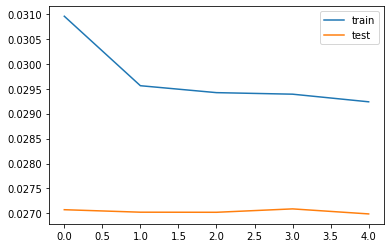

Calculating metrics
filename number 172
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.053922   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.107843   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.012255   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.044118   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.053922  
2   0.403581   0.909091        1.0  0.107843  
3   0.414601   0.870130        1.0  0.012255  
4   0.414601   0.870130        1.0  0.044118  
5   0.362948   0.883117        1.0  0.009804  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0451 - val_los

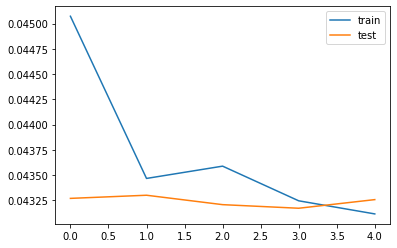

Calculating metrics
filename number 173
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.014610   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.021662   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.018640   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.014106   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.024685   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.021662  
2   0.403581   0.909091        1.0  0.018640  
3   0.414601   0.870130        1.0  0.014106  
4   0.414601   0.870130        1.0  0.024685  
5   0.362948   0.883117        1.0  0.013602  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0309 - val_los

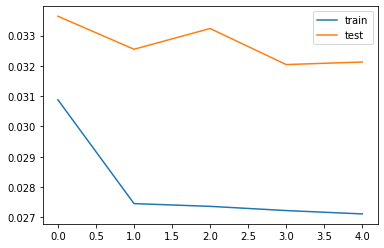

Calculating metrics
filename number 174
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.005301   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.003786   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.012874   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.002272   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.007952   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.003786  
2   0.403581   0.909091        1.0  0.012874  
3   0.414601   0.870130        1.0  0.002272  
4   0.414601   0.870130        1.0  0.007952  
5   0.362948   0.883117        1.0  0.001136  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0219 - val_los

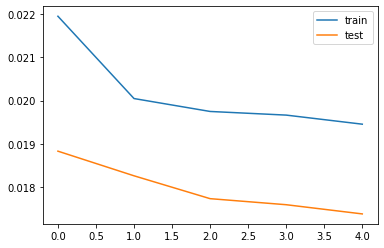

Calculating metrics
filename number 175
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.275171   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.192255   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.287016   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.201367   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.207289   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.192255  
2   0.403581   0.909091        1.0  0.287016  
3   0.414601   0.870130        1.0  0.201367  
4   0.414601   0.870130        1.0  0.207289  
5   0.362948   0.883117        1.0  0.235991  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0487 - val_los

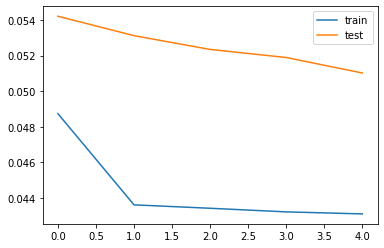

Calculating metrics
filename number 176
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.065014   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.060966   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.058184   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.058690   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.056160   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.060966  
2   0.403581   0.909091        1.0  0.058184  
3   0.414601   0.870130        1.0  0.058690  
4   0.414601   0.870130        1.0  0.056160  
5   0.362948   0.883117        1.0  0.045535  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0418 - val_los

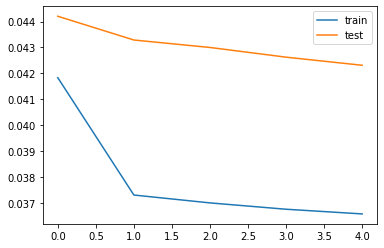

Calculating metrics
filename number 177
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.142541   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.129282   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.160958   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.144015   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.167587   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.129282  
2   0.403581   0.909091        1.0  0.160958  
3   0.414601   0.870130        1.0  0.144015  
4   0.414601   0.870130        1.0  0.167587  
5   0.362948   0.883117        1.0  0.127072  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0434 - val_los

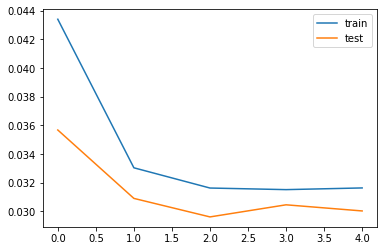

Calculating metrics
filename number 178
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.050223   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.043865   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.042594   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.046090   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.050540   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.043865  
2   0.403581   0.909091        1.0  0.042594  
3   0.414601   0.870130        1.0  0.046090  
4   0.414601   0.870130        1.0  0.050540  
5   0.362948   0.883117        1.0  0.109345  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0566 - val_los

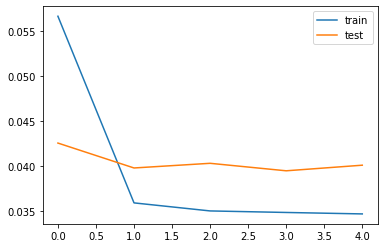

Calculating metrics
filename number 179
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.120034   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.153846   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.159763   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.147929   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.143702   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.153846  
2   0.403581   0.909091        1.0  0.159763  
3   0.414601   0.870130        1.0  0.147929  
4   0.414601   0.870130        1.0  0.143702  
5   0.362948   0.883117        1.0  0.152156  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0281 - val_los

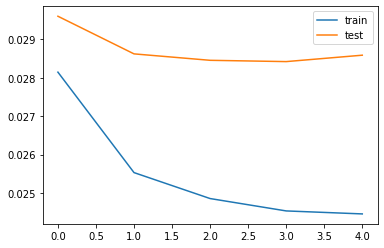

Calculating metrics
filename number 180
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129933   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.129326   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.114147   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.102004   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.163934   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.129326  
2   0.403581   0.909091        1.0  0.114147  
3   0.414601   0.870130        1.0  0.102004  
4   0.414601   0.870130        1.0  0.163934  
5   0.362948   0.883117        1.0  0.208257  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0501 - val_los

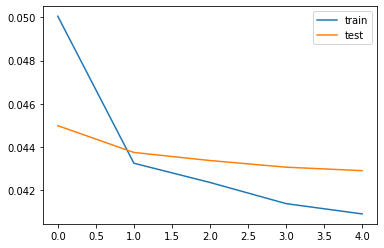

Calculating metrics
filename number 181
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.025707   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.011017   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.015770   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.036725   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.056168   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.011017  
2   0.403581   0.909091        1.0  0.015770  
3   0.414601   0.870130        1.0  0.036725  
4   0.414601   0.870130        1.0  0.056168  
5   0.362948   0.883117        1.0  0.065889  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 76us/step - loss: 0.0596 - val_los

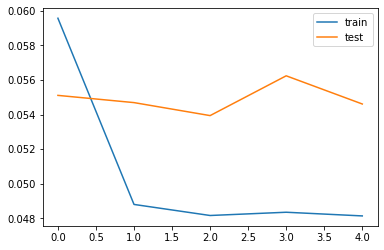

Calculating metrics
filename number 182
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.014345   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.017932   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.007173   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.025105   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.012552   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.017932  
2   0.403581   0.909091        1.0  0.007173  
3   0.414601   0.870130        1.0  0.025105  
4   0.414601   0.870130        1.0  0.012552  
5   0.362948   0.883117        1.0  0.007173  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0286 - val_los

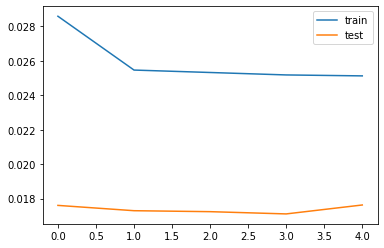

Calculating metrics
filename number 183
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.041667   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.035853   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.024225   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.048450   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.018411   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.035853  
2   0.403581   0.909091        1.0  0.024225  
3   0.414601   0.870130        1.0  0.048450  
4   0.414601   0.870130        1.0  0.018411  
5   0.362948   0.883117        1.0  0.052326  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0508 - val_los

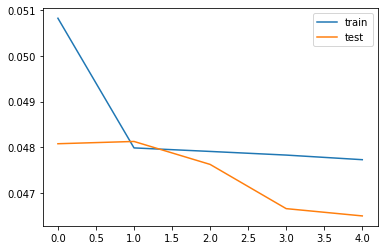

Calculating metrics
filename number 184
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.468147   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.840736   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.824809   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.818977   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.671153   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.840736  
2   0.403581   0.909091        1.0  0.824809  
3   0.414601   0.870130        1.0  0.818977  
4   0.414601   0.870130        1.0  0.671153  
5   0.362948   0.883117        1.0  0.438089  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 79us/step - loss: 0.0621 - val_los

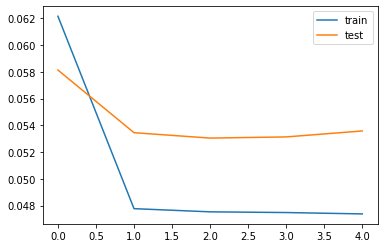

Calculating metrics
filename number 185
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.021212   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.031818   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.024242   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.018182   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.035606   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.031818  
2   0.403581   0.909091        1.0  0.024242  
3   0.414601   0.870130        1.0  0.018182  
4   0.414601   0.870130        1.0  0.035606  
5   0.362948   0.883117        1.0  0.021970  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0403 - val_los

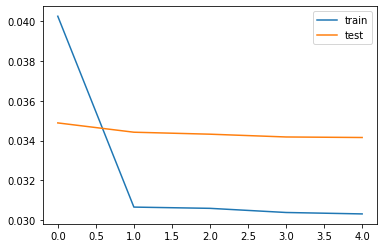

Calculating metrics
filename number 186
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.014810   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.011715   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.011052   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.012378   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.015915   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.011715  
2   0.403581   0.909091        1.0  0.011052  
3   0.414601   0.870130        1.0  0.012378  
4   0.414601   0.870130        1.0  0.015915  
5   0.362948   0.883117        1.0  0.030725  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0446 - val_los

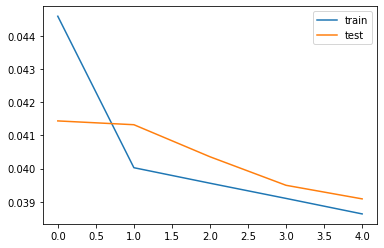

Calculating metrics
filename number 187
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.170058   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.246608   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.157461   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.189922   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.165213   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.246608  
2   0.403581   0.909091        1.0  0.157461  
3   0.414601   0.870130        1.0  0.189922  
4   0.414601   0.870130        1.0  0.165213  
5   0.362948   0.883117        1.0  0.153101  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0583 - val_los

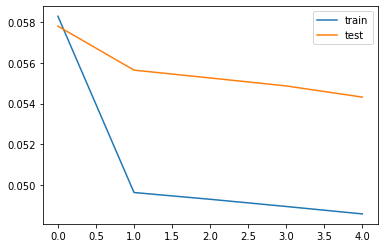

Calculating metrics
filename number 188
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.161716   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.143894   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.126733   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.084488   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.044884   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.143894  
2   0.403581   0.909091        1.0  0.126733  
3   0.414601   0.870130        1.0  0.084488  
4   0.414601   0.870130        1.0  0.044884  
5   0.362948   0.883117        1.0  0.050165  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0418 - val_los

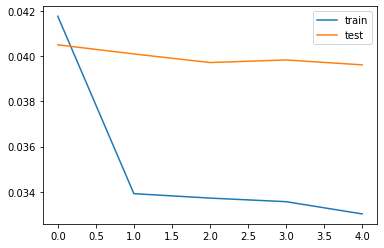

Calculating metrics
filename number 189
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.106068   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.089750   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.058134   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.083631   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.105558   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.089750  
2   0.403581   0.909091        1.0  0.058134  
3   0.414601   0.870130        1.0  0.083631  
4   0.414601   0.870130        1.0  0.105558  
5   0.362948   0.883117        1.0  0.080061  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0355 - val_los

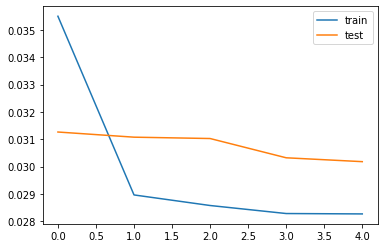

Calculating metrics
filename number 190
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.027547   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.027879   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.024892   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.024892   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.041155   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.027879  
2   0.403581   0.909091        1.0  0.024892  
3   0.414601   0.870130        1.0  0.024892  
4   0.414601   0.870130        1.0  0.041155  
5   0.362948   0.883117        1.0  0.022237  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 78us/step - loss: 0.0299 - val_los

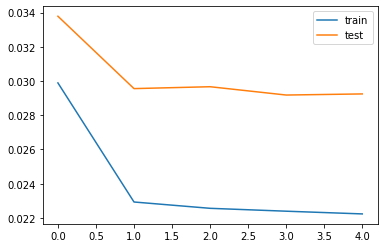

Calculating metrics
filename number 191
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.054991   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.057382   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.036461   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.037059   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.054393   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.057382  
2   0.403581   0.909091        1.0  0.036461  
3   0.414601   0.870130        1.0  0.037059  
4   0.414601   0.870130        1.0  0.054393  
5   0.362948   0.883117        1.0  0.065750  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0469 - val_los

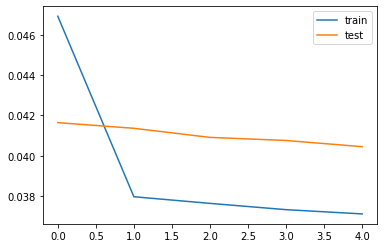

Calculating metrics
filename number 192
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.015599   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.020007   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.035944   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.008477   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.002035   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.020007  
2   0.403581   0.909091        1.0  0.035944  
3   0.414601   0.870130        1.0  0.008477  
4   0.414601   0.870130        1.0  0.002035  
5   0.362948   0.883117        1.0  0.013225  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0344 - val_los

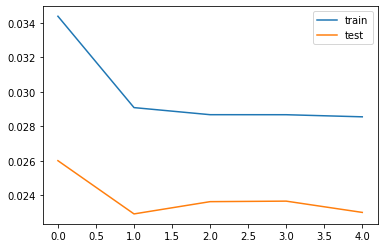

Calculating metrics
filename number 193
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.115551   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.117959   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.039961   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.030332   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.028888   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.117959  
2   0.403581   0.909091        1.0  0.039961  
3   0.414601   0.870130        1.0  0.030332  
4   0.414601   0.870130        1.0  0.028888  
5   0.362948   0.883117        1.0  0.014925  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0500 - val_los

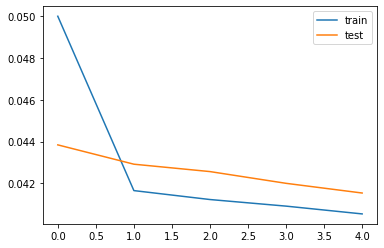

Calculating metrics
filename number 194
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.015800   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.015992   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.026204   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.024855   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.015029   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.015992  
2   0.403581   0.909091        1.0  0.026204  
3   0.414601   0.870130        1.0  0.024855  
4   0.414601   0.870130        1.0  0.015029  
5   0.362948   0.883117        1.0  0.016378  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0263 - val_los

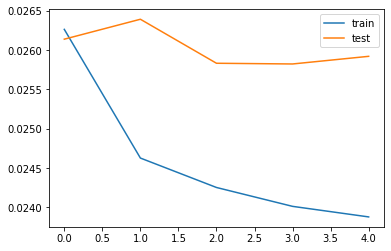

Calculating metrics
filename number 195
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.015653   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.955750   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.534317   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.535822   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.363335   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.955750  
2   0.403581   0.909091        1.0  0.534317  
3   0.414601   0.870130        1.0  0.535822  
4   0.414601   0.870130        1.0  0.363335  
5   0.362948   0.883117        1.0  0.184527  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 56us/step - loss: 0.0532 - val_los

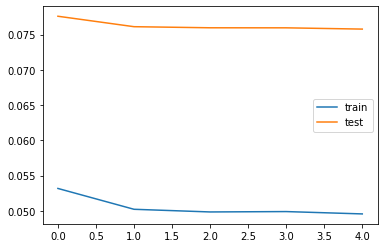

Calculating metrics
filename number 196
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.221463   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.177033   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.267601   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.031784   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.026999   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.177033  
2   0.403581   0.909091        1.0  0.267601  
3   0.414601   0.870130        1.0  0.031784  
4   0.414601   0.870130        1.0  0.026999  
5   0.362948   0.883117        1.0  0.022556  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 55us/step - loss: 0.0481 - val_los

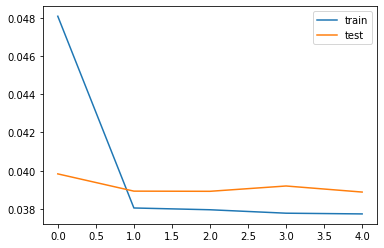

Calculating metrics
filename number 197
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.002538   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.124365   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.002538   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.035533   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.139594   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.124365  
2   0.403581   0.909091        1.0  0.002538  
3   0.414601   0.870130        1.0  0.035533  
4   0.414601   0.870130        1.0  0.139594  
5   0.362948   0.883117        1.0  0.015228  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 55us/step - loss: 0.0693 - val_los

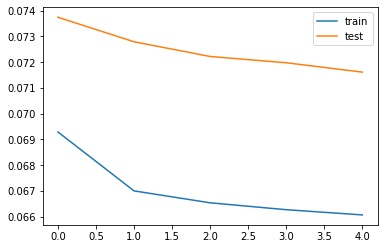

Calculating metrics
filename number 198
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.172197   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.072239   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.060479   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.121378   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.056279   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.072239  
2   0.403581   0.909091        1.0  0.060479  
3   0.414601   0.870130        1.0  0.121378  
4   0.414601   0.870130        1.0  0.056279  
5   0.362948   0.883117        1.0  0.029819  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 53us/step - loss: 0.0542 - val_los

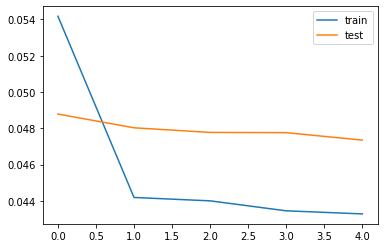

Calculating metrics
filename number 199
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.192661   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.181193   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.190367   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.173165   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.178899   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.181193  
2   0.403581   0.909091        1.0  0.190367  
3   0.414601   0.870130        1.0  0.173165  
4   0.414601   0.870130        1.0  0.178899  
5   0.362948   0.883117        1.0  0.159977  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0306 - val_los

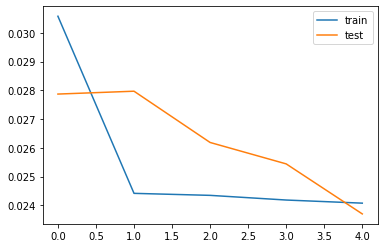

Calculating metrics
filename number 200
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.072539   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.070466   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.067703   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.067703   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.056649   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.070466  
2   0.403581   0.909091        1.0  0.067703  
3   0.414601   0.870130        1.0  0.067703  
4   0.414601   0.870130        1.0  0.056649  
5   0.362948   0.883117        1.0  0.076684  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0291 - val_los

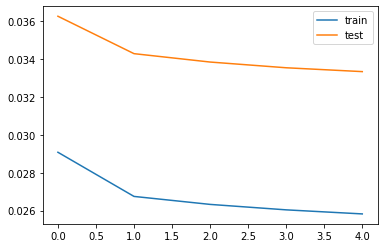

Calculating metrics
filename number 201
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0   0.803549   0.637883   0.466877   0.718345   0.478840   
2        0.0   0.803549   0.637883   0.466877   0.718345   0.478840   
3        0.0   0.797212   0.662953   0.479232   0.720435   0.475585   
4        0.0   0.797212   0.662953   0.479232   0.720435   0.475585   
5        0.0   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)  var1(t)  
1   0.403581   0.909091        1.0      0.0  
2   0.403581   0.909091        1.0      0.0  
3   0.414601   0.870130        1.0      0.0  
4   0.414601   0.870130        1.0      0.0  
5   0.362948   0.883117        1.0      0.0  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0069 - val_loss: 0.0

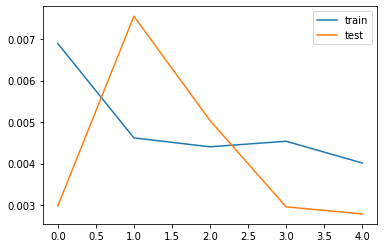

Calculating metrics
filename number 202
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.007133   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.081312   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.000000   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.000000   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.071327   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.081312  
2   0.403581   0.909091        1.0  0.000000  
3   0.414601   0.870130        1.0  0.000000  
4   0.414601   0.870130        1.0  0.071327  
5   0.362948   0.883117        1.0  0.011412  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 56us/step - loss: 0.0543 - val_los

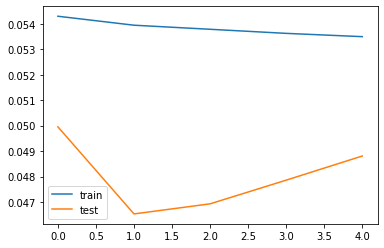

Calculating metrics
filename number 203
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.207955   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.203768   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.212840   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.202373   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.153524   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.203768  
2   0.403581   0.909091        1.0  0.212840  
3   0.414601   0.870130        1.0  0.202373  
4   0.414601   0.870130        1.0  0.153524  
5   0.362948   0.883117        1.0  0.078856  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0647 - val_los

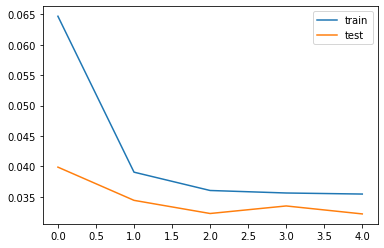

Calculating metrics
filename number 204
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.063969   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.058094   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.038512   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.045692   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.048303   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.058094  
2   0.403581   0.909091        1.0  0.038512  
3   0.414601   0.870130        1.0  0.045692  
4   0.414601   0.870130        1.0  0.048303  
5   0.362948   0.883117        1.0  0.033290  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 73us/step - loss: 0.0384 - val_los

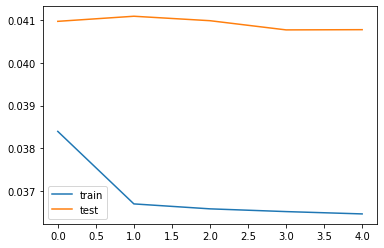

Calculating metrics
filename number 205
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.116102   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.124477   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.138180   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.108869   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.084507   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.124477  
2   0.403581   0.909091        1.0  0.138180  
3   0.414601   0.870130        1.0  0.108869  
4   0.414601   0.870130        1.0  0.084507  
5   0.362948   0.883117        1.0  0.082604  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 55us/step - loss: 0.0354 - val_los

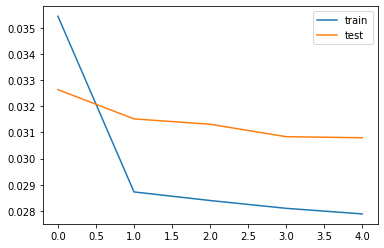

Calculating metrics
filename number 206
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.032707   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.016701   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.026444   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.041754   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.034795   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.016701  
2   0.403581   0.909091        1.0  0.026444  
3   0.414601   0.870130        1.0  0.041754  
4   0.414601   0.870130        1.0  0.034795  
5   0.362948   0.883117        1.0  0.016006  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0288 - val_los

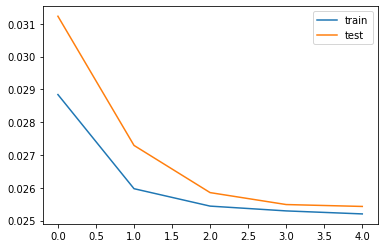

Calculating metrics
filename number 207
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.012099   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.006839   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.015781   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.003682   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.018937   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.006839  
2   0.403581   0.909091        1.0  0.015781  
3   0.414601   0.870130        1.0  0.003682  
4   0.414601   0.870130        1.0  0.018937  
5   0.362948   0.883117        1.0  0.002630  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 56us/step - loss: 0.0276 - val_los

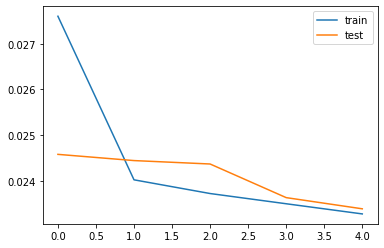

Calculating metrics
filename number 208
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.016798   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.010007   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.000000   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.002144   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.018585   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.010007  
2   0.403581   0.909091        1.0  0.000000  
3   0.414601   0.870130        1.0  0.002144  
4   0.414601   0.870130        1.0  0.018585  
5   0.362948   0.883117        1.0  0.016798  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 55us/step - loss: 0.0266 - val_los

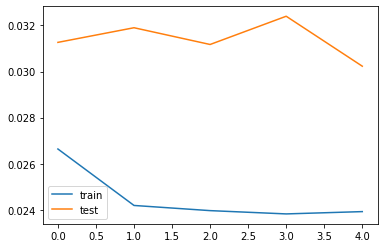

Calculating metrics
filename number 209
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.051668   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.050796   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.050578   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.033355   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.023327   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.050796  
2   0.403581   0.909091        1.0  0.050578  
3   0.414601   0.870130        1.0  0.033355  
4   0.414601   0.870130        1.0  0.023327  
5   0.362948   0.883117        1.0  0.015697  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0250 - val_los

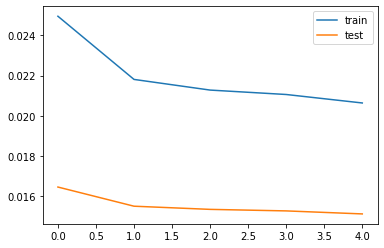

Calculating metrics
filename number 210
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.038136   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.052058   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.024818   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.009080   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.018160   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.052058  
2   0.403581   0.909091        1.0  0.024818  
3   0.414601   0.870130        1.0  0.009080  
4   0.414601   0.870130        1.0  0.018160  
5   0.362948   0.883117        1.0  0.066586  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0630 - val_los

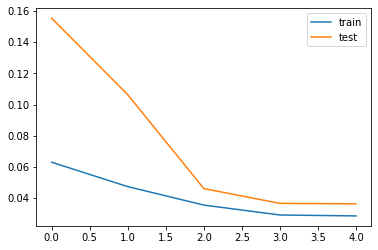

Calculating metrics
filename number 211
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.165727   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.140924   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.140549   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.166479   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.081924   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.140924  
2   0.403581   0.909091        1.0  0.140549  
3   0.414601   0.870130        1.0  0.166479  
4   0.414601   0.870130        1.0  0.081924  
5   0.362948   0.883117        1.0  0.040962  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 53us/step - loss: 0.0362 - val_los

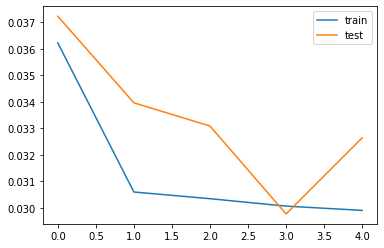

Calculating metrics
filename number 212
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.105263   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.058704   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.053846   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.136437   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.060729   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.058704  
2   0.403581   0.909091        1.0  0.053846  
3   0.414601   0.870130        1.0  0.136437  
4   0.414601   0.870130        1.0  0.060729  
5   0.362948   0.883117        1.0  0.124291  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 94us/step - loss: 0.0305 - val_los

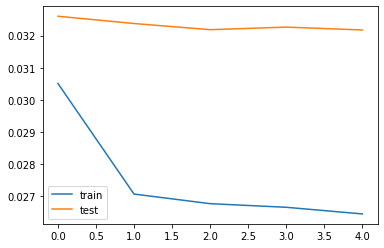

Calculating metrics
filename number 213
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.158827   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.162693   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.136276   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.139497   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.055090   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.162693  
2   0.403581   0.909091        1.0  0.136276  
3   0.414601   0.870130        1.0  0.139497  
4   0.414601   0.870130        1.0  0.055090  
5   0.362948   0.883117        1.0  0.023518  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 72us/step - loss: 0.0423 - val_los

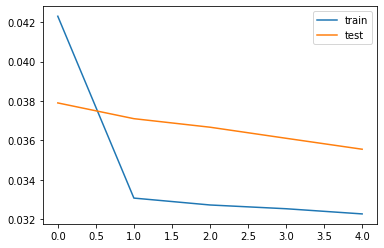

Calculating metrics
filename number 214
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.022696   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.038514   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.045048   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.043329   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.056396   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.038514  
2   0.403581   0.909091        1.0  0.045048  
3   0.414601   0.870130        1.0  0.043329  
4   0.414601   0.870130        1.0  0.056396  
5   0.362948   0.883117        1.0  0.012036  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 73us/step - loss: 0.0328 - val_los

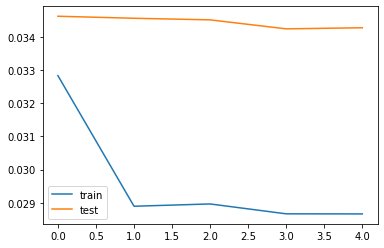

Calculating metrics
filename number 215
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.196644   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.138437   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.080755   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.074463   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.048243   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.138437  
2   0.403581   0.909091        1.0  0.080755  
3   0.414601   0.870130        1.0  0.074463  
4   0.414601   0.870130        1.0  0.048243  
5   0.362948   0.883117        1.0  0.077609  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 71us/step - loss: 0.0443 - val_los

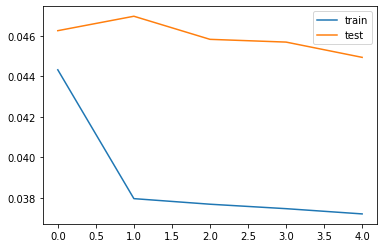

Calculating metrics
filename number 216
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.054893   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.242005   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.194749   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.117661   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.207876   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.242005  
2   0.403581   0.909091        1.0  0.194749  
3   0.414601   0.870130        1.0  0.117661  
4   0.414601   0.870130        1.0  0.207876  
5   0.362948   0.883117        1.0  0.127446  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0463 - val_los

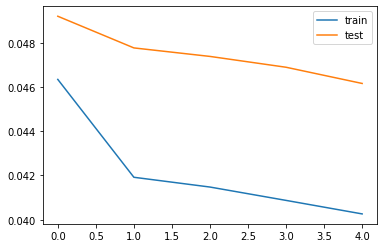

Calculating metrics
filename number 217
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.011862   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.004126   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.010315   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.011346   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.006189   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.004126  
2   0.403581   0.909091        1.0  0.010315  
3   0.414601   0.870130        1.0  0.011346  
4   0.414601   0.870130        1.0  0.006189  
5   0.362948   0.883117        1.0  0.008252  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0354 - val_los

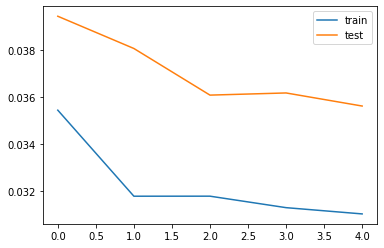

Calculating metrics
filename number 218
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.057659   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.090361   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.069707   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.059380   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.100688   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.090361  
2   0.403581   0.909091        1.0  0.069707  
3   0.414601   0.870130        1.0  0.059380  
4   0.414601   0.870130        1.0  0.100688  
5   0.362948   0.883117        1.0  0.061962  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0514 - val_los

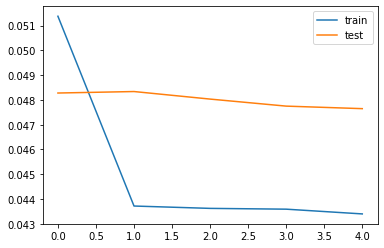

Calculating metrics
filename number 219
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008616   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.316428   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.316233   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.320345   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.327785   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.316428  
2   0.403581   0.909091        1.0  0.316233  
3   0.414601   0.870130        1.0  0.320345  
4   0.414601   0.870130        1.0  0.327785  
5   0.362948   0.883117        1.0  0.343450  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0562 - val_los

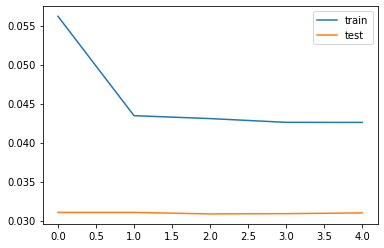

Calculating metrics
filename number 220
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.135587   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.094725   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.069837   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.128157   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.104383   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.094725  
2   0.403581   0.909091        1.0  0.069837  
3   0.414601   0.870130        1.0  0.128157  
4   0.414601   0.870130        1.0  0.104383  
5   0.362948   0.883117        1.0  0.121471  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0442 - val_los

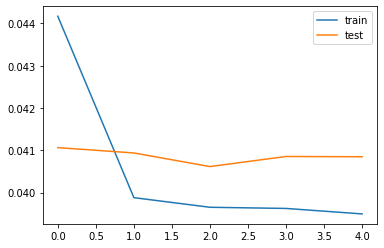

Calculating metrics
filename number 221
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003662   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.009764   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.002034   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.009764   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.003255   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.009764  
2   0.403581   0.909091        1.0  0.002034  
3   0.414601   0.870130        1.0  0.009764  
4   0.414601   0.870130        1.0  0.003255  
5   0.362948   0.883117        1.0  0.002034  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 73us/step - loss: 0.0445 - val_los

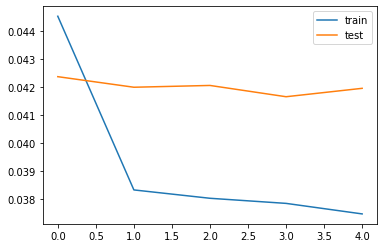

Calculating metrics
filename number 222
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.068792   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.121644   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.171980   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.135906   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.065436   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.121644  
2   0.403581   0.909091        1.0  0.171980  
3   0.414601   0.870130        1.0  0.135906  
4   0.414601   0.870130        1.0  0.065436  
5   0.362948   0.883117        1.0  0.040268  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0450 - val_los

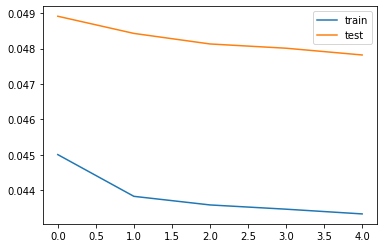

Calculating metrics
filename number 223
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000361   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.008658   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.015873   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.027056   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.041847   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.008658  
2   0.403581   0.909091        1.0  0.015873  
3   0.414601   0.870130        1.0  0.027056  
4   0.414601   0.870130        1.0  0.041847  
5   0.362948   0.883117        1.0  0.017677  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0347 - val_los

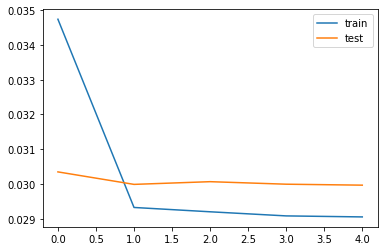

Calculating metrics
filename number 224
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.007286   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.767456   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.799939   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.496053   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.417122   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.767456  
2   0.403581   0.909091        1.0  0.799939  
3   0.414601   0.870130        1.0  0.496053  
4   0.414601   0.870130        1.0  0.417122  
5   0.362948   0.883117        1.0  0.322404  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0509 - val_los

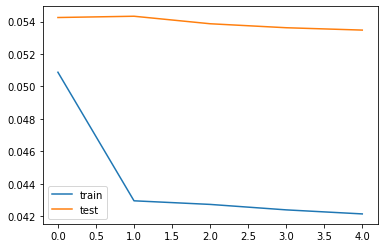

Calculating metrics
filename number 225
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.037963   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.025308   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.090478   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.085416   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.071813   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.025308  
2   0.403581   0.909091        1.0  0.090478  
3   0.414601   0.870130        1.0  0.085416  
4   0.414601   0.870130        1.0  0.071813  
5   0.362948   0.883117        1.0  0.042075  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0550 - val_los

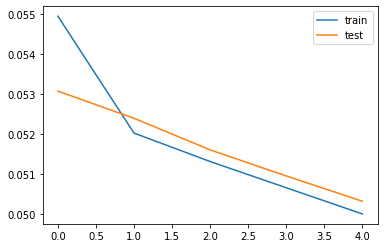

Calculating metrics
filename number 226
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.113649   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.089723   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.062534   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.078847   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.091898   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.089723  
2   0.403581   0.909091        1.0  0.062534  
3   0.414601   0.870130        1.0  0.078847  
4   0.414601   0.870130        1.0  0.091898  
5   0.362948   0.883117        1.0  0.098967  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0346 - val_los

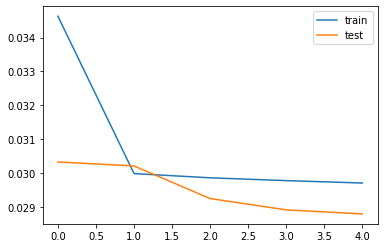

Calculating metrics
filename number 227
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.104525   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.070108   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.087317   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.105800   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.126832   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.070108  
2   0.403581   0.909091        1.0  0.087317  
3   0.414601   0.870130        1.0  0.105800  
4   0.414601   0.870130        1.0  0.126832  
5   0.362948   0.883117        1.0  0.058636  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0463 - val_los

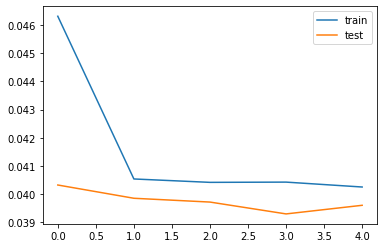

Calculating metrics
filename number 228
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.029969   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.030252   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.030817   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.024314   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.010744   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.030252  
2   0.403581   0.909091        1.0  0.030817  
3   0.414601   0.870130        1.0  0.024314  
4   0.414601   0.870130        1.0  0.010744  
5   0.362948   0.883117        1.0  0.005655  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0330 - val_los

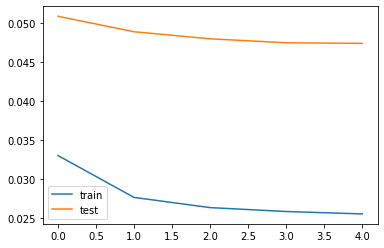

Calculating metrics
filename number 229
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.062462   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.062462   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.056398   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.068526   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.071559   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.062462  
2   0.403581   0.909091        1.0  0.056398  
3   0.414601   0.870130        1.0  0.068526  
4   0.414601   0.870130        1.0  0.071559  
5   0.362948   0.883117        1.0  0.067920  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0356 - val_los

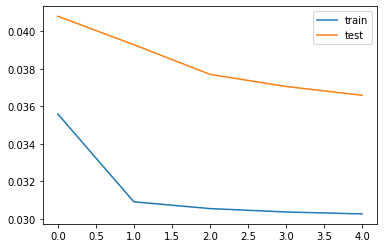

Calculating metrics
filename number 230
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.041536   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.134796   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.030564   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.041536   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.041536  
2   0.403581   0.909091        1.0  0.134796  
3   0.414601   0.870130        1.0  0.030564  
4   0.414601   0.870130        1.0  0.041536  
5   0.362948   0.883117        1.0  0.004702  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0410 - val_los

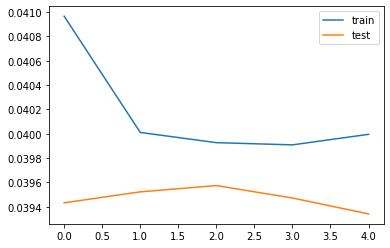

Calculating metrics
filename number 231
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.181298   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.147901   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.109733   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.072519   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.118321   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.147901  
2   0.403581   0.909091        1.0  0.109733  
3   0.414601   0.870130        1.0  0.072519  
4   0.414601   0.870130        1.0  0.118321  
5   0.362948   0.883117        1.0  0.087786  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 77us/step - loss: 0.0427 - val_los

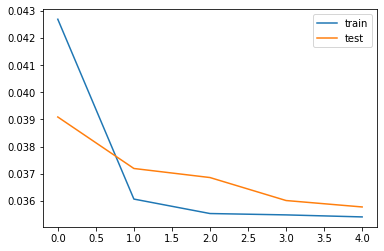

Calculating metrics
filename number 232
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.374855   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.117613   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.073001   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.067207   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.035921   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.117613  
2   0.403581   0.909091        1.0  0.073001  
3   0.414601   0.870130        1.0  0.067207  
4   0.414601   0.870130        1.0  0.035921  
5   0.362948   0.883117        1.0  0.021437  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0417 - val_los

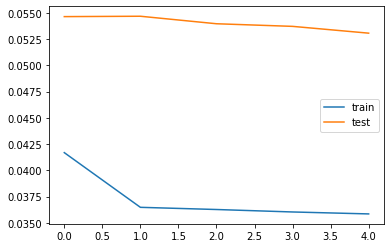

Calculating metrics
filename number 233
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.046993   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.041940   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.046993   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.103082   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.042951   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.041940  
2   0.403581   0.909091        1.0  0.046993  
3   0.414601   0.870130        1.0  0.103082  
4   0.414601   0.870130        1.0  0.042951  
5   0.362948   0.883117        1.0  0.024760  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0387 - val_los

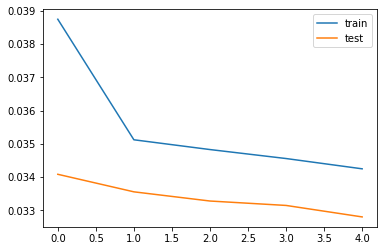

Calculating metrics
filename number 234
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.071965   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.090738   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.186483   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.028786   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.044431   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.090738  
2   0.403581   0.909091        1.0  0.186483  
3   0.414601   0.870130        1.0  0.028786  
4   0.414601   0.870130        1.0  0.044431  
5   0.362948   0.883117        1.0  0.028160  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0372 - val_los

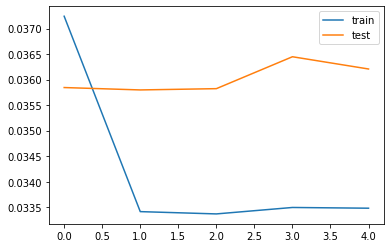

Calculating metrics
filename number 235
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.111817   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.039814   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.032190   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.017789   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.024989   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.039814  
2   0.403581   0.909091        1.0  0.032190  
3   0.414601   0.870130        1.0  0.017789  
4   0.414601   0.870130        1.0  0.024989  
5   0.362948   0.883117        1.0  0.049132  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0270 - val_los

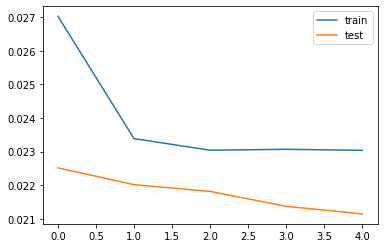

Calculating metrics
filename number 236
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.139063   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.507812   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.444643   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.400223   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.388616   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.507812  
2   0.403581   0.909091        1.0  0.444643  
3   0.414601   0.870130        1.0  0.400223  
4   0.414601   0.870130        1.0  0.388616  
5   0.362948   0.883117        1.0  0.223661  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0619 - val_los

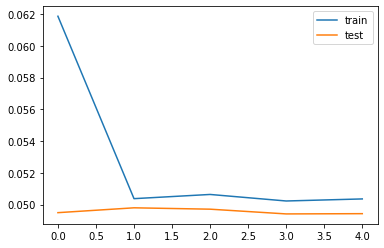

Calculating metrics
filename number 237
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.089367   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.058824   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.063914   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.088801   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.069005   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.058824  
2   0.403581   0.909091        1.0  0.063914  
3   0.414601   0.870130        1.0  0.088801  
4   0.414601   0.870130        1.0  0.069005  
5   0.362948   0.883117        1.0  0.057692  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0384 - val_los

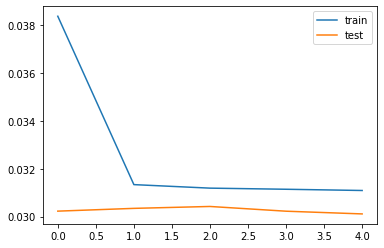

Calculating metrics
filename number 238
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.045230   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.063958   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.060071   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.045936   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.055124   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.063958  
2   0.403581   0.909091        1.0  0.060071  
3   0.414601   0.870130        1.0  0.045936  
4   0.414601   0.870130        1.0  0.055124  
5   0.362948   0.883117        1.0  0.067491  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0336 - val_los

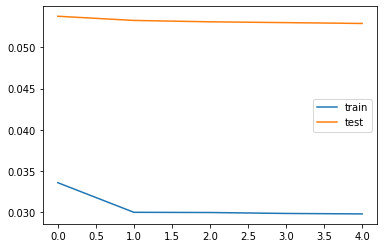

Calculating metrics
filename number 239
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.142468   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.049002   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.007260   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.007260   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.013612   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.049002  
2   0.403581   0.909091        1.0  0.007260  
3   0.414601   0.870130        1.0  0.007260  
4   0.414601   0.870130        1.0  0.013612  
5   0.362948   0.883117        1.0  0.034483  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0283 - val_los

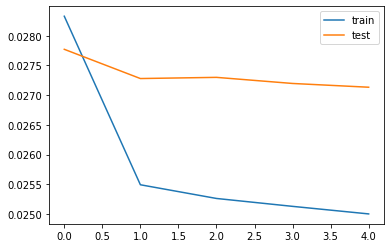

Calculating metrics
filename number 240
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.288908   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.191745   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.203783   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.279450   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.197764   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.191745  
2   0.403581   0.909091        1.0  0.203783  
3   0.414601   0.870130        1.0  0.279450  
4   0.414601   0.870130        1.0  0.197764  
5   0.362948   0.883117        1.0  0.110060  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0375 - val_los

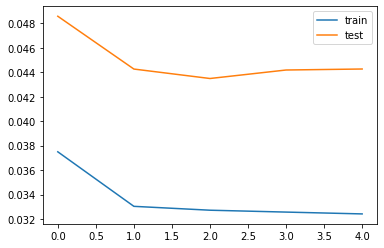

Calculating metrics
filename number 241
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.114137   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.385646   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.102897   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.087765   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.073498   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.385646  
2   0.403581   0.909091        1.0  0.102897  
3   0.414601   0.870130        1.0  0.087765  
4   0.414601   0.870130        1.0  0.073498  
5   0.362948   0.883117        1.0  0.006485  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0341 - val_los

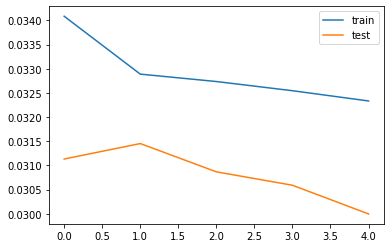

Calculating metrics
filename number 242
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.029336   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.029336   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.020276   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.018550   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.030198   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.029336  
2   0.403581   0.909091        1.0  0.020276  
3   0.414601   0.870130        1.0  0.018550  
4   0.414601   0.870130        1.0  0.030198  
5   0.362948   0.883117        1.0  0.029336  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0316 - val_los

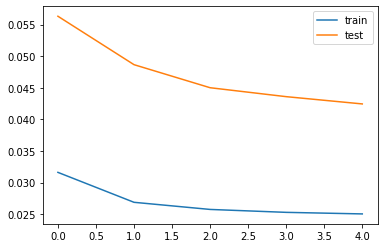

Calculating metrics
filename number 243
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.059623   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.004184   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.058577   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.036611   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.029289   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.004184  
2   0.403581   0.909091        1.0  0.058577  
3   0.414601   0.870130        1.0  0.036611  
4   0.414601   0.870130        1.0  0.029289  
5   0.362948   0.883117        1.0  0.063808  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0312 - val_los

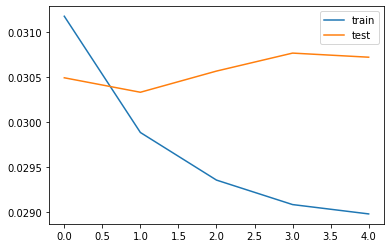

Calculating metrics
filename number 244
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.026659   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.023823   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.022121   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.013613   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.065230   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.023823  
2   0.403581   0.909091        1.0  0.022121  
3   0.414601   0.870130        1.0  0.013613  
4   0.414601   0.870130        1.0  0.065230  
5   0.362948   0.883117        1.0  0.053318  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 87us/step - loss: 0.0371 - val_los

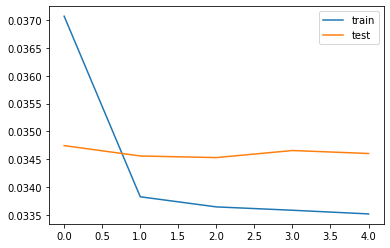

Calculating metrics
filename number 245
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.003293   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.000000   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.017197   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.017563   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.003293   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.000000  
2   0.403581   0.909091        1.0  0.017197  
3   0.414601   0.870130        1.0  0.017563  
4   0.414601   0.870130        1.0  0.003293  
5   0.362948   0.883117        1.0  0.000000  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 72us/step - loss: 0.0127 - val_los

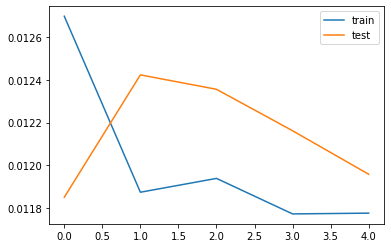

Calculating metrics
filename number 246
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.031503   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.154960   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.083653   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.179864   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.041933   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.154960  
2   0.403581   0.909091        1.0  0.083653  
3   0.414601   0.870130        1.0  0.179864  
4   0.414601   0.870130        1.0  0.041933  
5   0.362948   0.883117        1.0  0.042571  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0292 - val_los

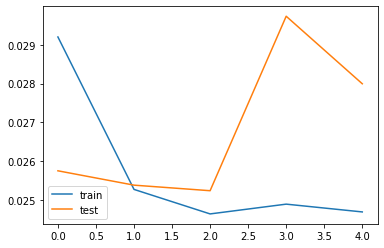

Calculating metrics
filename number 247
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.091968   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.026977   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.021459   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.036174   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.045371   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.026977  
2   0.403581   0.909091        1.0  0.021459  
3   0.414601   0.870130        1.0  0.036174  
4   0.414601   0.870130        1.0  0.045371  
5   0.362948   0.883117        1.0  0.003679  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0371 - val_los

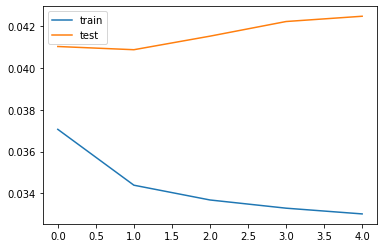

Calculating metrics
filename number 248
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.090237   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.075937   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.056706   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.061637   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.037475   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.075937  
2   0.403581   0.909091        1.0  0.056706  
3   0.414601   0.870130        1.0  0.061637  
4   0.414601   0.870130        1.0  0.037475  
5   0.362948   0.883117        1.0  0.052268  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0317 - val_los

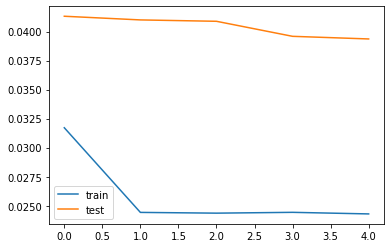

Calculating metrics
filename number 249
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.024735   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.024342   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.009030   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.011779   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.024342   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.024342  
2   0.403581   0.909091        1.0  0.009030  
3   0.414601   0.870130        1.0  0.011779  
4   0.414601   0.870130        1.0  0.024342  
5   0.362948   0.883117        1.0  0.024735  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 71us/step - loss: 0.0259 - val_los

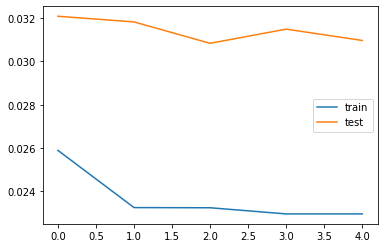

Calculating metrics
filename number 250
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.092539   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.057150   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.019847   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.020564   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.017456   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.057150  
2   0.403581   0.909091        1.0  0.019847  
3   0.414601   0.870130        1.0  0.020564  
4   0.414601   0.870130        1.0  0.017456  
5   0.362948   0.883117        1.0  0.019369  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 84us/step - loss: 0.0452 - val_los

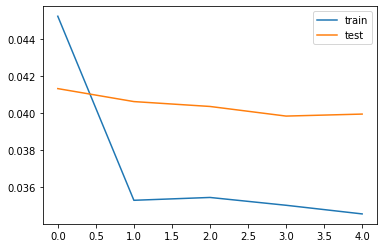

Calculating metrics
filename number 251
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.024055   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.008591   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.007302   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.000000   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.009880   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.008591  
2   0.403581   0.909091        1.0  0.007302  
3   0.414601   0.870130        1.0  0.000000  
4   0.414601   0.870130        1.0  0.009880  
5   0.362948   0.883117        1.0  0.001289  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0339 - val_los

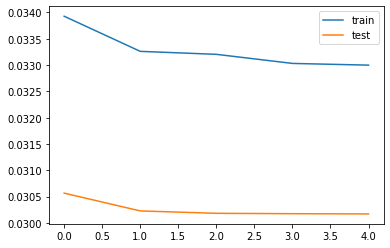

Calculating metrics
filename number 252
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.013935   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.008067   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.013935   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.008067   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.011001   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.008067  
2   0.403581   0.909091        1.0  0.013935  
3   0.414601   0.870130        1.0  0.008067  
4   0.414601   0.870130        1.0  0.011001  
5   0.362948   0.883117        1.0  0.011735  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0187 - val_los

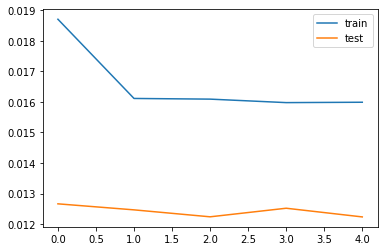

Calculating metrics
filename number 253
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.235047   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.465493   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.342068   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.385077   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.276455   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.465493  
2   0.403581   0.909091        1.0  0.342068  
3   0.414601   0.870130        1.0  0.385077  
4   0.414601   0.870130        1.0  0.276455  
5   0.362948   0.883117        1.0  0.181836  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0550 - val_los

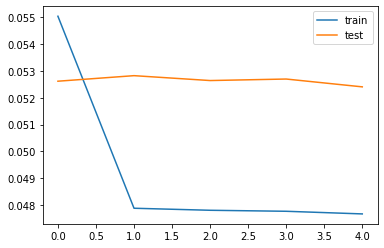

Calculating metrics
filename number 254
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.531250   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.247159   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.002841   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.005682   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.008523   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.247159  
2   0.403581   0.909091        1.0  0.002841  
3   0.414601   0.870130        1.0  0.005682  
4   0.414601   0.870130        1.0  0.008523  
5   0.362948   0.883117        1.0  0.005682  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 74us/step - loss: 0.0999 - val_los

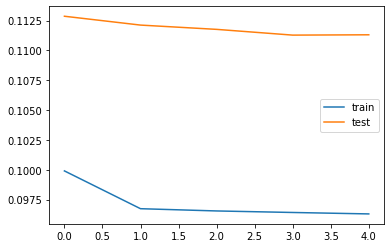

Calculating metrics
filename number 255
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.156182   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.172144   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.156495   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.194366   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.225978   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.172144  
2   0.403581   0.909091        1.0  0.156495  
3   0.414601   0.870130        1.0  0.194366  
4   0.414601   0.870130        1.0  0.225978  
5   0.362948   0.883117        1.0  0.135524  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0375 - val_los

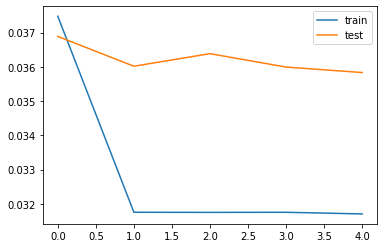

Calculating metrics
filename number 256
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1     0.0175   0.803549   0.637883   0.466877   0.718345   0.478840   
2     0.0180   0.803549   0.637883   0.466877   0.718345   0.478840   
3     0.0190   0.797212   0.662953   0.479232   0.720435   0.475585   
4     0.0180   0.797212   0.662953   0.479232   0.720435   0.475585   
5     0.0185   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)  var1(t)  
1   0.403581   0.909091        1.0   0.0180  
2   0.403581   0.909091        1.0   0.0190  
3   0.414601   0.870130        1.0   0.0180  
4   0.414601   0.870130        1.0   0.0185  
5   0.362948   0.883117        1.0   0.0180  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 73us/step - loss: 0.0368 - val_loss: 0.0

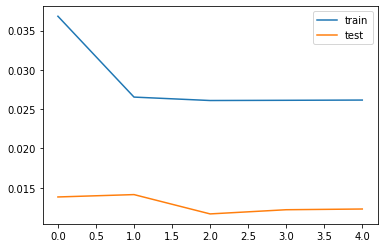

Calculating metrics
filename number 257
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.223887   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.122860   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.034675   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.008562   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.004281   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.122860  
2   0.403581   0.909091        1.0  0.034675  
3   0.414601   0.870130        1.0  0.008562  
4   0.414601   0.870130        1.0  0.004281  
5   0.362948   0.883117        1.0  0.006849  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0536 - val_los

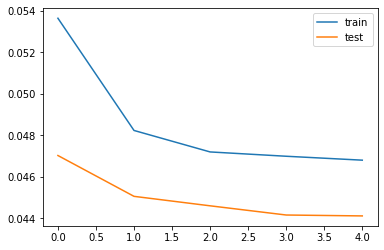

Calculating metrics
filename number 258
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.015883   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.027586   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.036782   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.050157   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020481   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.027586  
2   0.403581   0.909091        1.0  0.036782  
3   0.414601   0.870130        1.0  0.050157  
4   0.414601   0.870130        1.0  0.020481  
5   0.362948   0.883117        1.0  0.018600  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0343 - val_los

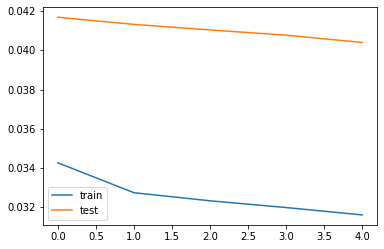

Calculating metrics
filename number 259
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.062927   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.054720   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.095759   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.069767   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.125855   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.054720  
2   0.403581   0.909091        1.0  0.095759  
3   0.414601   0.870130        1.0  0.069767  
4   0.414601   0.870130        1.0  0.125855  
5   0.362948   0.883117        1.0  0.050616  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0359 - val_los

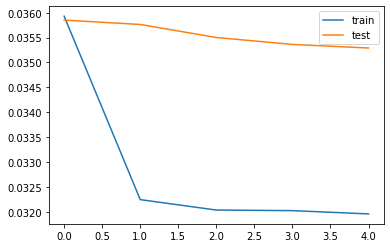

Calculating metrics
filename number 260
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.048186   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.187388   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.049970   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.046401   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.026770   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.187388  
2   0.403581   0.909091        1.0  0.049970  
3   0.414601   0.870130        1.0  0.046401  
4   0.414601   0.870130        1.0  0.026770  
5   0.362948   0.883117        1.0  0.026175  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0392 - val_los

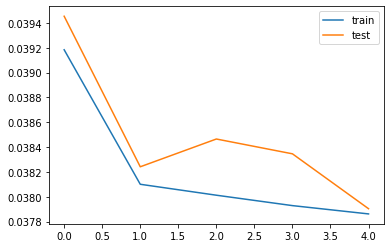

Calculating metrics
filename number 261
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.012010   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.012276   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.012010   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.012276   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.165733   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.012276  
2   0.403581   0.909091        1.0  0.012010  
3   0.414601   0.870130        1.0  0.012276  
4   0.414601   0.870130        1.0  0.165733  
5   0.362948   0.883117        1.0  0.012276  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0476 - val_los

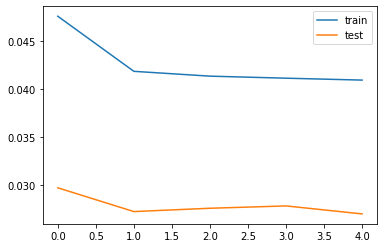

Calculating metrics
filename number 262
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.080122   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.084041   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.037013   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.004572   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.008273   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.084041  
2   0.403581   0.909091        1.0  0.037013  
3   0.414601   0.870130        1.0  0.004572  
4   0.414601   0.870130        1.0  0.008273  
5   0.362948   0.883117        1.0  0.008273  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0315 - val_los

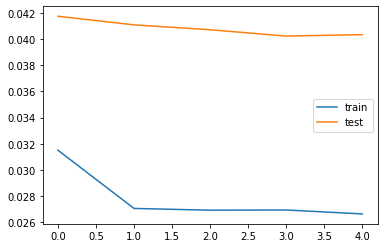

Calculating metrics
filename number 263
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.391664   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.385710   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.382402   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.364208   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.317896   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.385710  
2   0.403581   0.909091        1.0  0.382402  
3   0.414601   0.870130        1.0  0.364208  
4   0.414601   0.870130        1.0  0.317896  
5   0.362948   0.883117        1.0  0.302349  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0597 - val_los

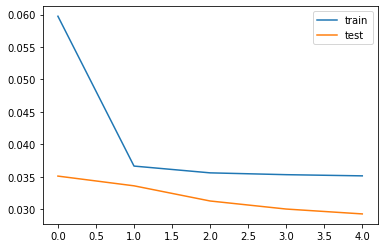

Calculating metrics
filename number 264
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.082600   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.088037   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.109011   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.209218   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.077162   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.088037  
2   0.403581   0.909091        1.0  0.109011  
3   0.414601   0.870130        1.0  0.209218  
4   0.414601   0.870130        1.0  0.077162  
5   0.362948   0.883117        1.0  0.015277  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0357 - val_los

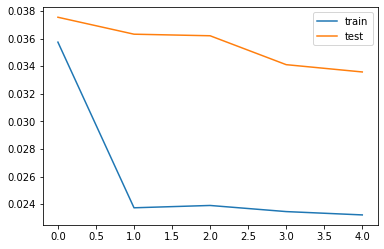

Calculating metrics
filename number 265
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.016120   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.022453   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.021301   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.017271   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.022453   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.022453  
2   0.403581   0.909091        1.0  0.021301  
3   0.414601   0.870130        1.0  0.017271  
4   0.414601   0.870130        1.0  0.022453  
5   0.362948   0.883117        1.0  0.032239  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0479 - val_los

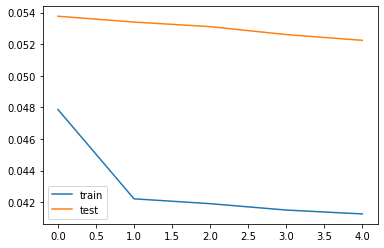

Calculating metrics
filename number 266
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.063369   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.074961   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.066074   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.073802   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.050232   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.074961  
2   0.403581   0.909091        1.0  0.066074  
3   0.414601   0.870130        1.0  0.073802  
4   0.414601   0.870130        1.0  0.050232  
5   0.362948   0.883117        1.0  0.048686  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0355 - val_los

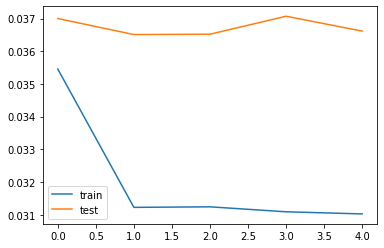

Calculating metrics
filename number 267
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.191874   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.067720   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.046652   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.056433   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.053424   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.067720  
2   0.403581   0.909091        1.0  0.046652  
3   0.414601   0.870130        1.0  0.056433  
4   0.414601   0.870130        1.0  0.053424  
5   0.362948   0.883117        1.0  0.037622  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0712 - val_los

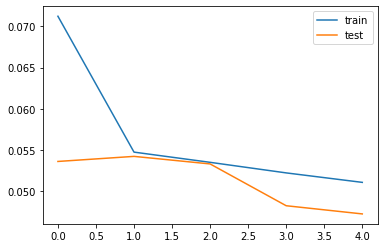

Calculating metrics
filename number 268
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.091182   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.093781   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.249350   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.075785   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.078384   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.093781  
2   0.403581   0.909091        1.0  0.249350  
3   0.414601   0.870130        1.0  0.075785  
4   0.414601   0.870130        1.0  0.078384  
5   0.362948   0.883117        1.0  0.080584  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0224 - val_los

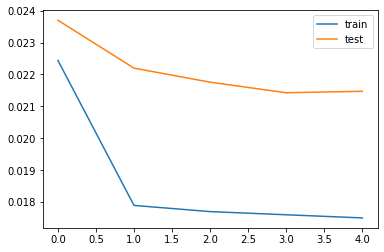

Calculating metrics
filename number 269
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.107935   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.086931   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.056009   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.045508   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.046091   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.086931  
2   0.403581   0.909091        1.0  0.056009  
3   0.414601   0.870130        1.0  0.045508  
4   0.414601   0.870130        1.0  0.046091  
5   0.362948   0.883117        1.0  0.026254  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0297 - val_los

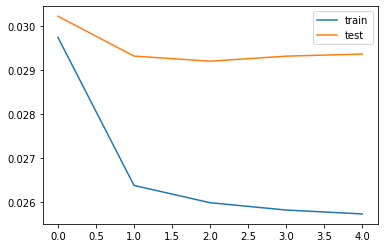

Calculating metrics
filename number 270
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.086435   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.146859   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.088435   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.083233   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.036014   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.146859  
2   0.403581   0.909091        1.0  0.088435  
3   0.414601   0.870130        1.0  0.083233  
4   0.414601   0.870130        1.0  0.036014  
5   0.362948   0.883117        1.0  0.028812  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0488 - val_los

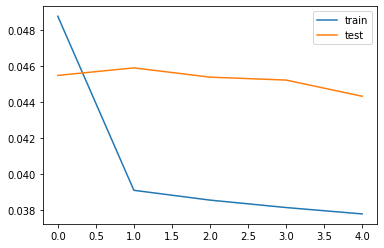

Calculating metrics
filename number 271
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.093937   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.028314   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.023651   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.016989   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.019320   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.028314  
2   0.403581   0.909091        1.0  0.023651  
3   0.414601   0.870130        1.0  0.016989  
4   0.414601   0.870130        1.0  0.019320  
5   0.362948   0.883117        1.0  0.019987  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0423 - val_los

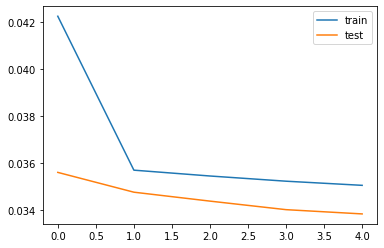

Calculating metrics
filename number 272
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.036929   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.075802   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.133139   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.015549   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.028183   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.075802  
2   0.403581   0.909091        1.0  0.133139  
3   0.414601   0.870130        1.0  0.015549  
4   0.414601   0.870130        1.0  0.028183  
5   0.362948   0.883117        1.0  0.028183  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0327 - val_los

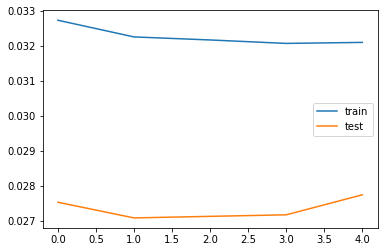

Calculating metrics
filename number 273
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.065990   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.103509   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.094902   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.068197   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.030678   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.103509  
2   0.403581   0.909091        1.0  0.094902  
3   0.414601   0.870130        1.0  0.068197  
4   0.414601   0.870130        1.0  0.030678  
5   0.362948   0.883117        1.0  0.018098  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0357 - val_los

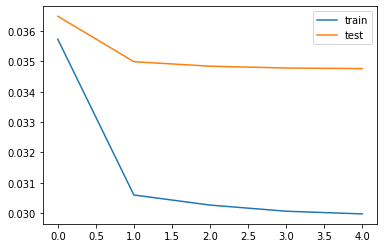

Calculating metrics
filename number 274
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.026399   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.028089   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.072650   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.029567   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.025132   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.028089  
2   0.403581   0.909091        1.0  0.072650  
3   0.414601   0.870130        1.0  0.029567  
4   0.414601   0.870130        1.0  0.025132  
5   0.362948   0.883117        1.0  0.023020  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0219 - val_los

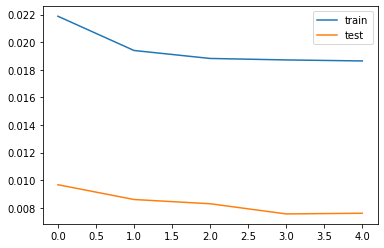

Calculating metrics
filename number 275
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.001821   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.001821   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.019572   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.009103   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.001821   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.001821  
2   0.403581   0.909091        1.0  0.019572  
3   0.414601   0.870130        1.0  0.009103  
4   0.414601   0.870130        1.0  0.001821  
5   0.362948   0.883117        1.0  0.001365  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0188 - val_los

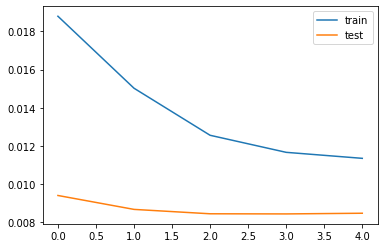

Calculating metrics
filename number 276
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.101899   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.108108   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.127831   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.104456   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.092768   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.108108  
2   0.403581   0.909091        1.0  0.127831  
3   0.414601   0.870130        1.0  0.104456  
4   0.414601   0.870130        1.0  0.092768  
5   0.362948   0.883117        1.0  0.105186  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0535 - val_los

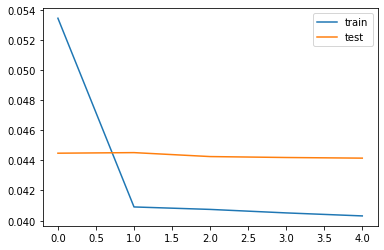

Calculating metrics
filename number 277
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.021416   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.036713   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.013986   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.020979   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020105   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.036713  
2   0.403581   0.909091        1.0  0.013986  
3   0.414601   0.870130        1.0  0.020979  
4   0.414601   0.870130        1.0  0.020105  
5   0.362948   0.883117        1.0  0.032343  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0497 - val_los

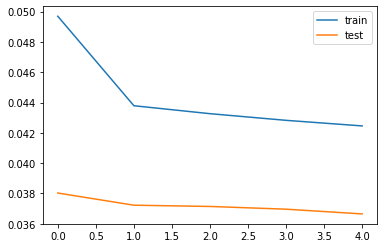

Calculating metrics
filename number 278
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.039803   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.049013   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.052303   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.047368   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.045066   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.049013  
2   0.403581   0.909091        1.0  0.052303  
3   0.414601   0.870130        1.0  0.047368  
4   0.414601   0.870130        1.0  0.045066  
5   0.362948   0.883117        1.0  0.049671  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0277 - val_los

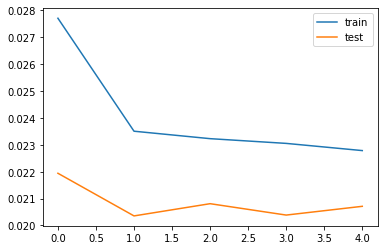

Calculating metrics
filename number 279
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.031870   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.026204   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.028329   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.048513   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.119334   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.026204  
2   0.403581   0.909091        1.0  0.028329  
3   0.414601   0.870130        1.0  0.048513  
4   0.414601   0.870130        1.0  0.119334  
5   0.362948   0.883117        1.0  0.142351  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0338 - val_los

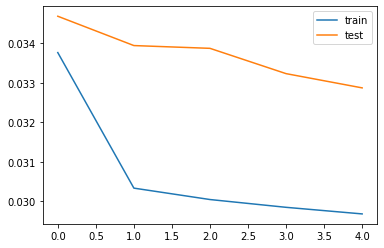

Calculating metrics
filename number 280
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.036753   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.033691   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.035222   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.093415   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.041348   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.033691  
2   0.403581   0.909091        1.0  0.035222  
3   0.414601   0.870130        1.0  0.093415  
4   0.414601   0.870130        1.0  0.041348  
5   0.362948   0.883117        1.0  0.038285  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 54us/step - loss: 0.0433 - val_los

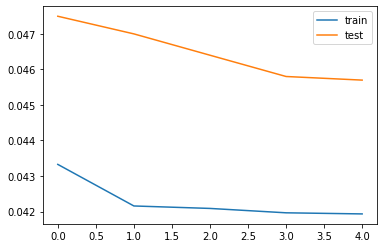

Calculating metrics
filename number 281
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.020423   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.030635   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.013129   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.008023   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.026258   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.030635  
2   0.403581   0.909091        1.0  0.013129  
3   0.414601   0.870130        1.0  0.008023  
4   0.414601   0.870130        1.0  0.026258  
5   0.362948   0.883117        1.0  0.016047  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 56us/step - loss: 0.0400 - val_los

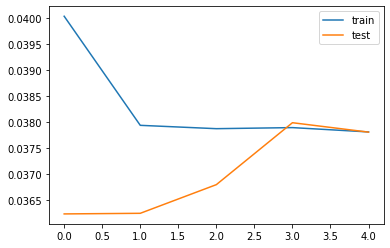

Calculating metrics
filename number 282
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.032218   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.031599   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.031599   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.017348   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.000000   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.031599  
2   0.403581   0.909091        1.0  0.031599  
3   0.414601   0.870130        1.0  0.017348  
4   0.414601   0.870130        1.0  0.000000  
5   0.362948   0.883117        1.0  0.000000  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0442 - val_los

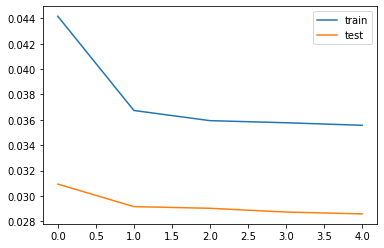

Calculating metrics
filename number 283
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.056911   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.036273   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.063790   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.042527   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.037523   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.036273  
2   0.403581   0.909091        1.0  0.063790  
3   0.414601   0.870130        1.0  0.042527  
4   0.414601   0.870130        1.0  0.037523  
5   0.362948   0.883117        1.0  0.061288  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 65us/step - loss: 0.0289 - val_los

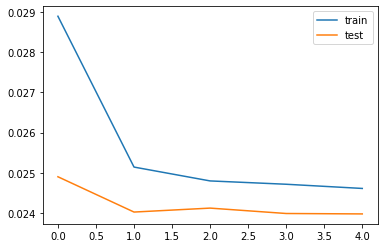

Calculating metrics
filename number 284
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129697   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.111111   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.110303   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.102626   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.076768   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.111111  
2   0.403581   0.909091        1.0  0.110303  
3   0.414601   0.870130        1.0  0.102626  
4   0.414601   0.870130        1.0  0.076768  
5   0.362948   0.883117        1.0  0.036768  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 76us/step - loss: 0.0517 - val_los

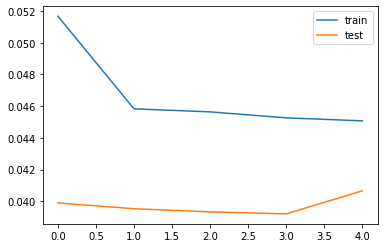

Calculating metrics
filename number 285
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.128417   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.113795   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.074380   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.016529   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.015893   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.113795  
2   0.403581   0.909091        1.0  0.074380  
3   0.414601   0.870130        1.0  0.016529  
4   0.414601   0.870130        1.0  0.015893  
5   0.362948   0.883117        1.0  0.008264  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0486 - val_los

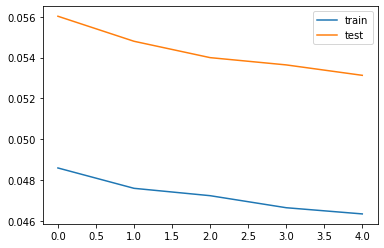

Calculating metrics
filename number 286
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.002915   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.005831   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.002915   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.064140   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.221574   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.005831  
2   0.403581   0.909091        1.0  0.002915  
3   0.414601   0.870130        1.0  0.064140  
4   0.414601   0.870130        1.0  0.221574  
5   0.362948   0.883117        1.0  0.090379  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 94us/step - loss: 0.0989 - val_los

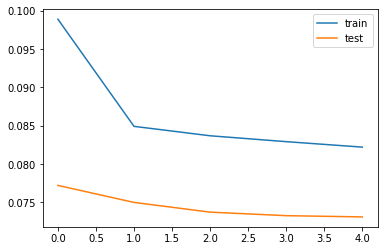

Calculating metrics
filename number 287
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.080351   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.068197   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.057394   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.022282   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020257   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.068197  
2   0.403581   0.909091        1.0  0.057394  
3   0.414601   0.870130        1.0  0.022282  
4   0.414601   0.870130        1.0  0.020257  
5   0.362948   0.883117        1.0  0.009453  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0205 - val_los

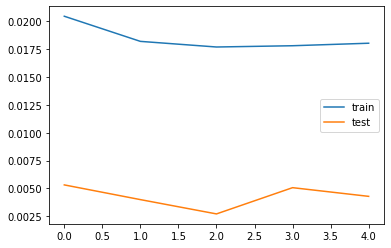

Calculating metrics
filename number 288
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.168687   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.173401   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.137374   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.129966   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.142424   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.173401  
2   0.403581   0.909091        1.0  0.137374  
3   0.414601   0.870130        1.0  0.129966  
4   0.414601   0.870130        1.0  0.142424  
5   0.362948   0.883117        1.0  0.103704  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0552 - val_los

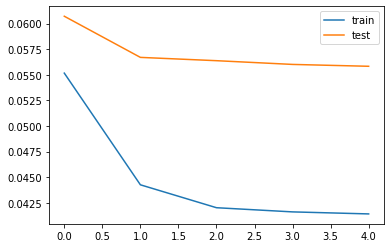

Calculating metrics
filename number 289
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.050000   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.033529   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.033529   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.034118   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.034118   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.033529  
2   0.403581   0.909091        1.0  0.033529  
3   0.414601   0.870130        1.0  0.034118  
4   0.414601   0.870130        1.0  0.034118  
5   0.362948   0.883117        1.0  0.034118  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0343 - val_los

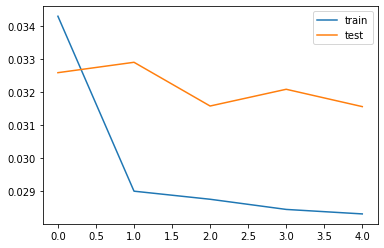

Calculating metrics
filename number 290
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.091033   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.089480   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.108307   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.102290   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.104231   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.089480  
2   0.403581   0.909091        1.0  0.108307  
3   0.414601   0.870130        1.0  0.102290  
4   0.414601   0.870130        1.0  0.104231  
5   0.362948   0.883117        1.0  0.142857  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 71us/step - loss: 0.0392 - val_los

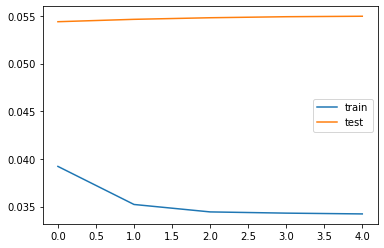

Calculating metrics
filename number 291
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.242942   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.256315   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.259287   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.283061   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.236998   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.256315  
2   0.403581   0.909091        1.0  0.259287  
3   0.414601   0.870130        1.0  0.283061  
4   0.414601   0.870130        1.0  0.236998  
5   0.362948   0.883117        1.0  0.128529  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0482 - val_los

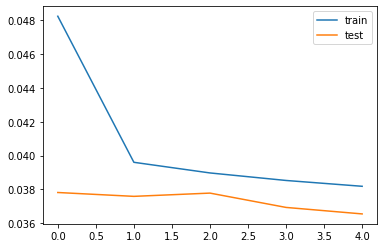

Calculating metrics
filename number 292
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.230894   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.446070   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.649864   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.315989   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.222222   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.446070  
2   0.403581   0.909091        1.0  0.649864  
3   0.414601   0.870130        1.0  0.315989  
4   0.414601   0.870130        1.0  0.222222  
5   0.362948   0.883117        1.0  0.226558  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 84us/step - loss: 0.0555 - val_los

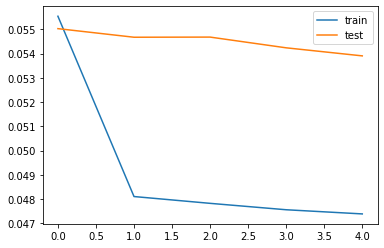

Calculating metrics
filename number 293
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.053018   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.088433   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.007963   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.066010   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.034158   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.088433  
2   0.403581   0.909091        1.0  0.007963  
3   0.414601   0.870130        1.0  0.066010  
4   0.414601   0.870130        1.0  0.034158  
5   0.362948   0.883117        1.0  0.034158  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 71us/step - loss: 0.0426 - val_los

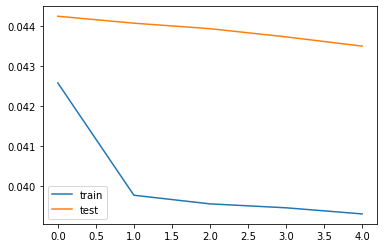

Calculating metrics
filename number 294
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.029412   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.030129   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.003587   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.018651   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.003587   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.030129  
2   0.403581   0.909091        1.0  0.003587  
3   0.414601   0.870130        1.0  0.018651  
4   0.414601   0.870130        1.0  0.003587  
5   0.362948   0.883117        1.0  0.017934  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 73us/step - loss: 0.0298 - val_los

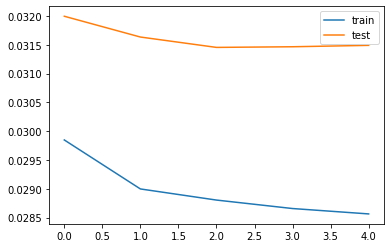

Calculating metrics
filename number 295
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.080287   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.077419   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.088172   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.074910   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.083154   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.077419  
2   0.403581   0.909091        1.0  0.088172  
3   0.414601   0.870130        1.0  0.074910  
4   0.414601   0.870130        1.0  0.083154  
5   0.362948   0.883117        1.0  0.072401  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0397 - val_los

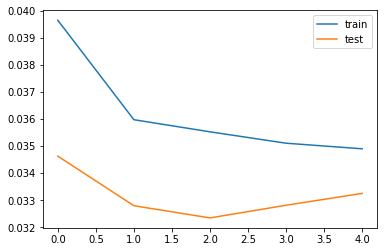

Calculating metrics
filename number 296
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008497   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.007668   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.009948   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.009534   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.010777   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.007668  
2   0.403581   0.909091        1.0  0.009948  
3   0.414601   0.870130        1.0  0.009534  
4   0.414601   0.870130        1.0  0.010777  
5   0.362948   0.883117        1.0  0.008083  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 68us/step - loss: 0.0371 - val_los

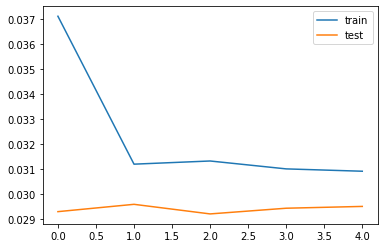

Calculating metrics
filename number 297
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.078266   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.099944   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.163288   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.164977   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.077984   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.099944  
2   0.403581   0.909091        1.0  0.163288  
3   0.414601   0.870130        1.0  0.164977  
4   0.414601   0.870130        1.0  0.077984  
5   0.362948   0.883117        1.0  0.071509  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 78us/step - loss: 0.0578 - val_los

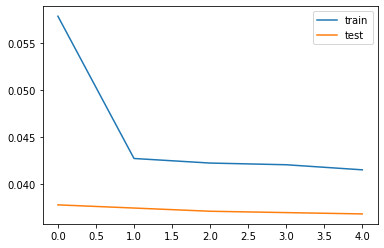

Calculating metrics
filename number 298
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.012616   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.015473   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.016187   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.012140   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.018805   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.015473  
2   0.403581   0.909091        1.0  0.016187  
3   0.414601   0.870130        1.0  0.012140  
4   0.414601   0.870130        1.0  0.018805  
5   0.362948   0.883117        1.0  0.006903  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 69us/step - loss: 0.0179 - val_los

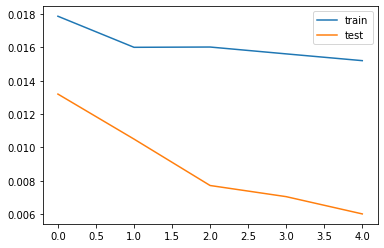

Calculating metrics
filename number 299
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.098375   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.087682   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.082549   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.064585   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.059880   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.087682  
2   0.403581   0.909091        1.0  0.082549  
3   0.414601   0.870130        1.0  0.064585  
4   0.414601   0.870130        1.0  0.059880  
5   0.362948   0.883117        1.0  0.079555  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 61us/step - loss: 0.0285 - val_los

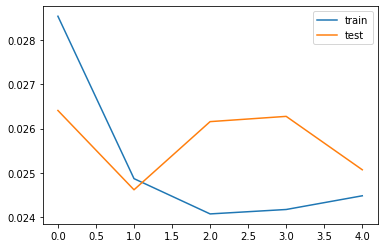

Calculating metrics
filename number 300
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.080655   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.052300   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.044108   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.008822   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.030246   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.052300  
2   0.403581   0.909091        1.0  0.044108  
3   0.414601   0.870130        1.0  0.008822  
4   0.414601   0.870130        1.0  0.030246  
5   0.362948   0.883117        1.0  0.011972  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0310 - val_los

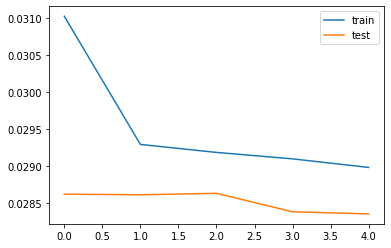

Calculating metrics
filename number 301
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.150587   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.085990   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.031040   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.033977   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.044883   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.085990  
2   0.403581   0.909091        1.0  0.031040  
3   0.414601   0.870130        1.0  0.033977  
4   0.414601   0.870130        1.0  0.044883  
5   0.362948   0.883117        1.0  0.030621  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0405 - val_los

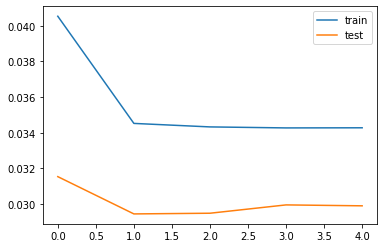

Calculating metrics
filename number 302
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.054086   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.053617   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.042379   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.044252   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.064388   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.053617  
2   0.403581   0.909091        1.0  0.042379  
3   0.414601   0.870130        1.0  0.044252  
4   0.414601   0.870130        1.0  0.064388  
5   0.362948   0.883117        1.0  0.054320  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0195 - val_los

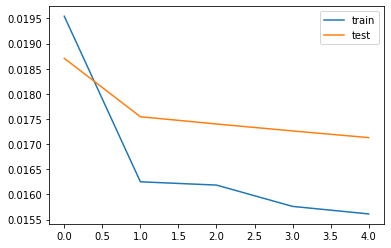

Calculating metrics
filename number 303
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.011861   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.013230   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.000912   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.016880   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.007755   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.013230  
2   0.403581   0.909091        1.0  0.000912  
3   0.414601   0.870130        1.0  0.016880  
4   0.414601   0.870130        1.0  0.007755  
5   0.362948   0.883117        1.0  0.002737  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0208 - val_los

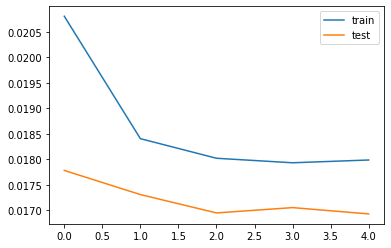

Calculating metrics
filename number 304
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.196440   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.110617   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.093452   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.043865   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.038779   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.110617  
2   0.403581   0.909091        1.0  0.093452  
3   0.414601   0.870130        1.0  0.043865  
4   0.414601   0.870130        1.0  0.038779  
5   0.362948   0.883117        1.0  0.039415  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0510 - val_los

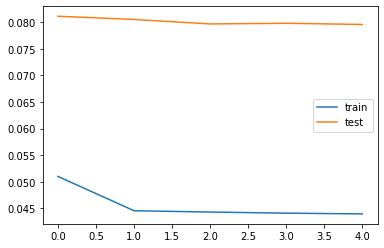

Calculating metrics
filename number 305
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.285616   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.283207   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.345148   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.332072   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.298004   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.283207  
2   0.403581   0.909091        1.0  0.345148  
3   0.414601   0.870130        1.0  0.332072  
4   0.414601   0.870130        1.0  0.298004  
5   0.362948   0.883117        1.0  0.298692  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0483 - val_los

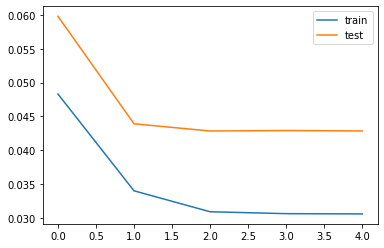

Calculating metrics
filename number 306
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.062247   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.060226   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.056589   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.053355   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.067502   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.060226  
2   0.403581   0.909091        1.0  0.056589  
3   0.414601   0.870130        1.0  0.053355  
4   0.414601   0.870130        1.0  0.067502  
5   0.362948   0.883117        1.0  0.065077  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0231 - val_los

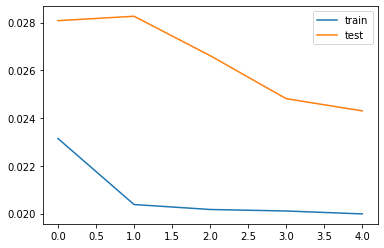

Calculating metrics
filename number 307
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.167515   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.178717   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.064155   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.022403   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020876   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.178717  
2   0.403581   0.909091        1.0  0.064155  
3   0.414601   0.870130        1.0  0.022403  
4   0.414601   0.870130        1.0  0.020876  
5   0.362948   0.883117        1.0  0.020367  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0421 - val_los

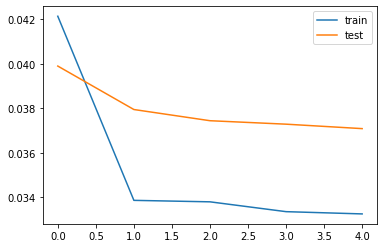

Calculating metrics
filename number 308
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.021837   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.073218   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.039820   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.019910   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.023764   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.073218  
2   0.403581   0.909091        1.0  0.039820  
3   0.414601   0.870130        1.0  0.019910  
4   0.414601   0.870130        1.0  0.023764  
5   0.362948   0.883117        1.0  0.018626  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0544 - val_los

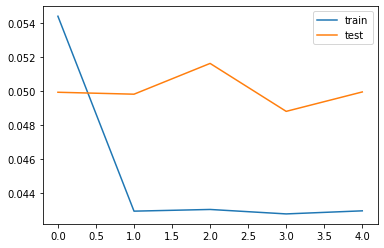

Calculating metrics
filename number 309
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008691   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.008691   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.037832   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.015337   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.008691   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.008691  
2   0.403581   0.909091        1.0  0.037832  
3   0.414601   0.870130        1.0  0.015337  
4   0.414601   0.870130        1.0  0.008691  
5   0.362948   0.883117        1.0  0.031697  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0491 - val_los

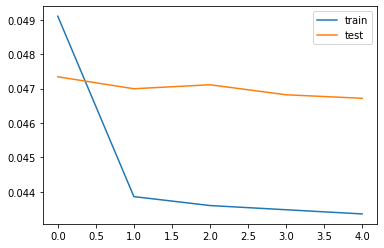

Calculating metrics
filename number 310
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.021690   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.022594   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.021690   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.022142   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.021690   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.022594  
2   0.403581   0.909091        1.0  0.021690  
3   0.414601   0.870130        1.0  0.022142  
4   0.414601   0.870130        1.0  0.021690  
5   0.362948   0.883117        1.0  0.022142  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0418 - val_los

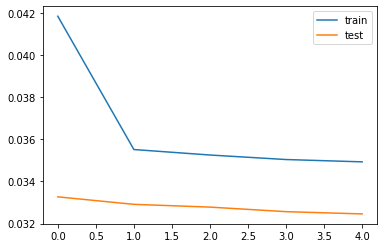

Calculating metrics
filename number 311
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.296774   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.278006   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.266276   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.272727   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.267449   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.278006  
2   0.403581   0.909091        1.0  0.266276  
3   0.414601   0.870130        1.0  0.272727  
4   0.414601   0.870130        1.0  0.267449  
5   0.362948   0.883117        1.0  0.270381  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0538 - val_los

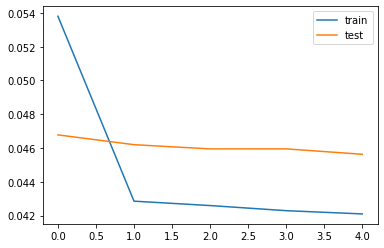

Calculating metrics
filename number 312
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.074933   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.069003   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.106739   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.073315   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.055526   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.069003  
2   0.403581   0.909091        1.0  0.106739  
3   0.414601   0.870130        1.0  0.073315  
4   0.414601   0.870130        1.0  0.055526  
5   0.362948   0.883117        1.0  0.059838  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0402 - val_los

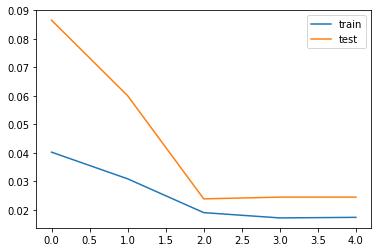

Calculating metrics
filename number 313
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.061543   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.427113   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.055871   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.005105   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.026092   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.427113  
2   0.403581   0.909091        1.0  0.055871  
3   0.414601   0.870130        1.0  0.005105  
4   0.414601   0.870130        1.0  0.026092  
5   0.362948   0.883117        1.0  0.029212  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0760 - val_los

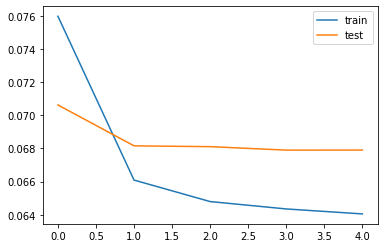

Calculating metrics
filename number 314
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008759   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.016058   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.016058   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.003406   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.014599   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.016058  
2   0.403581   0.909091        1.0  0.016058  
3   0.414601   0.870130        1.0  0.003406  
4   0.414601   0.870130        1.0  0.014599  
5   0.362948   0.883117        1.0  0.019465  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0295 - val_los

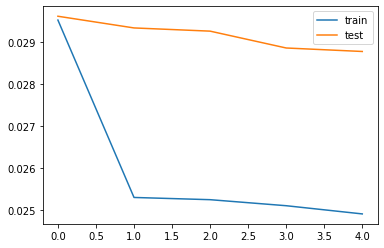

Calculating metrics
filename number 315
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.062992   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.015142   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.012114   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.010297   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.016959   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.015142  
2   0.403581   0.909091        1.0  0.012114  
3   0.414601   0.870130        1.0  0.010297  
4   0.414601   0.870130        1.0  0.016959  
5   0.362948   0.883117        1.0  0.016354  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0389 - val_los

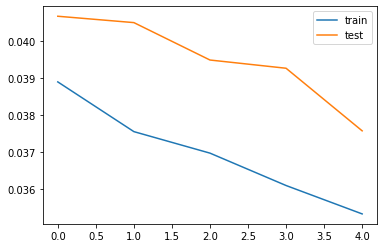

Calculating metrics
filename number 316
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064125   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.069613   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.065569   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.062103   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.069613   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.069613  
2   0.403581   0.909091        1.0  0.065569  
3   0.414601   0.870130        1.0  0.062103  
4   0.414601   0.870130        1.0  0.069613  
5   0.362948   0.883117        1.0  0.032062  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0466 - val_los

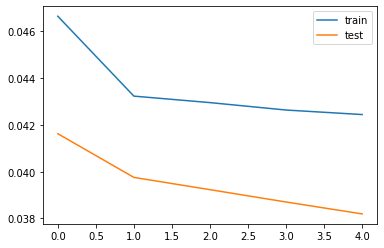

Calculating metrics
filename number 317
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.086264   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.052198   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.013736   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.002198   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.021429   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.052198  
2   0.403581   0.909091        1.0  0.013736  
3   0.414601   0.870130        1.0  0.002198  
4   0.414601   0.870130        1.0  0.021429  
5   0.362948   0.883117        1.0  0.035165  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0385 - val_los

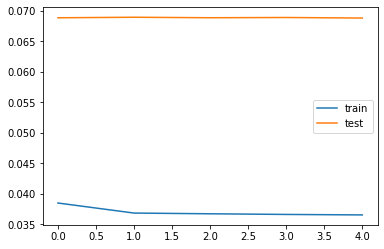

Calculating metrics
filename number 318
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.018777   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.018777   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.010917   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.011790   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020087   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.018777  
2   0.403581   0.909091        1.0  0.010917  
3   0.414601   0.870130        1.0  0.011790  
4   0.414601   0.870130        1.0  0.020087  
5   0.362948   0.883117        1.0  0.004367  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0330 - val_los

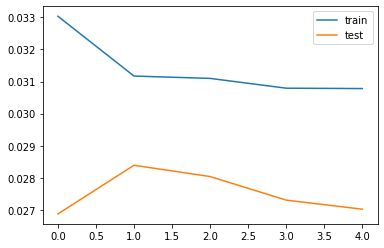

Calculating metrics
filename number 319
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.022879   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.026692   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.038608   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.031935   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020972   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.026692  
2   0.403581   0.909091        1.0  0.038608  
3   0.414601   0.870130        1.0  0.031935  
4   0.414601   0.870130        1.0  0.020972  
5   0.362948   0.883117        1.0  0.030505  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 56us/step - loss: 0.0504 - val_los

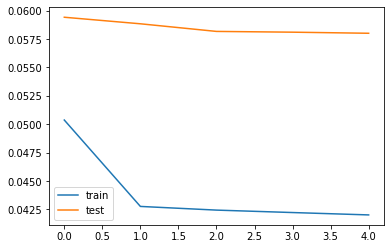

Calculating metrics
filename number 320
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.084461   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.054113   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.058867   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.054845   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.052285   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.054113  
2   0.403581   0.909091        1.0  0.058867  
3   0.414601   0.870130        1.0  0.054845  
4   0.414601   0.870130        1.0  0.052285  
5   0.362948   0.883117        1.0  0.059963  
Splitting into train and test
(33600, 1, 9) (33600,) (1439, 1, 9) (1439,)
Designing network
Fitting network
Train on 33600 samples, validate on 1439 samples
Epoch 1/5
33600/33600 [==============================] - 2s 63us/step - loss: 0.0383 - val_los

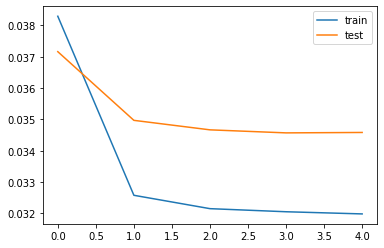

Calculating metrics
filename number 321
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.076325   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.074040   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.074497   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.052102   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.047075   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.074040  
2   0.403581   0.909091        1.0  0.074497  
3   0.414601   0.870130        1.0  0.052102  
4   0.414601   0.870130        1.0  0.047075  
5   0.362948   0.883117        1.0  0.047075  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0246 - val_los

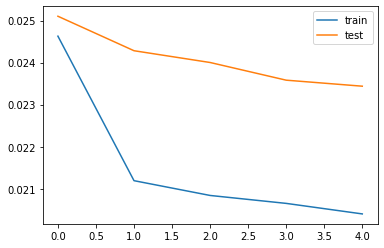

Calculating metrics
filename number 322
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.047664   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.045304   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.041057   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.044361   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.042001   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.045304  
2   0.403581   0.909091        1.0  0.041057  
3   0.414601   0.870130        1.0  0.044361  
4   0.414601   0.870130        1.0  0.042001  
5   0.362948   0.883117        1.0  0.043889  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0574 - val_los

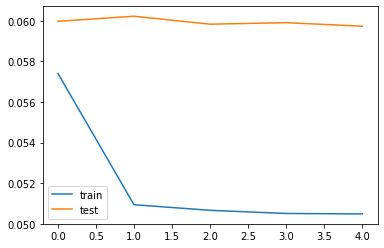

Calculating metrics
filename number 323
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.221214   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.045867   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.083612   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.021500   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.008600   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.045867  
2   0.403581   0.909091        1.0  0.083612  
3   0.414601   0.870130        1.0  0.021500  
4   0.414601   0.870130        1.0  0.008600  
5   0.362948   0.883117        1.0  0.028189  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 72us/step - loss: 0.0583 - val_los

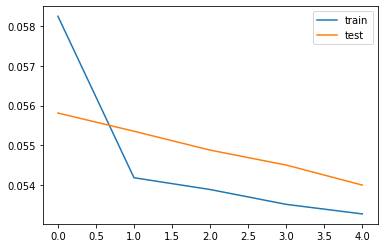

Calculating metrics
filename number 324
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1     0.0136   0.803549   0.637883   0.466877   0.718345   0.478840   
2     0.0040   0.803549   0.637883   0.466877   0.718345   0.478840   
3     0.0012   0.797212   0.662953   0.479232   0.720435   0.475585   
4     0.0008   0.797212   0.662953   0.479232   0.720435   0.475585   
5     0.0092   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)  var1(t)  
1   0.403581   0.909091        1.0   0.0040  
2   0.403581   0.909091        1.0   0.0012  
3   0.414601   0.870130        1.0   0.0008  
4   0.414601   0.870130        1.0   0.0092  
5   0.362948   0.883117        1.0   0.0088  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0255 - val_loss: 0.0

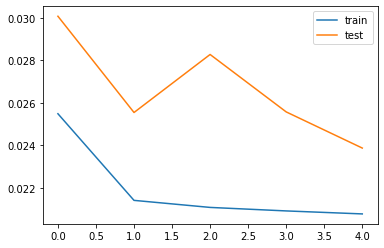

Calculating metrics
filename number 325
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.084674   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.298335   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.496754   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.476150   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.426757   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.298335  
2   0.403581   0.909091        1.0  0.496754  
3   0.414601   0.870130        1.0  0.476150  
4   0.414601   0.870130        1.0  0.426757  
5   0.362948   0.883117        1.0  0.042901  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 81us/step - loss: 0.0755 - val_los

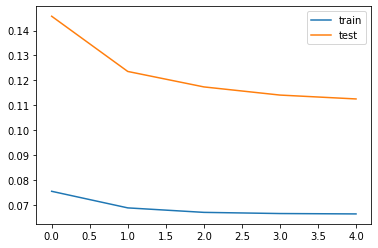

Calculating metrics
filename number 326
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.141348   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.086522   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.068247   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.067105   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.261565   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.086522  
2   0.403581   0.909091        1.0  0.068247  
3   0.414601   0.870130        1.0  0.067105  
4   0.414601   0.870130        1.0  0.261565  
5   0.362948   0.883117        1.0  0.169332  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0500 - val_los

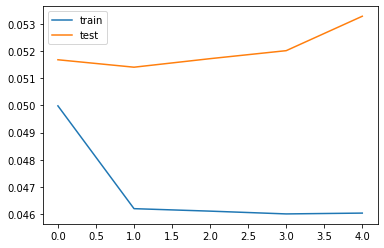

Calculating metrics
filename number 327
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.006379   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.010795   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.010304   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.005888   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.006869   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.010795  
2   0.403581   0.909091        1.0  0.010304  
3   0.414601   0.870130        1.0  0.005888  
4   0.414601   0.870130        1.0  0.006869  
5   0.362948   0.883117        1.0  0.010795  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0176 - val_los

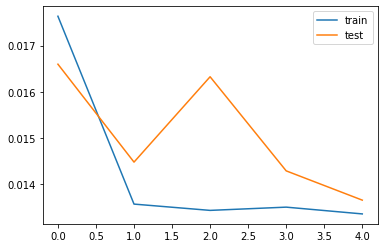

Calculating metrics
filename number 328
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.017019   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.017606   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.016432   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.023474   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.011737   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.017606  
2   0.403581   0.909091        1.0  0.016432  
3   0.414601   0.870130        1.0  0.023474  
4   0.414601   0.870130        1.0  0.011737  
5   0.362948   0.883117        1.0  0.021714  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0356 - val_los

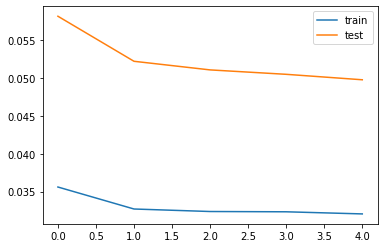

Calculating metrics
filename number 329
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.035097   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.019329   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.000000   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.030010   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.028993   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.019329  
2   0.403581   0.909091        1.0  0.000000  
3   0.414601   0.870130        1.0  0.030010  
4   0.414601   0.870130        1.0  0.028993  
5   0.362948   0.883117        1.0  0.000000  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0341 - val_los

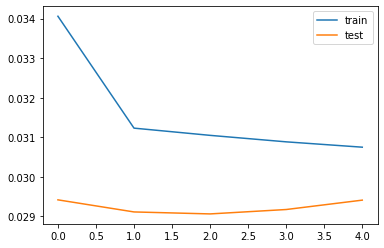

Calculating metrics
filename number 330
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.156296   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.085926   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.035556   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.051111   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.038148   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.085926  
2   0.403581   0.909091        1.0  0.035556  
3   0.414601   0.870130        1.0  0.051111  
4   0.414601   0.870130        1.0  0.038148  
5   0.362948   0.883117        1.0  0.017037  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0471 - val_los

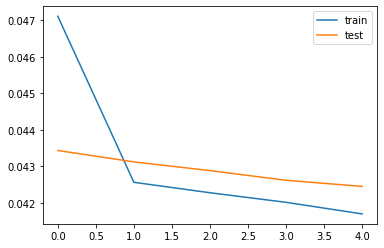

Calculating metrics
filename number 331
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.025629   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.020137   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.025629   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.023799   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.020137   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.020137  
2   0.403581   0.909091        1.0  0.025629  
3   0.414601   0.870130        1.0  0.023799  
4   0.414601   0.870130        1.0  0.020137  
5   0.362948   0.883117        1.0  0.026545  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0307 - val_los

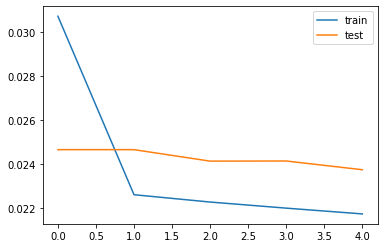

Calculating metrics
filename number 332
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.077701   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.097392   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.060138   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.060138   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.068654   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.097392  
2   0.403581   0.909091        1.0  0.060138  
3   0.414601   0.870130        1.0  0.060138  
4   0.414601   0.870130        1.0  0.068654  
5   0.362948   0.883117        1.0  0.113890  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 81us/step - loss: 0.0209 - val_los

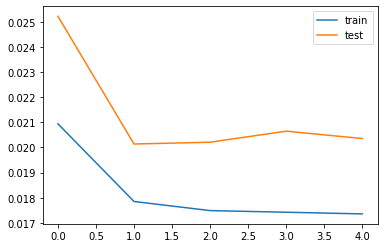

Calculating metrics
filename number 333
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.039049   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.007923   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.036786   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.020939   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.021505   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.007923  
2   0.403581   0.909091        1.0  0.036786  
3   0.414601   0.870130        1.0  0.020939  
4   0.414601   0.870130        1.0  0.021505  
5   0.362948   0.883117        1.0  0.029428  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 75us/step - loss: 0.0383 - val_los

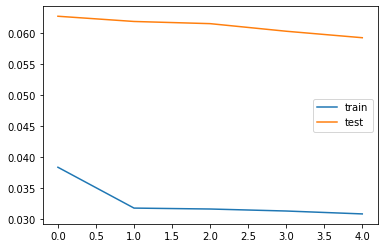

Calculating metrics
filename number 334
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.004982   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.004429   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.005352   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.003691   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.003137   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.004429  
2   0.403581   0.909091        1.0  0.005352  
3   0.414601   0.870130        1.0  0.003691  
4   0.414601   0.870130        1.0  0.003137  
5   0.362948   0.883117        1.0  0.008120  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 64us/step - loss: 0.0380 - val_los

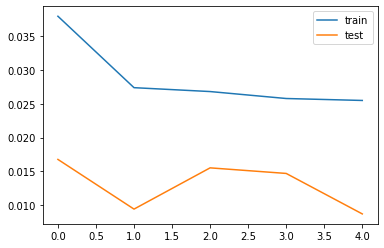

Calculating metrics
filename number 335
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.173243   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.154747   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.158446   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.039457   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.088163   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.154747  
2   0.403581   0.909091        1.0  0.158446  
3   0.414601   0.870130        1.0  0.039457  
4   0.414601   0.870130        1.0  0.088163  
5   0.362948   0.883117        1.0  0.063502  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 67us/step - loss: 0.0375 - val_los

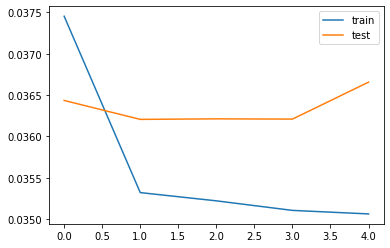

Calculating metrics
filename number 336
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.081957   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.041931   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.030813   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.021919   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.019695   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.041931  
2   0.403581   0.909091        1.0  0.030813  
3   0.414601   0.870130        1.0  0.021919  
4   0.414601   0.870130        1.0  0.019695  
5   0.362948   0.883117        1.0  0.034307  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0398 - val_los

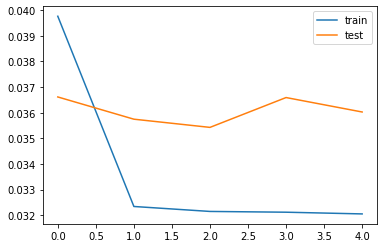

Calculating metrics
filename number 337
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.045735   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.013597   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.031520   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.016687   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.027194   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.013597  
2   0.403581   0.909091        1.0  0.031520  
3   0.414601   0.870130        1.0  0.016687  
4   0.414601   0.870130        1.0  0.027194  
5   0.362948   0.883117        1.0  0.028430  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 60us/step - loss: 0.0281 - val_los

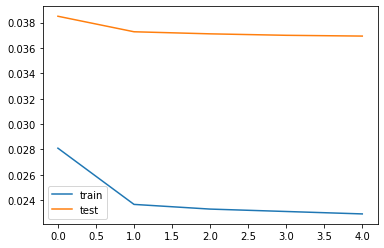

Calculating metrics
filename number 338
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.059200   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.074486   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.058644   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.076431   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.218733   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.074486  
2   0.403581   0.909091        1.0  0.058644  
3   0.414601   0.870130        1.0  0.076431  
4   0.414601   0.870130        1.0  0.218733  
5   0.362948   0.883117        1.0  0.372985  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 62us/step - loss: 0.0686 - val_los

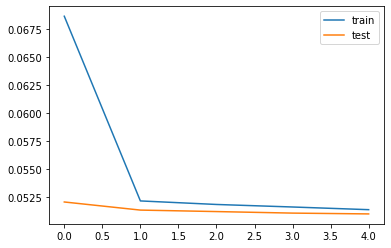

Calculating metrics
filename number 339
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.048502   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.025678   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.041369   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.049929   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.027104   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.025678  
2   0.403581   0.909091        1.0  0.041369  
3   0.414601   0.870130        1.0  0.049929  
4   0.414601   0.870130        1.0  0.027104  
5   0.362948   0.883117        1.0  0.034237  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0448 - val_los

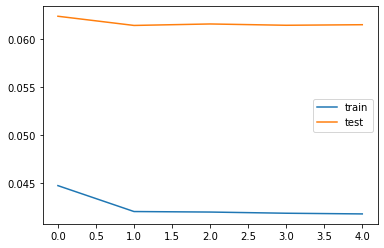

Calculating metrics
filename number 340
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.117908   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.114455   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.123335   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.076961   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.060187   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.114455  
2   0.403581   0.909091        1.0  0.123335  
3   0.414601   0.870130        1.0  0.076961  
4   0.414601   0.870130        1.0  0.060187  
5   0.362948   0.883117        1.0  0.060187  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0364 - val_los

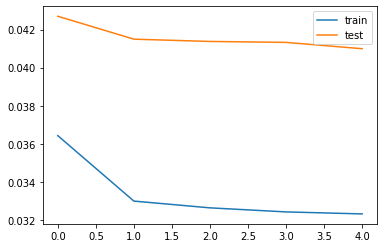

Calculating metrics
filename number 341
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.058846   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.555598   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.448987   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.037447   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.030569   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.555598  
2   0.403581   0.909091        1.0  0.448987  
3   0.414601   0.870130        1.0  0.037447  
4   0.414601   0.870130        1.0  0.030569  
5   0.362948   0.883117        1.0  0.033626  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 66us/step - loss: 0.0733 - val_los

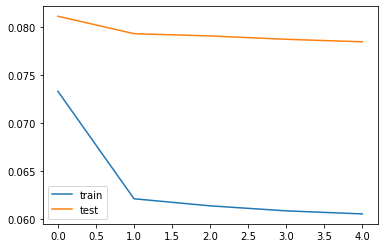

Calculating metrics
filename number 342
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.017799   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.015102   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.015642   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.015642   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.015642   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.015102  
2   0.403581   0.909091        1.0  0.015642  
3   0.414601   0.870130        1.0  0.015642  
4   0.414601   0.870130        1.0  0.015642  
5   0.362948   0.883117        1.0  0.015642  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 59us/step - loss: 0.0446 - val_los

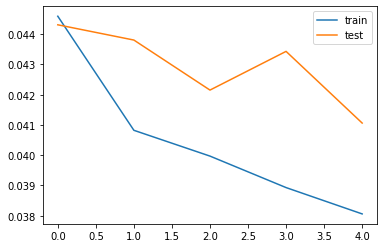

Calculating metrics
filename number 343
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.035649   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.026508   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.049360   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.041133   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.022852   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.026508  
2   0.403581   0.909091        1.0  0.049360  
3   0.414601   0.870130        1.0  0.041133  
4   0.414601   0.870130        1.0  0.022852  
5   0.362948   0.883117        1.0  0.049360  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 58us/step - loss: 0.0340 - val_los

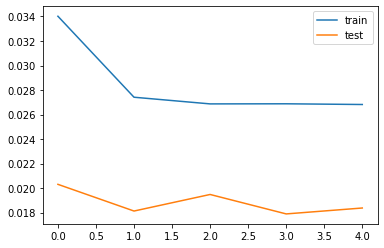

Calculating metrics
filename number 344
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.136885   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.068852   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.076230   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.070492   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.064754   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.068852  
2   0.403581   0.909091        1.0  0.076230  
3   0.414601   0.870130        1.0  0.070492  
4   0.414601   0.870130        1.0  0.064754  
5   0.362948   0.883117        1.0  0.034426  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 57us/step - loss: 0.0325 - val_los

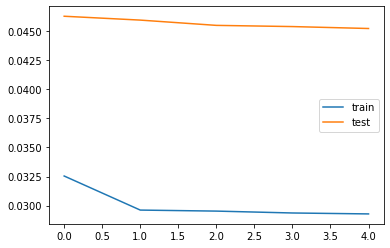

Calculating metrics
filename number 345
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.145771   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.128347   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.118785   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.120059   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.121334   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.128347  
2   0.403581   0.909091        1.0  0.118785  
3   0.414601   0.870130        1.0  0.120059  
4   0.414601   0.870130        1.0  0.121334  
5   0.362948   0.883117        1.0  0.115810  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 78us/step - loss: 0.0583 - val_los

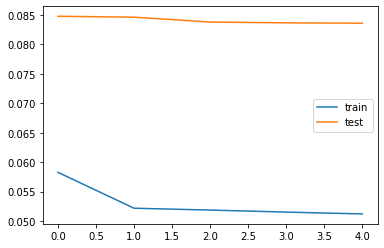

Calculating metrics
filename number 346
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064265   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.055331   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.070317   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.047262   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.016138   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.055331  
2   0.403581   0.909091        1.0  0.070317  
3   0.414601   0.870130        1.0  0.047262  
4   0.414601   0.870130        1.0  0.016138  
5   0.362948   0.883117        1.0  0.014697  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 71us/step - loss: 0.0292 - val_los

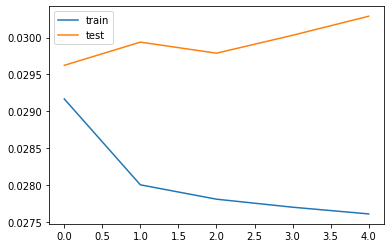

Calculating metrics
filename number 347
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.061648   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.059647   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.081288   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.053101   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.041280   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.059647  
2   0.403581   0.909091        1.0  0.081288  
3   0.414601   0.870130        1.0  0.053101  
4   0.414601   0.870130        1.0  0.041280  
5   0.362948   0.883117        1.0  0.044372  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 3s 79us/step - loss: 0.0500 - val_los

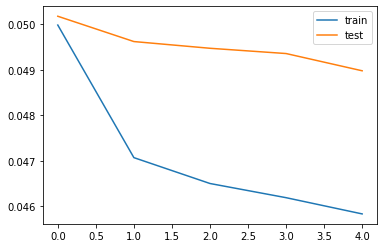

Calculating metrics
filename number 348
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.065990   0.803549   0.637883   0.466877   0.718345   0.478840   
2   0.067259   0.803549   0.637883   0.466877   0.718345   0.478840   
3   0.076142   0.797212   0.662953   0.479232   0.720435   0.475585   
4   0.069797   0.797212   0.662953   0.479232   0.720435   0.475585   
5   0.067893   0.711660   0.637883   0.475552   0.721270   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.067259  
2   0.403581   0.909091        1.0  0.076142  
3   0.414601   0.870130        1.0  0.069797  
4   0.414601   0.870130        1.0  0.067893  
5   0.362948   0.883117        1.0  0.079949  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 33600 samples, validate on 1455 samples
Epoch 1/5
33600/33600 [==============================] - 2s 70us/step - loss: 0.0482 - val_los

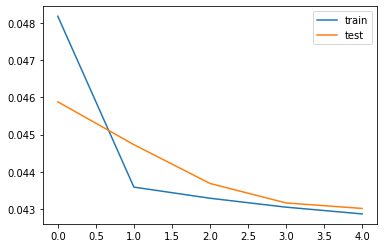

Calculating metrics


In [23]:
# load the dataset
path = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/code_datasets/1_data_frames/multivariate/"
all_files = glob.glob(path + "/*.csv")

i = 0
mape_t = []
rmsle_t = []
for filename in all_files:
    i = i + 1
    print('filename number ' + str(i))
    df = pd.read_csv(filename,parse_dates = ['tstp'], index_col = ['tstp'])
    mape_i,rmsle_i = lstm_multivariate(df)
    mape_t.append(mape_i)
    rmsle_t.append(rmsle_i)

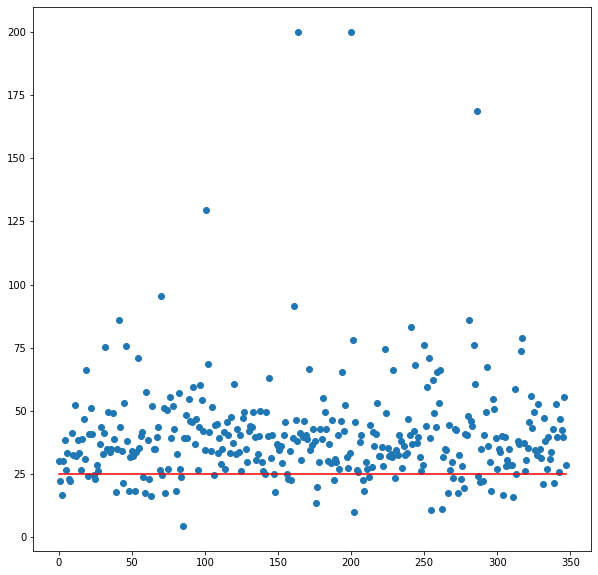

In [24]:
plt.figure(figsize = (10,10))
plt.scatter(range(348),mape_t)
plt.plot(range(348),[25]*348,color = 'red')
plt.show()

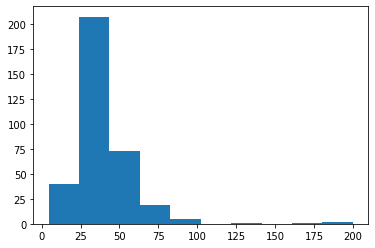

In [25]:
plt.hist(mape_t)
plt.show()

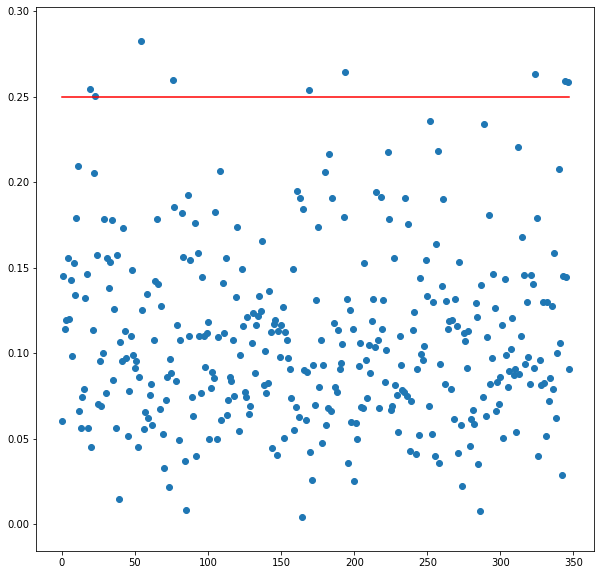

In [26]:
plt.figure(figsize = (10,10))
plt.scatter(range(348),rmsle_t)
plt.plot(range(348),[0.25]*348,color = 'red')
plt.show()

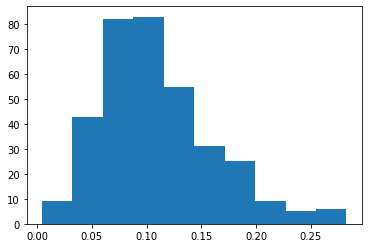

In [27]:
plt.hist(rmsle_t)
plt.show()